
train NNDF
=======

Proof-of-concept to train an ANN model on a computational fluid dynamics (CFD) solution (incompressible finite difference solution on Cartesian homogeneous mesh, immersed boundary, fractional step method).

Concept
-------
The key idea is that the cell update is a local problem adhering to the conservation of mass, momentum, and energy. This is typically decribed by a local discretization of the differential or integral conservation equations, involving a local stencil (pattern of cells) surrounding the cell of interest to compute the time advancement. The key idea here is to have these functions learned by a neural net, without spelling them out.

In this sense, it can be understood as a poor-man's convolutional neureal net, in that the stencil is applied to cells with a stride of one. Here, there is only one complex filter acting at all cells. The dimensionality is given by the number of variables; in the 2D case regarded here this amounts to the x and y components of the velocity vector, and the marker function distinguishing a fluid from a solid cell.

The training data set treats all sets of cell, stencil, and value in next time-step identically.


Current state
------------
The subsequent step can be predicted with an error of $\approx 4.0\times 10^{-6}$ compared to the CFD solution.

TODO
----
- reduce error of trained network (symmetries, training data, periodic case)
- reduce required stencil size
- minimize ANN size
- incorporate more into NN atrchitecture rather than poor-man's procedure used herein
- include conservation laws directly in loss function

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [4]:
# YtestDf = pd.read_csv("traindatashort.dat", sep = ' ',usecols=['Up','Wp'])
# XtestDf = pd.read_csv("traindatashort.dat",sep=' ', usecols=['U','W','U0','W0','U1','W1',
#                                                             'U2','W2','U3','W3','U4','W4',
#                                                             'U5','W5','U6','W6','U7','W7',
#                                                               'isfluid'])

YtruthDf = pd.read_csv("traindata.dat", sep = ' ',usecols=['Up','Wp'])
XtruthDf = pd.read_csv("traindata.dat",sep=' ', usecols=['U','W','U0','W0','U1','W1',
                                                            'U2','W2','U3','W3','U4','W4',
                                                            'U5','W5','U6','W6','U7','W7',
                                                            'isfluid'])




print YtruthDf.values

Ytruth = torch.tensor(YtruthDf.values).float()
Xtruth = torch.tensor(XtruthDf.values).float()
N     = Ytruth.size()[0]
D_out = Ytruth.size()[1]
D_in  = Xtruth.size()[1]

print'Batchsize ',N
print'D_in      ',D_in
print'D_out     ',D_out



[[ 1.08443105 -0.05279202]
 [ 1.08323586 -0.05878621]
 [ 1.081864   -0.06470758]
 ...
 [ 1.34644949  0.3583608 ]
 [ 1.39562786  0.3359133 ]
 [ 1.4339664   0.31115744]]
Batchsize  200000
D_in       19
D_out      2


In [7]:
x = Xtruth
y = Ytruth

# works well, converges after 50000 epochs to 4.0e-6
# # H1, H2, H3 = 50, 8
# H1, H2, H3 = 100, 80, 20
# model = torch.nn.Sequential(
#     torch.nn.Linear(D_in, H1),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H1, H2),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H2, H3),
#     torch.nn.ReLU(),
#     torch.nn.Linear(H3, D_out),
# )



#error = 6.8e-6 after 50000
H1, H2, H3, H4 = 60, 60, 30, 10
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.Softplus(),
    torch.nn.Linear(H3, H4),
    torch.nn.Softplus(),
    torch.nn.Linear(H4, D_out),
)



# loss_fn = torch.nn.MSELoss(reduction='sum') # produces error, removed below
loss_fn = torch.nn.MSELoss()


In [9]:

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(50000):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    print(t, loss.item())
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

(0, 0.9817301034927368)
(1, 0.9780970811843872)
(2, 0.9744541645050049)
(3, 0.9706622362136841)
(4, 0.9670664668083191)
(5, 0.9634907841682434)
(6, 0.9598928689956665)
(7, 0.9563511610031128)
(8, 0.9524083733558655)
(9, 0.9489021897315979)
(10, 0.945379376411438)
(11, 0.9418396353721619)
(12, 0.9383674263954163)
(13, 0.9348816275596619)
(14, 0.9312102198600769)
(15, 0.927777111530304)
(16, 0.9243385791778564)
(17, 0.9209198951721191)
(18, 0.9174713492393494)
(19, 0.9140795469284058)
(20, 0.910717785358429)
(21, 0.9073458313941956)
(22, 0.9039762616157532)
(23, 0.9006446599960327)
(24, 0.8972698450088501)
(25, 0.8939494490623474)
(26, 0.8906307220458984)
(27, 0.8873231410980225)
(28, 0.8838405609130859)
(29, 0.8805568814277649)
(30, 0.877292275428772)
(31, 0.8739848732948303)
(32, 0.8707442879676819)
(33, 0.8674826622009277)
(34, 0.8642497062683105)
(35, 0.8607581853866577)
(36, 0.8575549125671387)
(37, 0.8543479442596436)
(38, 0.8511542081832886)
(39, 0.8479058742523193)
(40, 0.8447302

(316, 0.08677270263433456)
(317, 0.08641951531171799)
(318, 0.08607535064220428)
(319, 0.08573157340288162)
(320, 0.08540021628141403)
(321, 0.08506059646606445)
(322, 0.08473071455955505)
(323, 0.08443832397460938)
(324, 0.08411815762519836)
(325, 0.08379971981048584)
(326, 0.0834914967417717)
(327, 0.08318193256855011)
(328, 0.08287439495325089)
(329, 0.0825696662068367)
(330, 0.08226568251848221)
(331, 0.08196480572223663)
(332, 0.0816681757569313)
(333, 0.0813731923699379)
(334, 0.081078439950943)
(335, 0.08078715950250626)
(336, 0.08048813790082932)
(337, 0.0801977664232254)
(338, 0.07991047203540802)
(339, 0.07962246239185333)
(340, 0.07933657616376877)
(341, 0.0790470689535141)
(342, 0.07876119762659073)
(343, 0.07847517728805542)
(344, 0.07818907499313354)
(345, 0.07787378132343292)
(346, 0.07758824527263641)
(347, 0.07729988545179367)
(348, 0.07701313495635986)
(349, 0.07672516256570816)
(350, 0.07643725723028183)
(351, 0.07614848762750626)
(352, 0.07585105299949646)
(353, 0.0

(617, 0.00849448423832655)
(618, 0.008410191163420677)
(619, 0.008324605412781239)
(620, 0.008243078365921974)
(621, 0.008158558048307896)
(622, 0.008079320192337036)
(623, 0.007998843677341938)
(624, 0.007917486131191254)
(625, 0.007838204503059387)
(626, 0.007759209722280502)
(627, 0.007679763250052929)
(628, 0.007602952420711517)
(629, 0.007526708301156759)
(630, 0.007448167540132999)
(631, 0.007373318541795015)
(632, 0.007296315860003233)
(633, 0.007221520412713289)
(634, 0.007147756405174732)
(635, 0.007073540240526199)
(636, 0.007001671940088272)
(637, 0.006929764989763498)
(638, 0.006857641506940126)
(639, 0.006786438636481762)
(640, 0.006718285381793976)
(641, 0.006647729314863682)
(642, 0.006578359752893448)
(643, 0.006509820464998484)
(644, 0.006442587822675705)
(645, 0.00637503806501627)
(646, 0.006309256423264742)
(647, 0.006241215858608484)
(648, 0.006175209768116474)
(649, 0.006111060734838247)
(650, 0.006044924259185791)
(651, 0.005981828551739454)
(652, 0.00591877521947

(904, 0.0007556690252386034)
(905, 0.0007521082879975438)
(906, 0.0007486561080440879)
(907, 0.0007452490972355008)
(908, 0.0007420188630931079)
(909, 0.0007386616780422628)
(910, 0.0007353879627771676)
(911, 0.0007318792049773037)
(912, 0.0007287422777153552)
(913, 0.0007255615200847387)
(914, 0.0007223233697004616)
(915, 0.0007190949399955571)
(916, 0.0007159596425481141)
(917, 0.0007128175348043442)
(918, 0.000709877407643944)
(919, 0.0007069057319313288)
(920, 0.0007036367314867675)
(921, 0.0007007126114331186)
(922, 0.0006976534496061504)
(923, 0.0006946309003978968)
(924, 0.0006918151048012078)
(925, 0.0006888696807436645)
(926, 0.0006858216365799308)
(927, 0.0006830744678154588)
(928, 0.0006802945863455534)
(929, 0.0006773688364773989)
(930, 0.0006745100254192948)
(931, 0.0006717969663441181)
(932, 0.0006691119633615017)
(933, 0.0006662650848738849)
(934, 0.0006636500474996865)
(935, 0.0006608553812839091)
(936, 0.0006582384230569005)
(937, 0.0006555267609655857)
(938, 0.0006529

(1179, 0.0003482535248622298)
(1180, 0.00034770098864100873)
(1181, 0.0003471718227956444)
(1182, 0.0003466308116912842)
(1183, 0.00034599631908349693)
(1184, 0.0003454708494246006)
(1185, 0.00034493335988372564)
(1186, 0.000344413478160277)
(1187, 0.0003438923740759492)
(1188, 0.0003433710371609777)
(1189, 0.0003428589552640915)
(1190, 0.0003423329908400774)
(1191, 0.0003418346750549972)
(1192, 0.0003413083904888481)
(1193, 0.00034069534740410745)
(1194, 0.000340196886099875)
(1195, 0.00033971111406572163)
(1196, 0.00033919952693395317)
(1197, 0.0003387110773473978)
(1198, 0.000338224956067279)
(1199, 0.00033774584881030023)
(1200, 0.0003372709034010768)
(1201, 0.00033679328043945134)
(1202, 0.0003363225841894746)
(1203, 0.0003357968234922737)
(1204, 0.00033532973611727357)
(1205, 0.00033485988387838006)
(1206, 0.00033439669641666114)
(1207, 0.00033382244873791933)
(1208, 0.0003333654021844268)
(1209, 0.0003328950551804155)
(1210, 0.0003324454592075199)
(1211, 0.00033196547883562744)


(1449, 0.00026041141245514154)
(1450, 0.00026022703968919814)
(1451, 0.0002600317820906639)
(1452, 0.0002598482242319733)
(1453, 0.0002596631529740989)
(1454, 0.0002594889374449849)
(1455, 0.00025930683477781713)
(1456, 0.0002591257798485458)
(1457, 0.0002589411160442978)
(1458, 0.00025875188293866813)
(1459, 0.00025857024593278766)
(1460, 0.0002583893365226686)
(1461, 0.0002582076413091272)
(1462, 0.00025798912975005805)
(1463, 0.00025781270232982934)
(1464, 0.0002576364204287529)
(1465, 0.0002574573445599526)
(1466, 0.0002572707599028945)
(1467, 0.0002570964861661196)
(1468, 0.0002569180796854198)
(1469, 0.000256648869253695)
(1470, 0.00025647555594332516)
(1471, 0.0002563012239988893)
(1472, 0.0002561281726229936)
(1473, 0.0002559454587753862)
(1474, 0.00025577301857993007)
(1475, 0.0002556007821112871)
(1476, 0.0002554297388996929)
(1477, 0.0002552173100411892)
(1478, 0.0002550467324908823)
(1479, 0.00025487635866738856)
(1480, 0.0002547059266362339)
(1481, 0.00025452792760916054)


(1718, 0.00022375724802259356)
(1719, 0.00022365603945218027)
(1720, 0.00022355842520482838)
(1721, 0.00022346022888086736)
(1722, 0.00022336348774842918)
(1723, 0.00022326539328787476)
(1724, 0.00022316802642308176)
(1725, 0.0002230598038295284)
(1726, 0.00022296217503026128)
(1727, 0.00022286617604549974)
(1728, 0.00022276681556832045)
(1729, 0.00022266909945756197)
(1730, 0.00022257147065829486)
(1731, 0.00022247266315389425)
(1732, 0.0002223764604423195)
(1733, 0.00022228099987842143)
(1734, 0.0002221850008936599)
(1735, 0.00022209013695828617)
(1736, 0.00022199403611011803)
(1737, 0.00022189754236023873)
(1738, 0.00022175499179866165)
(1739, 0.00022166044800542295)
(1740, 0.00022156514751259238)
(1741, 0.0002214703563367948)
(1742, 0.00022137633641250432)
(1743, 0.0002212799881817773)
(1744, 0.0002211833925684914)
(1745, 0.00022108769917394966)
(1746, 0.0002209918457083404)
(1747, 0.0002208988880738616)
(1748, 0.00022080299095250666)
(1749, 0.0002207076904596761)
(1750, 0.00022061

(1985, 0.0002011557517107576)
(1986, 0.0002010820753639564)
(1987, 0.00020095851505175233)
(1988, 0.00020088643941562623)
(1989, 0.00020081448019482195)
(1990, 0.00020074450003448874)
(1991, 0.0002006712311413139)
(1992, 0.00020060015958733857)
(1993, 0.00020052812760695815)
(1994, 0.0002004574052989483)
(1995, 0.00020038455841131508)
(1996, 0.00020031358872074634)
(1997, 0.00020024148398078978)
(1998, 0.00020016809867229313)
(1999, 0.0002000965760089457)
(2000, 0.0002000247040996328)
(2001, 0.00019995265756733716)
(2002, 0.0001998816296691075)
(2003, 0.00019980927754659206)
(2004, 0.00019973822054453194)
(2005, 0.00019966567924711853)
(2006, 0.00019959469500463456)
(2007, 0.00019952379807364196)
(2008, 0.00019945100939366966)
(2009, 0.00019937448087148368)
(2010, 0.00019930247799493372)
(2011, 0.00019923252693843096)
(2012, 0.00019916250312235206)
(2013, 0.000199092086404562)
(2014, 0.0001990211458178237)
(2015, 0.0001989512675208971)
(2016, 0.00019888080714736134)
(2017, 0.0001988102

(2253, 0.00018263996753375977)
(2254, 0.00018257235933560878)
(2255, 0.00018250456196255982)
(2256, 0.00018243721569888294)
(2257, 0.0001823686034185812)
(2258, 0.00018230249406769872)
(2259, 0.00018223455117549747)
(2260, 0.00018216769967693835)
(2261, 0.00018209981499239802)
(2262, 0.00018203364743385464)
(2263, 0.00018196758173871785)
(2264, 0.0001819017343223095)
(2265, 0.00018183543579652905)
(2266, 0.00018176750745624304)
(2267, 0.0001817037264117971)
(2268, 0.00018163777713198215)
(2269, 0.00018157067825086415)
(2270, 0.00018150551477447152)
(2271, 0.00018143990018870682)
(2272, 0.00018137456208933145)
(2273, 0.00018130787066183984)
(2274, 0.00018124279449693859)
(2275, 0.00018117717991117388)
(2276, 0.00018111118697561324)
(2277, 0.0001810463727451861)
(2278, 0.0001809814857551828)
(2279, 0.00018091783567797393)
(2280, 0.00018085252668242902)
(2281, 0.0001807876251405105)
(2282, 0.00018072238890454173)
(2283, 0.0001806586660677567)
(2284, 0.00018059503054246306)
(2285, 0.000180

(2520, 0.00016766834596637636)
(2521, 0.0001676190149737522)
(2522, 0.00016756984405219555)
(2523, 0.00016752039664424956)
(2524, 0.0001674717932473868)
(2525, 0.00016742282605264336)
(2526, 0.00016738720296416432)
(2527, 0.0001673379447311163)
(2528, 0.00016728873015381396)
(2529, 0.00016723897715564817)
(2530, 0.0001671894424362108)
(2531, 0.00016713996592443436)
(2532, 0.0001670911005930975)
(2533, 0.0001670426718192175)
(2534, 0.0001669942430453375)
(2535, 0.00016694559599272907)
(2536, 0.00016689725453034043)
(2537, 0.00016684846195857972)
(2538, 0.00016680020780768245)
(2539, 0.0001667507749516517)
(2540, 0.00016670150216668844)
(2541, 0.00016665390285197645)
(2542, 0.00016660454275552183)
(2543, 0.0001665556919761002)
(2544, 0.00016650751058477908)
(2545, 0.0001664579176576808)
(2546, 0.00016640970716252923)
(2547, 0.00016636135114822537)
(2548, 0.00016631284961476922)
(2549, 0.0001662639988353476)
(2550, 0.00016621612303424627)
(2551, 0.00016616861103102565)
(2552, 0.0001661203

(2788, 0.00015569792594760656)
(2789, 0.0001556559873279184)
(2790, 0.00015561362670268863)
(2791, 0.00015557084407191724)
(2792, 0.00015552910917904228)
(2793, 0.0001554868940729648)
(2794, 0.00015544497000519186)
(2795, 0.00015540265303570777)
(2796, 0.00015536123828496784)
(2797, 0.00015531881945207715)
(2798, 0.00015527632785961032)
(2799, 0.00015523382171522826)
(2800, 0.00015519185399170965)
(2801, 0.0001551498717162758)
(2802, 0.00015510778757743537)
(2803, 0.00015506515046581626)
(2804, 0.0001550238230265677)
(2805, 0.00015498202992603183)
(2806, 0.00015493937826249748)
(2807, 0.00015489780344069004)
(2808, 0.0001549181033624336)
(2809, 0.00015487568452954292)
(2810, 0.00015483368770219386)
(2811, 0.0001547912834212184)
(2812, 0.0001547504070913419)
(2813, 0.0001547082792967558)
(2814, 0.00015466661716345698)
(2815, 0.0001546245184727013)
(2816, 0.0001545827108202502)
(2817, 0.00015454008826054633)
(2818, 0.00015449733473360538)
(2819, 0.00015445608005393296)
(2820, 0.000154414

(3055, 0.00014488586748484522)
(3056, 0.00014484731946140528)
(3057, 0.00014480840764008462)
(3058, 0.0001447693502996117)
(3059, 0.00014472973998636007)
(3060, 0.00014474568888545036)
(3061, 0.00014470639871433377)
(3062, 0.00014466721040662378)
(3063, 0.00014462806575465947)
(3064, 0.00014458916848525405)
(3065, 0.00014455002383328974)
(3066, 0.00014451103925239295)
(3067, 0.00014447246212512255)
(3068, 0.0001444329391233623)
(3069, 0.00014439393999055028)
(3070, 0.00014435479533858597)
(3071, 0.00014431604358833283)
(3072, 0.00014427665155380964)
(3073, 0.00014423782704398036)
(3074, 0.00014419840590562671)
(3075, 0.0001441609492758289)
(3076, 0.00014412158634513617)
(3077, 0.0001440816995454952)
(3078, 0.00014404309331439435)
(3079, 0.00014400403597392142)
(3080, 0.00014396477490663528)
(3081, 0.00014392552839126438)
(3082, 0.00014388661656994373)
(3083, 0.0001438478793716058)
(3084, 0.00014380874927155674)
(3085, 0.0001437689206795767)
(3086, 0.00014373094018083066)
(3087, 0.00014

(3322, 0.00013481419591698796)
(3323, 0.0001347776415059343)
(3324, 0.0001347399957012385)
(3325, 0.0001347023353446275)
(3326, 0.00013466528616845608)
(3327, 0.00013462803326547146)
(3328, 0.0001345911150565371)
(3329, 0.00013455425505526364)
(3330, 0.00013451650738716125)
(3331, 0.00013447947276290506)
(3332, 0.00013444197247736156)
(3333, 0.00013440519978757948)
(3334, 0.00013436800509225577)
(3335, 0.000134330679429695)
(3336, 0.00013429424143396318)
(3337, 0.00013425780343823135)
(3338, 0.00013422031770460308)
(3339, 0.00013418315211310983)
(3340, 0.00013414571003522724)
(3341, 0.00013410820974968374)
(3342, 0.00013407082587946206)
(3343, 0.00013403328193817288)
(3344, 0.0001339959999313578)
(3345, 0.0001339592708973214)
(3346, 0.00013392276014201343)
(3347, 0.00013388492516241968)
(3348, 0.00013384777412284166)
(3349, 0.00013381104508880526)
(3350, 0.00013377406867220998)
(3351, 0.0001337367866653949)
(3352, 0.00013369951921049505)
(3353, 0.00013366248458623886)
(3354, 0.00013362

(3589, 0.0001249830675078556)
(3590, 0.0001249466004082933)
(3591, 0.0001249102206202224)
(3592, 0.0001248725748155266)
(3593, 0.00012483552563935518)
(3594, 0.00012479873839765787)
(3595, 0.00012476199481170624)
(3596, 0.00012472497473936528)
(3597, 0.00012468798377085477)
(3598, 0.00012465156032703817)
(3599, 0.00012461395817808807)
(3600, 0.00012457712728064507)
(3601, 0.00012453999079298228)
(3602, 0.00012450356734916568)
(3603, 0.00012446694017853588)
(3604, 0.000124430371215567)
(3605, 0.00012439335114322603)
(3606, 0.00012435698590707034)
(3607, 0.00012431989307515323)
(3608, 0.00012428195623215288)
(3609, 0.00012424486340023577)
(3610, 0.00012420903658494353)
(3611, 0.00012417165271472186)
(3612, 0.0001241347345057875)
(3613, 0.0001240978017449379)
(3614, 0.00012406088353600353)
(3615, 0.00012402344145812094)
(3616, 0.0001239864795934409)
(3617, 0.00012395069643389434)
(3618, 0.0001239128760062158)
(3619, 0.00012387584138195962)
(3620, 0.00012383851571939886)
(3621, 0.000123801

(3855, 0.00011537969839992002)
(3856, 0.00011534517398104072)
(3857, 0.00011531064956216142)
(3858, 0.00011527593596838415)
(3859, 0.00011524138244567439)
(3860, 0.00011520648695295677)
(3861, 0.00011517189705045894)
(3862, 0.00011513788194861263)
(3863, 0.00011510225158417597)
(3864, 0.00011506781447678804)
(3865, 0.0001150330645032227)
(3866, 0.00011499914398882538)
(3867, 0.00011496473598526791)
(3868, 0.00011492981866467744)
(3869, 0.0001148955270764418)
(3870, 0.00011486104631330818)
(3871, 0.00011482636182336137)
(3872, 0.00011479207751108333)
(3873, 0.00011475772771518677)
(3874, 0.00011472298501757905)
(3875, 0.00011468902812339365)
(3876, 0.0001146541180787608)
(3877, 0.00011461978283477947)
(3878, 0.00011458545486675575)
(3879, 0.00011452886246843264)
(3880, 0.00011449465819168836)
(3881, 0.00011446012649685144)
(3882, 0.00011442553659435362)
(3883, 0.0001143919289461337)
(3884, 0.00011435741180321202)
(3885, 0.00011432324390625581)
(3886, 0.00011428892321418971)
(3887, 0.000

(4121, 0.00010633342753862962)
(4122, 0.0001063001254806295)
(4123, 0.00010626768926158547)
(4124, 0.00010623496200423688)
(4125, 0.00010620166722219437)
(4126, 0.00010616821964504197)
(4127, 0.00010613573249429464)
(4128, 0.00010610252502374351)
(4129, 0.00010606944124447182)
(4130, 0.00010603616829030216)
(4131, 0.00010600314271869138)
(4132, 0.00010596975334919989)
(4133, 0.00010593669867375866)
(4134, 0.0001059041969710961)
(4135, 0.00010587117867544293)
(4136, 0.00010583830589894205)
(4137, 0.00010580343951005489)
(4138, 0.0001057709232554771)
(4139, 0.00010573749750619754)
(4140, 0.00010570445010671392)
(4141, 0.0001056713008438237)
(4142, 0.00010563824616838247)
(4143, 0.00010560556256677955)
(4144, 0.00010557249333942309)
(4145, 0.00010553931497270241)
(4146, 0.00010550590377533808)
(4147, 0.00010547255806159228)
(4148, 0.0001054400927387178)
(4149, 0.00010540707444306463)
(4150, 0.00010537404887145385)
(4151, 0.00010534129978623241)
(4152, 0.00010530786676099524)
(4153, 0.0001

(4390, 9.744195267558098e-05)
(4391, 9.740978566696867e-05)
(4392, 9.737714572111145e-05)
(4393, 9.734499326441437e-05)
(4394, 9.731268073664978e-05)
(4395, 9.728003351483494e-05)
(4396, 9.724767733132467e-05)
(4397, 9.721597598399967e-05)
(4398, 9.718353248899803e-05)
(4399, 9.715115447761491e-05)
(4400, 9.711902384879068e-05)
(4401, 9.708663856144994e-05)
(4402, 9.705388220027089e-05)
(4403, 9.702184615889564e-05)
(4404, 9.698937356006354e-05)
(4405, 9.695674816612154e-05)
(4406, 9.692427556728944e-05)
(4407, 9.689215949038044e-05)
(4408, 9.685973054729402e-05)
(4409, 9.682795644039288e-05)
(4410, 9.679547656560317e-05)
(4411, 9.675647743279114e-05)
(4412, 9.672373562352732e-05)
(4413, 9.669163409853354e-05)
(4414, 9.665931429481134e-05)
(4415, 9.662655065767467e-05)
(4416, 9.659436182118952e-05)
(4417, 9.656226029619575e-05)
(4418, 9.65301733231172e-05)
(4419, 9.64979626587592e-05)
(4420, 9.646575199440122e-05)
(4421, 9.643346129450947e-05)
(4422, 9.64007485890761e-05)
(4423, 9.6368

(4665, 8.854380575940013e-05)
(4666, 8.851166057866067e-05)
(4667, 8.848048310028389e-05)
(4668, 8.844878902891651e-05)
(4669, 8.841729140840471e-05)
(4670, 8.838582289172336e-05)
(4671, 8.834734035190195e-05)
(4672, 8.831570448819548e-05)
(4673, 8.828369755065069e-05)
(4674, 8.825170516502112e-05)
(4675, 8.82200911291875e-05)
(4676, 8.818820788292214e-05)
(4677, 8.815670298645273e-05)
(4678, 8.812505984678864e-05)
(4679, 8.809327118797228e-05)
(4680, 8.806159166852012e-05)
(4681, 8.803014497971162e-05)
(4682, 8.799811621429399e-05)
(4683, 8.796666952548549e-05)
(4684, 8.79351791809313e-05)
(4685, 8.790346328169107e-05)
(4686, 8.787198748905212e-05)
(4687, 8.783999510342255e-05)
(4688, 8.780814096098766e-05)
(4689, 8.777636685408652e-05)
(4690, 8.774468733463436e-05)
(4691, 8.771338616497815e-05)
(4692, 8.7679349235259e-05)
(4693, 8.764806989347562e-05)
(4694, 8.761641220189631e-05)
(4695, 8.758496551308781e-05)
(4696, 8.755267481319606e-05)
(4697, 8.752126450417563e-05)
(4698, 8.74896

(4940, 7.984422700246796e-05)
(4941, 7.981363160070032e-05)
(4942, 7.978312351042405e-05)
(4943, 7.975186599651352e-05)
(4944, 7.972132152644917e-05)
(4945, 7.969076978042722e-05)
(4946, 7.966017437865958e-05)
(4947, 7.96300737420097e-05)
(4948, 7.959907816257328e-05)
(4949, 7.956869376357645e-05)
(4950, 7.95383530203253e-05)
(4951, 7.95079322415404e-05)
(4952, 7.947700214572251e-05)
(4953, 7.944645039970055e-05)
(4954, 7.94128209236078e-05)
(4955, 7.938237831695005e-05)
(4956, 7.935129542602226e-05)
(4957, 7.932101289043203e-05)
(4958, 7.929048297228292e-05)
(4959, 7.925948011688888e-05)
(4960, 7.922870281618088e-05)
(4961, 7.919781637610868e-05)
(4962, 7.916698814369738e-05)
(4963, 7.913653098512441e-05)
(4964, 7.910592830739915e-05)
(4965, 7.90753256296739e-05)
(4966, 7.904445374151692e-05)
(4967, 7.901430944912136e-05)
(4968, 7.898311741882935e-05)
(4969, 7.89528785389848e-05)
(4970, 7.892224675742909e-05)
(4971, 7.889169501140714e-05)
(4972, 7.886107050580904e-05)
(4973, 7.8830271

(5215, 7.157107756938785e-05)
(5216, 7.154214836191386e-05)
(5217, 7.151286263251677e-05)
(5218, 7.148374425014481e-05)
(5219, 7.145524432417005e-05)
(5220, 7.142586400732398e-05)
(5221, 7.139681838452816e-05)
(5222, 7.136769272619858e-05)
(5223, 7.133875624276698e-05)
(5224, 7.130975427571684e-05)
(5225, 7.128094148356467e-05)
(5226, 7.125183037715033e-05)
(5227, 7.12230903445743e-05)
(5228, 7.119341171346605e-05)
(5229, 7.116423512343317e-05)
(5230, 7.113504398148507e-05)
(5231, 7.11062821210362e-05)
(5232, 7.10770909790881e-05)
(5233, 7.104775431798771e-05)
(5234, 7.101863593561575e-05)
(5235, 7.098976493580267e-05)
(5236, 7.096117769833654e-05)
(5237, 7.093209569575265e-05)
(5238, 7.090332655934617e-05)
(5239, 7.087460835464299e-05)
(5240, 7.084599928930402e-05)
(5241, 7.08089501131326e-05)
(5242, 7.077984628267586e-05)
(5243, 7.07511353539303e-05)
(5244, 7.072228618199006e-05)
(5245, 7.069332787068561e-05)
(5246, 7.06647988408804e-05)
(5247, 7.06360224285163e-05)
(5248, 7.06072460

(5490, 6.376884994097054e-05)
(5491, 6.374201620928943e-05)
(5492, 6.371493509504944e-05)
(5493, 6.368797039613128e-05)
(5494, 6.366067827912048e-05)
(5495, 6.363342981785536e-05)
(5496, 6.360632687574252e-05)
(5497, 6.357965321512893e-05)
(5498, 6.355240475386381e-05)
(5499, 6.352551281452179e-05)
(5500, 6.349825707729906e-05)
(5501, 6.347130693029612e-05)
(5502, 6.344393477775156e-05)
(5503, 6.341715197777376e-05)
(5504, 6.33655145065859e-05)
(5505, 6.333841884043068e-05)
(5506, 6.331165786832571e-05)
(5507, 6.328516610665247e-05)
(5508, 6.325812137220055e-05)
(5509, 6.323114212136716e-05)
(5510, 6.32046430837363e-05)
(5511, 6.317769293673337e-05)
(5512, 6.315069913398474e-05)
(5513, 6.312371988315135e-05)
(5514, 6.309654418146238e-05)
(5515, 6.306979776127264e-05)
(5516, 6.304298585746437e-05)
(5517, 6.301651592366397e-05)
(5518, 6.298962398432195e-05)
(5519, 6.296212814049795e-05)
(5520, 6.293546903179958e-05)
(5521, 6.2908700783737e-05)
(5522, 6.288199074333534e-05)
(5523, 6.28553

(5762, 5.668943049386144e-05)
(5763, 5.666456854669377e-05)
(5764, 5.664008131134324e-05)
(5765, 5.661548493662849e-05)
(5766, 5.659115777234547e-05)
(5767, 5.656667781295255e-05)
(5768, 5.654215783579275e-05)
(5769, 5.651754327118397e-05)
(5770, 5.649031663779169e-05)
(5771, 5.6465934903826565e-05)
(5772, 5.644161137752235e-05)
(5773, 5.641690586344339e-05)
(5774, 5.639242226607166e-05)
(5775, 5.636794230667874e-05)
(5776, 5.634342596749775e-05)
(5777, 5.631856038235128e-05)
(5778, 5.629414590657689e-05)
(5779, 5.626979691442102e-05)
(5780, 5.624528421321884e-05)
(5781, 5.622096068691462e-05)
(5782, 5.6196404329966754e-05)
(5783, 5.617196438834071e-05)
(5784, 5.614752444671467e-05)
(5785, 5.612306631519459e-05)
(5786, 5.6097505876095966e-05)
(5787, 5.607262937701307e-05)
(5788, 5.6048673286568373e-05)
(5789, 5.602412056759931e-05)
(5790, 5.599965879810043e-05)
(5791, 5.597501149168238e-05)
(5792, 5.595081893261522e-05)
(5793, 5.592660454567522e-05)
(5794, 5.5902139138197526e-05)
(5795

(6033, 5.027026782045141e-05)
(6034, 5.024831261835061e-05)
(6035, 5.0225826271343976e-05)
(6036, 5.02034708915744e-05)
(6037, 5.0181184633402154e-05)
(6038, 5.015874921809882e-05)
(6039, 5.013656118535437e-05)
(6040, 5.0114107580157e-05)
(6041, 5.009187589166686e-05)
(6042, 5.00692731293384e-05)
(6043, 5.0047136028297246e-05)
(6044, 5.0025097152683884e-05)
(6045, 5.0002730858977884e-05)
(6046, 4.998040822101757e-05)
(6047, 4.995818744646385e-05)
(6048, 4.993582842871547e-05)
(6049, 4.9913902330445126e-05)
(6050, 4.9891586968442425e-05)
(6051, 4.986951171304099e-05)
(6052, 4.9847381887957454e-05)
(6053, 4.982528116670437e-05)
(6054, 4.9803074944065884e-05)
(6055, 4.9780057452153414e-05)
(6056, 4.975753472535871e-05)
(6057, 4.9735775974113494e-05)
(6058, 4.971420639776625e-05)
(6059, 4.9692254833644256e-05)
(6060, 4.9670139560475945e-05)
(6061, 4.9647613195702434e-05)
(6062, 4.962594175594859e-05)
(6063, 4.96037355333101e-05)
(6064, 4.958167119184509e-05)
(6065, 4.955998883815482e-05)
(

(6304, 4.454197551240213e-05)
(6305, 4.452111170394346e-05)
(6306, 4.450151391210966e-05)
(6307, 4.448217077879235e-05)
(6308, 4.4462714868132025e-05)
(6309, 4.444339720066637e-05)
(6310, 4.442362842382863e-05)
(6311, 4.4403695937944576e-05)
(6312, 4.438408723217435e-05)
(6313, 4.43646713392809e-05)
(6314, 4.434509901329875e-05)
(6315, 4.4325541239231825e-05)
(6316, 4.430598710314371e-05)
(6317, 4.428643296705559e-05)
(6318, 4.426677696756087e-05)
(6319, 4.424739381647669e-05)
(6320, 4.4227945181773975e-05)
(6321, 4.4208332838024944e-05)
(6322, 4.418892785906792e-05)
(6323, 4.416930096340366e-05)
(6324, 4.4149965106043965e-05)
(6325, 4.413045826368034e-05)
(6326, 4.4110875023761764e-05)
(6327, 4.409155008033849e-05)
(6328, 4.4072319724364206e-05)
(6329, 4.4052805606042966e-05)
(6330, 4.403352431836538e-05)
(6331, 4.401408659759909e-05)
(6332, 4.3994677980663255e-05)
(6333, 4.397547309054062e-05)
(6334, 4.3956013541901484e-05)
(6335, 4.39367831859272e-05)
(6336, 4.3917370931012556e-05)


(6575, 3.958179149776697e-05)
(6576, 3.9565125916851684e-05)
(6577, 3.954846761189401e-05)
(6578, 3.953183113480918e-05)
(6579, 3.951503458665684e-05)
(6580, 3.9498663682024926e-05)
(6581, 3.948214725824073e-05)
(6582, 3.9465416193706915e-05)
(6583, 3.944876880268566e-05)
(6584, 3.943210685974918e-05)
(6585, 3.9415393985109404e-05)
(6586, 3.939878661185503e-05)
(6587, 3.938216468668543e-05)
(6588, 3.9365633710986e-05)
(6589, 3.934900450985879e-05)
(6590, 3.9332382584689185e-05)
(6591, 3.931598985218443e-05)
(6592, 3.929925514967181e-05)
(6593, 3.928261503460817e-05)
(6594, 3.9266047679120675e-05)
(6595, 3.9249098335858434e-05)
(6596, 3.9232487324625254e-05)
(6597, 3.9216236473293975e-05)
(6598, 3.919966547982767e-05)
(6599, 3.918308357242495e-05)
(6600, 3.91665926144924e-05)
(6601, 3.9150265365606174e-05)
(6602, 3.9133676182245836e-05)
(6603, 3.911739986506291e-05)
(6604, 3.9100788853829727e-05)
(6605, 3.9084490708773956e-05)
(6606, 3.906803249265067e-05)
(6607, 3.905188350472599e-05)


(6846, 3.539229874149896e-05)
(6847, 3.537811790010892e-05)
(6848, 3.536418080329895e-05)
(6849, 3.5350203688722104e-05)
(6850, 3.5335891880095005e-05)
(6851, 3.5321980249136686e-05)
(6852, 3.530784306349233e-05)
(6853, 3.5293949622428045e-05)
(6854, 3.528005981934257e-05)
(6855, 3.526618820615113e-05)
(6856, 3.525208740029484e-05)
(6857, 3.523805571603589e-05)
(6858, 3.522407132550143e-05)
(6859, 3.5210152418585494e-05)
(6860, 3.519600795698352e-05)
(6861, 3.518185258144513e-05)
(6862, 3.5167657188139856e-05)
(6863, 3.515388380037621e-05)
(6864, 3.513985939207487e-05)
(6865, 3.512594412313774e-05)
(6866, 3.511205068207346e-05)
(6867, 3.509809175739065e-05)
(6868, 3.508428198983893e-05)
(6869, 3.507032306515612e-05)
(6870, 3.505633139866404e-05)
(6871, 3.504247797536664e-05)
(6872, 3.502854087855667e-05)
(6873, 3.5014611057704315e-05)
(6874, 3.500089587760158e-05)
(6875, 3.498699516057968e-05)
(6876, 3.497327634249814e-05)
(6877, 3.495948112686165e-05)
(6878, 3.49456568073947e-05)
(687

(7118, 3.188279515597969e-05)
(7119, 3.187111360603012e-05)
(7120, 3.1859413866186514e-05)
(7121, 3.1847728678258136e-05)
(7122, 3.183609078405425e-05)
(7123, 3.18244710797444e-05)
(7124, 3.181292413501069e-05)
(7125, 3.180146450176835e-05)
(7126, 3.178991028107703e-05)
(7127, 3.177837061230093e-05)
(7128, 3.176684185746126e-05)
(7129, 3.175519304932095e-05)
(7130, 3.174367157043889e-05)
(7131, 3.173229197273031e-05)
(7132, 3.1720777769805863e-05)
(7133, 3.170925992890261e-05)
(7134, 3.1697672966402024e-05)
(7135, 3.168627881677821e-05)
(7136, 3.1674917408963665e-05)
(7137, 3.166333772242069e-05)
(7138, 3.165179441566579e-05)
(7139, 3.164012014167383e-05)
(7140, 3.16286641464103e-05)
(7141, 3.1617139029549435e-05)
(7142, 3.160587584716268e-05)
(7143, 3.159445623168722e-05)
(7144, 3.158297113259323e-05)
(7145, 3.1571580620948225e-05)
(7146, 3.1560233765048906e-05)
(7147, 3.1548963306704536e-05)
(7148, 3.153767829644494e-05)
(7149, 3.152637873427011e-05)
(7150, 3.151502096443437e-05)
(71

(7387, 2.9078510124236345e-05)
(7388, 2.9069444281049073e-05)
(7389, 2.906080953835044e-05)
(7390, 2.9050430384813808e-05)
(7391, 2.9040493245702237e-05)
(7392, 2.9030894438619725e-05)
(7393, 2.9021310183452442e-05)
(7394, 2.901182415371295e-05)
(7395, 2.9002618248341605e-05)
(7396, 2.899383252952248e-05)
(7397, 2.8984915843466297e-05)
(7398, 2.8975870009162463e-05)
(7399, 2.896689693443477e-05)
(7400, 2.8957614631508477e-05)
(7401, 2.8948630642844364e-05)
(7402, 2.8939550247741863e-05)
(7403, 2.8929820473422296e-05)
(7404, 2.8920851036673412e-05)
(7405, 2.8911312256241217e-05)
(7406, 2.890247560571879e-05)
(7407, 2.889315328502562e-05)
(7408, 2.8884011044283397e-05)
(7409, 2.8875207135570236e-05)
(7410, 2.886625225073658e-05)
(7411, 2.8857035431428812e-05)
(7412, 2.884809327952098e-05)
(7413, 2.8839112928835675e-05)
(7414, 2.8829936127294786e-05)
(7415, 2.8820864827139303e-05)
(7416, 2.8811664378736168e-05)
(7417, 2.880271858884953e-05)
(7418, 2.8793478122679517e-05)
(7419, 2.87844086

(7656, 2.6847073968383484e-05)
(7657, 2.6840307327802293e-05)
(7658, 2.6832665753317997e-05)
(7659, 2.682591184566263e-05)
(7660, 2.6818153855856508e-05)
(7661, 2.681106525415089e-05)
(7662, 2.6803412765730172e-05)
(7663, 2.679597309906967e-05)
(7664, 2.6788111426867545e-05)
(7665, 2.6781071937875822e-05)
(7666, 2.6773450372274965e-05)
(7667, 2.6766098017105833e-05)
(7668, 2.6758931198855862e-05)
(7669, 2.6751320547191426e-05)
(7670, 2.674419192771893e-05)
(7671, 2.6736597646959126e-05)
(7672, 2.672949995030649e-05)
(7673, 2.6721832909970544e-05)
(7674, 2.6714820705819875e-05)
(7675, 2.6706946300691925e-05)
(7676, 2.669977220648434e-05)
(7677, 2.6692378014558926e-05)
(7678, 2.6685140255722217e-05)
(7679, 2.6677715140976943e-05)
(7680, 2.6670260922401212e-05)
(7681, 2.6663034077500924e-05)
(7682, 2.665559804881923e-05)
(7683, 2.6648142011254095e-05)
(7684, 2.6640846044756472e-05)
(7685, 2.663340637809597e-05)
(7686, 2.6626128601492383e-05)
(7687, 2.6618839910952374e-05)
(7688, 2.6611663

(7924, 2.5028257368830964e-05)
(7925, 2.5016281142598018e-05)
(7926, 2.5012135665747337e-05)
(7927, 2.5011313482536934e-05)
(7928, 2.5009196178871207e-05)
(7929, 2.5001940230140463e-05)
(7930, 2.499167385394685e-05)
(7931, 2.4981272872537374e-05)
(7932, 2.4973787731141783e-05)
(7933, 2.496934394002892e-05)
(7934, 2.4965904231066816e-05)
(7935, 2.4961185772554018e-05)
(7936, 2.4954137188615277e-05)
(7937, 2.494560249033384e-05)
(7938, 2.4938053684309125e-05)
(7939, 2.493140709702857e-05)
(7940, 2.4926166588556953e-05)
(7941, 2.4921257136156783e-05)
(7942, 2.4915716494433582e-05)
(7943, 2.4909217245294712e-05)
(7944, 2.490225961082615e-05)
(7945, 2.4895238311728463e-05)
(7946, 2.488870632078033e-05)
(7947, 2.4883272999431938e-05)
(7948, 2.4877757823560387e-05)
(7949, 2.4871862478903495e-05)
(7950, 2.4865870727808215e-05)
(7951, 2.4859320546966046e-05)
(7952, 2.4852599381119944e-05)
(7953, 2.4846571250236593e-05)
(7954, 2.4840590413077734e-05)
(7955, 2.4834564101183787e-05)
(7956, 2.48286

(8192, 2.3490889361710288e-05)
(8193, 2.3485610654461198e-05)
(8194, 2.3480331947212107e-05)
(8195, 2.3475016860174946e-05)
(8196, 2.346955079701729e-05)
(8197, 2.3464290279662237e-05)
(8198, 2.3458873329218477e-05)
(8199, 2.3453592802979983e-05)
(8200, 2.3448350475518964e-05)
(8201, 2.344303902646061e-05)
(8202, 2.34376984735718e-05)
(8203, 2.3432372472598217e-05)
(8204, 2.3426993720931932e-05)
(8205, 2.3421485821017995e-05)
(8206, 2.3416223484673537e-05)
(8207, 2.3410728317685425e-05)
(8208, 2.3405422325595282e-05)
(8209, 2.3400087229674682e-05)
(8210, 2.3394917661789805e-05)
(8211, 2.3389560737996362e-05)
(8212, 2.338422928005457e-05)
(8213, 2.337884870939888e-05)
(8214, 2.3373608200927265e-05)
(8215, 2.3368163965642452e-05)
(8216, 2.3362934371107258e-05)
(8217, 2.3357630198006518e-05)
(8218, 2.3352515199803747e-05)
(8219, 2.3347167370957322e-05)
(8220, 2.3341834094026126e-05)
(8221, 2.3336555386777036e-05)
(8222, 2.3331251213676296e-05)
(8223, 2.3326065274886787e-05)
(8224, 2.33208

(8460, 2.2161972083267756e-05)
(8461, 2.2157246348797344e-05)
(8462, 2.2152393285068683e-05)
(8463, 2.214765117969364e-05)
(8464, 2.2142850866657682e-05)
(8465, 2.2138081476441585e-05)
(8466, 2.213329753431026e-05)
(8467, 2.2128493583295494e-05)
(8468, 2.212373510701582e-05)
(8469, 2.211899118265137e-05)
(8470, 2.2114267267170362e-05)
(8471, 2.210927959822584e-05)
(8472, 2.210465754615143e-05)
(8473, 2.2099775378592312e-05)
(8474, 2.2095140593592077e-05)
(8475, 2.209024751209654e-05)
(8476, 2.20855599764036e-05)
(8477, 2.2080750568420626e-05)
(8478, 2.2075742890592664e-05)
(8479, 2.207104625995271e-05)
(8480, 2.2066238670959137e-05)
(8481, 2.2061534764361568e-05)
(8482, 2.205681084888056e-05)
(8483, 2.2051975975045934e-05)
(8484, 2.2047142920200713e-05)
(8485, 2.204249358328525e-05)
(8486, 2.2037715098122135e-05)
(8487, 2.2032887500245124e-05)
(8488, 2.2028041712474078e-05)
(8489, 2.202334326284472e-05)
(8490, 2.2018559320713393e-05)
(8491, 2.201376628363505e-05)
(8492, 2.2009067834005

(8729, 2.089620102196932e-05)
(8730, 2.089179542963393e-05)
(8731, 2.0887307982775383e-05)
(8732, 2.0882918761344627e-05)
(8733, 2.0878409486613236e-05)
(8734, 2.0873940229648724e-05)
(8735, 2.086933636746835e-05)
(8736, 2.0864916223217733e-05)
(8737, 2.0860445147263817e-05)
(8738, 2.0855894035776146e-05)
(8739, 2.0851441149716265e-05)
(8740, 2.0847130144829862e-05)
(8741, 2.084250263578724e-05)
(8742, 2.083811523334589e-05)
(8743, 2.0833598682656884e-05)
(8744, 2.0829193090321496e-05)
(8745, 2.0824672901653685e-05)
(8746, 2.082009996229317e-05)
(8747, 2.0815825337194838e-05)
(8748, 2.0811361537198536e-05)
(8749, 2.0807099645026028e-05)
(8750, 2.080277045024559e-05)
(8751, 2.0798637706320733e-05)
(8752, 2.0794739612028934e-05)
(8753, 2.0790919734281488e-05)
(8754, 2.0787882021977566e-05)
(8755, 2.0786428649444133e-05)
(8756, 2.0785848391824402e-05)
(8757, 2.079069054161664e-05)
(8758, 2.0801213395316154e-05)
(8759, 2.082591709040571e-05)
(8760, 2.08751080208458e-05)
(8761, 2.0973877326

(8997, 1.981807145057246e-05)
(8998, 1.981420246011112e-05)
(8999, 1.981031527975574e-05)
(9000, 1.980641536647454e-05)
(9001, 1.9802484530373476e-05)
(9002, 1.9798688299488276e-05)
(9003, 1.9794844774878584e-05)
(9004, 1.9791006707237102e-05)
(9005, 1.9787215933320113e-05)
(9006, 1.9783426978392527e-05)
(9007, 1.9779552530962974e-05)
(9008, 1.9775665350607596e-05)
(9009, 1.977188185264822e-05)
(9010, 1.9767929188674316e-05)
(9011, 1.9764147509704344e-05)
(9012, 1.976030762307346e-05)
(9013, 1.9756505935220048e-05)
(9014, 1.9752696971409023e-05)
(9015, 1.9748815248021856e-05)
(9016, 1.9744866222026758e-05)
(9017, 1.9740991774597205e-05)
(9018, 1.9737237380468287e-05)
(9019, 1.9733404769795015e-05)
(9020, 1.972973404917866e-05)
(9021, 1.9725843230844475e-05)
(9022, 1.9722083379747346e-05)
(9023, 1.9718236217158847e-05)
(9024, 1.9714527297765017e-05)
(9025, 1.971068195416592e-05)
(9026, 1.9706876628333703e-05)
(9027, 1.970298217202071e-05)
(9028, 1.9699007680173963e-05)
(9029, 1.96953169

(9265, 1.8861543139792047e-05)
(9266, 1.8858196199289523e-05)
(9267, 1.8854692825698294e-05)
(9268, 1.885135679913219e-05)
(9269, 1.884792982309591e-05)
(9270, 1.8844448277377523e-05)
(9271, 1.8840990378521383e-05)
(9272, 1.883754157461226e-05)
(9273, 1.883407821878791e-05)
(9274, 1.883072945929598e-05)
(9275, 1.8827198800863698e-05)
(9276, 1.8823979189619422e-05)
(9277, 1.8820308469003066e-05)
(9278, 1.8817065210896544e-05)
(9279, 1.8813419956131838e-05)
(9280, 1.881018943095114e-05)
(9281, 1.8806667867465876e-05)
(9282, 1.8803726561600342e-05)
(9283, 1.8800275938701816e-05)
(9284, 1.8789702153299004e-05)
(9285, 1.8793893104884773e-05)
(9286, 1.878393413790036e-05)
(9287, 1.878864350146614e-05)
(9288, 1.8779384845402092e-05)
(9289, 1.8785200154525228e-05)
(9290, 1.8778780940920115e-05)
(9291, 1.8788177840178832e-05)
(9292, 1.87873920367565e-05)
(9293, 1.880595118564088e-05)
(9294, 1.8819922843249515e-05)
(9295, 1.8863403965951875e-05)
(9296, 1.891805550258141e-05)
(9297, 1.90227347047

(9532, 1.8223609004053287e-05)
(9533, 1.8008398910751566e-05)
(9534, 1.8083141185343266e-05)
(9535, 1.8311417079530656e-05)
(9536, 1.844932012318168e-05)
(9537, 1.839945252868347e-05)
(9538, 1.819653516577091e-05)
(9539, 1.8028333215625025e-05)
(9540, 1.7997297618421726e-05)
(9541, 1.808408705983311e-05)
(9542, 1.819497992983088e-05)
(9543, 1.8205177184427157e-05)
(9544, 1.8127842849935405e-05)
(9545, 1.8014872694038786e-05)
(9546, 1.7971791749005206e-05)
(9547, 1.7998811017605476e-05)
(9548, 1.8050064682029188e-05)
(9549, 1.808535489544738e-05)
(9550, 1.8052376617561094e-05)
(9551, 1.800258360162843e-05)
(9552, 1.7953278074855916e-05)
(9553, 1.794971467461437e-05)
(9554, 1.7981306882575154e-05)
(9555, 1.7997785107581876e-05)
(9556, 1.800350219127722e-05)
(9557, 1.7971380657400005e-05)
(9558, 1.794893432816025e-05)
(9559, 1.7934280549525283e-05)
(9560, 1.7932654372998513e-05)
(9561, 1.795211574062705e-05)
(9562, 1.795133539417293e-05)
(9563, 1.7950569599634036e-05)
(9564, 1.79281269083

(9800, 1.7268241208512336e-05)
(9801, 1.7265374481212348e-05)
(9802, 1.726287155179307e-05)
(9803, 1.7260053937206976e-05)
(9804, 1.7257601939490996e-05)
(9805, 1.7254795238841325e-05)
(9806, 1.7252234101761132e-05)
(9807, 1.7250013115699403e-05)
(9808, 1.7247321011382155e-05)
(9809, 1.72448308148887e-05)
(9810, 1.724205503705889e-05)
(9811, 1.7239744920516387e-05)
(9812, 1.7236608982784674e-05)
(9813, 1.723447348922491e-05)
(9814, 1.7231801393791102e-05)
(9815, 1.7229078366653994e-05)
(9816, 1.7226890122401528e-05)
(9817, 1.72240033862181e-05)
(9818, 1.722183878882788e-05)
(9819, 1.7218917491845787e-05)
(9820, 1.721658009046223e-05)
(9821, 1.721374792396091e-05)
(9822, 1.7211466911248863e-05)
(9823, 1.7208903955179267e-05)
(9824, 1.720633008517325e-05)
(9825, 1.7203554307343438e-05)
(9826, 1.7201229638885707e-05)
(9827, 1.7198739442392252e-05)
(9828, 1.7195929103763774e-05)
(9829, 1.7193524399772286e-05)
(9830, 1.7190865037264302e-05)
(9831, 1.7188318452099338e-05)
(9832, 1.7185780961

(10067, 1.6616277207504027e-05)
(10068, 1.661383794271387e-05)
(10069, 1.6611529645160772e-05)
(10070, 1.6609203157713637e-05)
(10071, 1.6606856661383063e-05)
(10072, 1.6604373740847223e-05)
(10073, 1.6602158211753704e-05)
(10074, 1.6599753507762216e-05)
(10075, 1.6597507055848837e-05)
(10076, 1.659488771110773e-05)
(10077, 1.6592679457971826e-05)
(10078, 1.659022382227704e-05)
(10079, 1.658792643866036e-05)
(10080, 1.6585554476478137e-05)
(10081, 1.658322253206279e-05)
(10082, 1.6581054296693765e-05)
(10083, 1.6578813301748596e-05)
(10084, 1.657669236010406e-05)
(10085, 1.657424400036689e-05)
(10086, 1.657234133745078e-05)
(10087, 1.6570180378039367e-05)
(10088, 1.656846870901063e-05)
(10089, 1.6566778867854737e-05)
(10090, 1.6565451005590148e-05)
(10091, 1.6564648831263185e-05)
(10092, 1.656500535318628e-05)
(10093, 1.6565951227676123e-05)
(10094, 1.6570076695643365e-05)
(10095, 1.657574284763541e-05)
(10096, 1.6587868230999447e-05)
(10097, 1.661160058574751e-05)
(10098, 1.6636093278

(10327, 1.681133289821446e-05)
(10328, 1.6622905604890548e-05)
(10329, 1.6258090909104794e-05)
(10330, 1.604237149877008e-05)
(10331, 1.612829146324657e-05)
(10332, 1.6351788872270845e-05)
(10333, 1.6441617844975553e-05)
(10334, 1.632656312722247e-05)
(10335, 1.6119731299113482e-05)
(10336, 1.6025687727960758e-05)
(10337, 1.609025457582902e-05)
(10338, 1.6206577129196376e-05)
(10339, 1.6245821825577877e-05)
(10340, 1.6159896404133178e-05)
(10341, 1.6052970750024542e-05)
(10342, 1.6013696949812584e-05)
(10343, 1.6057929315138608e-05)
(10344, 1.61164061864838e-05)
(10345, 1.6125215552165173e-05)
(10346, 1.607615740795154e-05)
(10347, 1.6019428585423157e-05)
(10348, 1.6002448319341056e-05)
(10349, 1.6027026504161768e-05)
(10350, 1.6057030734373257e-05)
(10351, 1.6058769688243046e-05)
(10352, 1.6031517588999122e-05)
(10353, 1.5999714378267527e-05)
(10354, 1.5989611711120233e-05)
(10355, 1.600175710336771e-05)
(10356, 1.6017276720958762e-05)
(10357, 1.601866642886307e-05)
(10358, 1.60023682

(10586, 1.554027767269872e-05)
(10587, 1.5549738236586563e-05)
(10588, 1.5547488146694377e-05)
(10589, 1.5536943465122022e-05)
(10590, 1.5524534319411032e-05)
(10591, 1.5520405213464983e-05)
(10592, 1.5524039554293267e-05)
(10593, 1.5527630239375867e-05)
(10594, 1.5527066352660768e-05)
(10595, 1.5520416127401404e-05)
(10596, 1.5513784092036076e-05)
(10597, 1.550965134811122e-05)
(10598, 1.550890738144517e-05)
(10599, 1.5510979210375808e-05)
(10600, 1.5509858712903224e-05)
(10601, 1.5506944691878743e-05)
(10602, 1.5501400412176736e-05)
(10603, 1.5498426364501938e-05)
(10604, 1.5496922060265206e-05)
(10605, 1.549583612359129e-05)
(10606, 1.549606713524554e-05)
(10607, 1.5493149476242252e-05)
(10608, 1.549088665342424e-05)
(10609, 1.5486881238757633e-05)
(10610, 1.5484558389289305e-05)
(10611, 1.5484107279917225e-05)
(10612, 1.548207910673227e-05)
(10613, 1.548179170640651e-05)
(10614, 1.547847205074504e-05)
(10615, 1.5476642147405073e-05)
(10616, 1.5473477105842903e-05)
(10617, 1.5471636

(10845, 1.5055182302603498e-05)
(10846, 1.5053902643558104e-05)
(10847, 1.505223372078035e-05)
(10848, 1.5049877220008057e-05)
(10849, 1.5047589840833098e-05)
(10850, 1.5045592590468004e-05)
(10851, 1.504387728346046e-05)
(10852, 1.504249667050317e-05)
(10853, 1.5041172446217388e-05)
(10854, 1.5039402569527738e-05)
(10855, 1.5037337107060011e-05)
(10856, 1.5035357137094252e-05)
(10857, 1.5033565432531759e-05)
(10858, 1.5031741895654704e-05)
(10859, 1.5029985661385581e-05)
(10860, 1.5028412235551514e-05)
(10861, 1.5026638720883057e-05)
(10862, 1.5024939784780145e-05)
(10863, 1.5023143532744143e-05)
(10864, 1.5021199033071753e-05)
(10865, 1.5019452803244349e-05)
(10866, 1.5017794794403017e-05)
(10867, 1.5016003089840524e-05)
(10868, 1.501435963291442e-05)
(10869, 1.5012456969998311e-05)
(10870, 1.5010821698524524e-05)
(10871, 1.5008904483693186e-05)
(10872, 1.5007390175014734e-05)
(10873, 1.5005475688667502e-05)
(10874, 1.5003795851953328e-05)
(10875, 1.5002238797023892e-05)
(10876, 1.50

(11103, 1.461094961996423e-05)
(11104, 1.4609276149712969e-05)
(11105, 1.4607579942094162e-05)
(11106, 1.4605891919927672e-05)
(11107, 1.4604189345845953e-05)
(11108, 1.460262865293771e-05)
(11109, 1.4600825124944095e-05)
(11110, 1.4599140740756411e-05)
(11111, 1.4597445442632306e-05)
(11112, 1.4595731045119464e-05)
(11113, 1.4594023014069535e-05)
(11114, 1.45923122545355e-05)
(11115, 1.4590553291782271e-05)
(11116, 1.4588935300707817e-05)
(11117, 1.45871308632195e-05)
(11118, 1.4585517419618554e-05)
(11119, 1.4583747542928904e-05)
(11120, 1.4582146832253784e-05)
(11121, 1.4580458810087293e-05)
(11122, 1.4578682566934731e-05)
(11123, 1.4576985449821223e-05)
(11124, 1.4575261957361363e-05)
(11125, 1.4573650332749821e-05)
(11126, 1.4571928659279365e-05)
(11127, 1.4570150597137399e-05)
(11128, 1.4568444385076873e-05)
(11129, 1.4566725440090522e-05)
(11130, 1.4564960110874381e-05)
(11131, 1.456330755900126e-05)
(11132, 1.4561526768375188e-05)
(11133, 1.4559703231498133e-05)
(11134, 1.45580

(11361, 1.418149440723937e-05)
(11362, 1.4179537174641155e-05)
(11363, 1.4178348465065937e-05)
(11364, 1.4176397598930635e-05)
(11365, 1.4177546290738974e-05)
(11366, 1.4173279851092957e-05)
(11367, 1.417438943462912e-05)
(11368, 1.417043404217111e-05)
(11369, 1.417131170455832e-05)
(11370, 1.416798750142334e-05)
(11371, 1.4169047062750906e-05)
(11372, 1.4166092114464846e-05)
(11373, 1.4167670997267123e-05)
(11374, 1.4165486390993465e-05)
(11375, 1.4168399502523243e-05)
(11376, 1.4168521374813281e-05)
(11377, 1.4174310308590066e-05)
(11378, 1.4179222489474341e-05)
(11379, 1.419265663571423e-05)
(11380, 1.4209109394869301e-05)
(11381, 1.4240427844924852e-05)
(11382, 1.4285653378465213e-05)
(11383, 1.4361098692461383e-05)
(11384, 1.4475207535724621e-05)
(11385, 1.4655038285127375e-05)
(11386, 1.4925944014976267e-05)
(11387, 1.5321005776058882e-05)
(11388, 1.5872266885708086e-05)
(11389, 1.6547375707887113e-05)
(11390, 1.724041430861689e-05)
(11391, 1.768532456480898e-05)
(11392, 1.755845

(11619, 1.3839373423252255e-05)
(11620, 1.3910192137700506e-05)
(11621, 1.4332184036902618e-05)
(11622, 1.451526622986421e-05)
(11623, 1.4243618352338672e-05)
(11624, 1.3872792806068901e-05)
(11625, 1.3806106835545506e-05)
(11626, 1.40320244099712e-05)
(11627, 1.4201129488355946e-05)
(11628, 1.4099202417128254e-05)
(11629, 1.3870898328605108e-05)
(11630, 1.3778046195511706e-05)
(11631, 1.3883851352147758e-05)
(11632, 1.4008648577146232e-05)
(11633, 1.3984840734337922e-05)
(11634, 1.385515588481212e-05)
(11635, 1.3771013072982896e-05)
(11636, 1.3809808478981722e-05)
(11637, 1.3892047718400136e-05)
(11638, 1.390074521623319e-05)
(11639, 1.383511335006915e-05)
(11640, 1.3769381439487915e-05)
(11641, 1.3773350474366453e-05)
(11642, 1.3821860193274915e-05)
(11643, 1.3840741303283721e-05)
(11644, 1.381373658659868e-05)
(11645, 1.3767985365120694e-05)
(11646, 1.3755946383753326e-05)
(11647, 1.3777751519228332e-05)
(11648, 1.3798026884614956e-05)
(11649, 1.3790309822070412e-05)
(11650, 1.37641

(11877, 1.4680758795293514e-05)
(11878, 1.5580266335746273e-05)
(11879, 1.5444848031620495e-05)
(11880, 1.4430543160415255e-05)
(11881, 1.35476593641215e-05)
(11882, 1.3539421161112841e-05)
(11883, 1.4164808817440644e-05)
(11884, 1.4600917893403675e-05)
(11885, 1.4363175978360232e-05)
(11886, 1.3751250662608072e-05)
(11887, 1.3421644325717352e-05)
(11888, 1.3620601748698391e-05)
(11889, 1.3984396900923457e-05)
(11890, 1.405231341777835e-05)
(11891, 1.376170985167846e-05)
(11892, 1.3460220543493051e-05)
(11893, 1.3446444427245297e-05)
(11894, 1.3652126654051244e-05)
(11895, 1.3785098417429253e-05)
(11896, 1.3687636965187266e-05)
(11897, 1.3491758181771729e-05)
(11898, 1.3405907338892575e-05)
(11899, 1.3489309822034556e-05)
(11900, 1.3602419130620547e-05)
(11901, 1.3598153600469232e-05)
(11902, 1.3492087418853771e-05)
(11903, 1.3405971913016401e-05)
(11904, 1.3417422451311722e-05)
(11905, 1.3485531781043392e-05)
(11906, 1.3517324077838566e-05)
(11907, 1.3476422282110434e-05)
(11908, 1.34

(12135, 1.3975201909488533e-05)
(12136, 1.3903196304454468e-05)
(12137, 1.3493880032910965e-05)
(12138, 1.3143215255695395e-05)
(12139, 1.3129508261044975e-05)
(12140, 1.3369724911171943e-05)
(12141, 1.3560562365455553e-05)
(12142, 1.351110313407844e-05)
(12143, 1.3281700375955552e-05)
(12144, 1.3103607670927886e-05)
(12145, 1.3111964108247776e-05)
(12146, 1.3246152775536757e-05)
(12147, 1.3342434613150544e-05)
(12148, 1.3298615158419125e-05)
(12149, 1.3172380022297148e-05)
(12150, 1.3083426892990246e-05)
(12151, 1.3096355360175949e-05)
(12152, 1.3169571502658073e-05)
(12153, 1.3214675163908396e-05)
(12154, 1.3187184777052607e-05)
(12155, 1.3118708011461422e-05)
(12156, 1.3072247384116054e-05)
(12157, 1.3080036296742037e-05)
(12158, 1.3119637515046634e-05)
(12159, 1.3142383977537975e-05)
(12160, 1.3127059901307803e-05)
(12161, 1.3090351785649545e-05)
(12162, 1.3064392987871543e-05)
(12163, 1.3065994608041365e-05)
(12164, 1.30856087707798e-05)
(12165, 1.3099149327899795e-05)
(12166, 1.3

(12393, 1.2793087080353871e-05)
(12394, 1.2812758541258518e-05)
(12395, 1.281521690543741e-05)
(12396, 1.279687785427086e-05)
(12397, 1.2778494237863924e-05)
(12398, 1.2775074537785258e-05)
(12399, 1.2784922546416055e-05)
(12400, 1.2792934285243973e-05)
(12401, 1.2789807442459278e-05)
(12402, 1.2777811207342893e-05)
(12403, 1.2768713531841058e-05)
(12404, 1.276862167287618e-05)
(12405, 1.277405499422457e-05)
(12406, 1.277724004467018e-05)
(12407, 1.2773145499522798e-05)
(12408, 1.2765941391990054e-05)
(12409, 1.276130660698982e-05)
(12410, 1.2761377547576558e-05)
(12411, 1.2763880476995837e-05)
(12412, 1.2764391613018233e-05)
(12413, 1.276167131436523e-05)
(12414, 1.275693102797959e-05)
(12415, 1.2754127965308726e-05)
(12416, 1.2753813280141912e-05)
(12417, 1.2754510862578172e-05)
(12418, 1.2754338058584835e-05)
(12419, 1.2752340808219742e-05)
(12420, 1.2749458619509824e-05)
(12421, 1.274724581890041e-05)
(12422, 1.2746409083774779e-05)
(12423, 1.2746305401378777e-05)
(12424, 1.2745834

(12651, 1.25217811728362e-05)
(12652, 1.2499602235038765e-05)
(12653, 1.2480494660849217e-05)
(12654, 1.2479735232773237e-05)
(12655, 1.2491685993154533e-05)
(12656, 1.2500122466008179e-05)
(12657, 1.249245906365104e-05)
(12658, 1.2479464203352109e-05)
(12659, 1.2471868103602901e-05)
(12660, 1.2473547030822374e-05)
(12661, 1.248096305062063e-05)
(12662, 1.2481456906243693e-05)
(12663, 1.2475773473852314e-05)
(12664, 1.2467269698390737e-05)
(12665, 1.2464202882256359e-05)
(12666, 1.2467079613998067e-05)
(12667, 1.2469099601730704e-05)
(12668, 1.2468944987631403e-05)
(12669, 1.2463513485272415e-05)
(12670, 1.2460010111681186e-05)
(12671, 1.245856037712656e-05)
(12672, 1.2458434866857715e-05)
(12673, 1.2460000107239466e-05)
(12674, 1.2457877346605528e-05)
(12675, 1.2455863725335803e-05)
(12676, 1.2452231203496922e-05)
(12677, 1.2451037036953494e-05)
(12678, 1.2451753718778491e-05)
(12679, 1.2450760550564155e-05)
(12680, 1.2450426766008604e-05)
(12681, 1.2447624612832442e-05)
(12682, 1.244

(12909, 1.2194271221233066e-05)
(12910, 1.2206365681777243e-05)
(12911, 1.2216714821988717e-05)
(12912, 1.221461297973292e-05)
(12913, 1.2201054232718889e-05)
(12914, 1.2189084372948855e-05)
(12915, 1.218652687384747e-05)
(12916, 1.2192289432277903e-05)
(12917, 1.2197537216707133e-05)
(12918, 1.219681780639803e-05)
(12919, 1.2189971130283084e-05)
(12920, 1.2182603313704021e-05)
(12921, 1.2179676559753716e-05)
(12922, 1.2181200872873887e-05)
(12923, 1.218401303049177e-05)
(12924, 1.2184338629595004e-05)
(12925, 1.2180912563053425e-05)
(12926, 1.217635417560814e-05)
(12927, 1.217343015014194e-05)
(12928, 1.2173052709840704e-05)
(12929, 1.2173914001323283e-05)
(12930, 1.2174073162896093e-05)
(12931, 1.2172724382253364e-05)
(12932, 1.2170025911473203e-05)
(12933, 1.2167492968728766e-05)
(12934, 1.2166139640612528e-05)
(12935, 1.2165688531240448e-05)
(12936, 1.2165529369667638e-05)
(12937, 1.2164726285845973e-05)
(12938, 1.2163280189270154e-05)
(12939, 1.2161456652393099e-05)
(12940, 1.2159

(13167, 1.1924077625735663e-05)
(13168, 1.1924144928343594e-05)
(13169, 1.1923472811758984e-05)
(13170, 1.192153649753891e-05)
(13171, 1.1919646567548625e-05)
(13172, 1.1917923984583467e-05)
(13173, 1.1917245501535945e-05)
(13174, 1.1916889889107551e-05)
(13175, 1.1916190487681888e-05)
(13176, 1.1915169125131797e-05)
(13177, 1.1913550224562641e-05)
(13178, 1.1912163245142438e-05)
(13179, 1.1910973626072519e-05)
(13180, 1.1910147804883309e-05)
(13181, 1.1909569366252981e-05)
(13182, 1.190850707644131e-05)
(13183, 1.1907703083124943e-05)
(13184, 1.1906251529580913e-05)
(13185, 1.1905069186468609e-05)
(13186, 1.1903944141522516e-05)
(13187, 1.1903177437488921e-05)
(13188, 1.190230523206992e-05)
(13189, 1.1901285688509233e-05)
(13190, 1.1900410754606128e-05)
(13191, 1.1899217497557402e-05)
(13192, 1.1897966032847762e-05)
(13193, 1.1896835530933458e-05)
(13194, 1.1896122487087268e-05)
(13195, 1.189505110232858e-05)
(13196, 1.1894299859704915e-05)
(13197, 1.189302474813303e-05)
(13198, 1.189

(13425, 1.167385471489979e-05)
(13426, 1.1672722393996082e-05)
(13427, 1.1671775610011537e-05)
(13428, 1.1671333595586475e-05)
(13429, 1.1670096682792064e-05)
(13430, 1.1669522791635245e-05)
(13431, 1.166829952126136e-05)
(13432, 1.1667370017676149e-05)
(13433, 1.1666178579616826e-05)
(13434, 1.1665269994409755e-05)
(13435, 1.1664724297588691e-05)
(13436, 1.166369293059688e-05)
(13437, 1.1662987162708305e-05)
(13438, 1.1661854841804598e-05)
(13439, 1.1660800737445243e-05)
(13440, 1.165977846540045e-05)
(13441, 1.1658965377137065e-05)
(13442, 1.1658042240014765e-05)
(13443, 1.1657234608719591e-05)
(13444, 1.1656455171760172e-05)
(13445, 1.1655436537694186e-05)
(13446, 1.1654414265649393e-05)
(13447, 1.1653562978608534e-05)
(13448, 1.1652712601062376e-05)
(13449, 1.165170942840632e-05)
(13450, 1.1650843589450233e-05)
(13451, 1.1649957741610706e-05)
(13452, 1.164905188488774e-05)
(13453, 1.164819514087867e-05)
(13454, 1.1647205610643141e-05)
(13455, 1.1646319762803614e-05)
(13456, 1.16454

(13683, 1.1450135389168281e-05)
(13684, 1.1449446901679039e-05)
(13685, 1.144854468293488e-05)
(13686, 1.144792895502178e-05)
(13687, 1.144704674516106e-05)
(13688, 1.1446198186604306e-05)
(13689, 1.1445339623605832e-05)
(13690, 1.1444518349890132e-05)
(13691, 1.1443734365457203e-05)
(13692, 1.1442851246101782e-05)
(13693, 1.1441959031799342e-05)
(13694, 1.1441187780292239e-05)
(13695, 1.1440331036283169e-05)
(13696, 1.1439614354458172e-05)
(13697, 1.1438723049650434e-05)
(13698, 1.1438021829235367e-05)
(13699, 1.1437116882007103e-05)
(13700, 1.143640201917151e-05)
(13701, 1.1435510714363772e-05)
(13702, 1.1434689440648071e-05)
(13703, 1.1433947292971425e-05)
(13704, 1.143301597039681e-05)
(13705, 1.143233384937048e-05)
(13706, 1.14314725578879e-05)
(13707, 1.143066674558213e-05)
(13708, 1.1429749974922743e-05)
(13709, 1.1429091500758659e-05)
(13710, 1.1428094694565516e-05)
(13711, 1.142751716542989e-05)
(13712, 1.1426504897826817e-05)
(13713, 1.1425784578023013e-05)
(13714, 1.14249551

(13941, 1.1249797353229951e-05)
(13942, 1.124905793403741e-05)
(13943, 1.124827849707799e-05)
(13944, 1.124759091908345e-05)
(13945, 1.1246720532653853e-05)
(13946, 1.1246094800299034e-05)
(13947, 1.1245254427194595e-05)
(13948, 1.1244591405557003e-05)
(13949, 1.1243770131841302e-05)
(13950, 1.1243070730415639e-05)
(13951, 1.1242309483350255e-05)
(13952, 1.1241499123570975e-05)
(13953, 1.1240828825975768e-05)
(13954, 1.1240052117500454e-05)
(13955, 1.123934180213837e-05)
(13956, 1.1238514161959756e-05)
(13957, 1.1237816579523496e-05)
(13958, 1.1236933460168075e-05)
(13959, 1.123634137911722e-05)
(13960, 1.1235431884415448e-05)
(13961, 1.1234779776714277e-05)
(13962, 1.1233979421376716e-05)
(13963, 1.1233241821173579e-05)
(13964, 1.1232497854507528e-05)
(13965, 1.1231624739593826e-05)
(13966, 1.1230997188249603e-05)
(13967, 1.1230207746848464e-05)
(13968, 1.1229552910663188e-05)
(13969, 1.1228739822399803e-05)
(13970, 1.1228213224967476e-05)
(13971, 1.1227472896280233e-05)
(13972, 1.122

(14199, 1.1066357728850562e-05)
(14200, 1.1065765647799708e-05)
(14201, 1.1065297258028295e-05)
(14202, 1.1064948012062814e-05)
(14203, 1.1064776117564179e-05)
(14204, 1.1064952559536323e-05)
(14205, 1.106552008423023e-05)
(14206, 1.1066499610024039e-05)
(14207, 1.1068332241848111e-05)
(14208, 1.1072027518821415e-05)
(14209, 1.1077469935116824e-05)
(14210, 1.1086816812166944e-05)
(14211, 1.1100890333182178e-05)
(14212, 1.1124247066618409e-05)
(14213, 1.1160012036270928e-05)
(14214, 1.1218440704396926e-05)
(14215, 1.1308085049677175e-05)
(14216, 1.1451854334154632e-05)
(14217, 1.1670187632262241e-05)
(14218, 1.2003667507087812e-05)
(14219, 1.2483796126616653e-05)
(14220, 1.3130596926202998e-05)
(14221, 1.3893494724470656e-05)
(14222, 1.4617701708630193e-05)
(14223, 1.4984953850216698e-05)
(14224, 1.4684031157230493e-05)
(14225, 1.3696916539629456e-05)
(14226, 1.2447748304111883e-05)
(14227, 1.1551818715815898e-05)
(14228, 1.135147613240406e-05)
(14229, 1.170996438304428e-05)
(14230, 1.2

(14457, 1.0943506822513882e-05)
(14458, 1.0999358892149758e-05)
(14459, 1.1016435564670246e-05)
(14460, 1.0981583727698307e-05)
(14461, 1.0929460586339701e-05)
(14462, 1.090040950657567e-05)
(14463, 1.0909899174293969e-05)
(14464, 1.0938987543340772e-05)
(14465, 1.0956574442388956e-05)
(14466, 1.0948561794066336e-05)
(14467, 1.0921911780314986e-05)
(14468, 1.0899580956902355e-05)
(14469, 1.089521265384974e-05)
(14470, 1.0907097021117806e-05)
(14471, 1.0920855856966227e-05)
(14472, 1.092323782359017e-05)
(14473, 1.091313697543228e-05)
(14474, 1.0898692380578723e-05)
(14475, 1.089058059733361e-05)
(14476, 1.0892092177527957e-05)
(14477, 1.0898897926381323e-05)
(14478, 1.090455407393165e-05)
(14479, 1.0902822396019474e-05)
(14480, 1.0896225830947515e-05)
(14481, 1.0889143595704809e-05)
(14482, 1.0886111340369098e-05)
(14483, 1.088746194000123e-05)
(14484, 1.0890574230870698e-05)
(14485, 1.0892277714447118e-05)
(14486, 1.0890624253079295e-05)
(14487, 1.0887070857279468e-05)
(14488, 1.08837

(14715, 1.0748378372227307e-05)
(14716, 1.0747990927484352e-05)
(14717, 1.0747490705398377e-05)
(14718, 1.0746870430011768e-05)
(14719, 1.0746154657681473e-05)
(14720, 1.0745448889792897e-05)
(14721, 1.0744615792646073e-05)
(14722, 1.0744018254627008e-05)
(14723, 1.0743638085841667e-05)
(14724, 1.074294686986832e-05)
(14725, 1.0742601261881646e-05)
(14726, 1.0741906407929491e-05)
(14727, 1.0741482583398465e-05)
(14728, 1.074077226803638e-05)
(14729, 1.0740049219748471e-05)
(14730, 1.0739431672845967e-05)
(14731, 1.0738790479081217e-05)
(14732, 1.0738238415797241e-05)
(14733, 1.073774546966888e-05)
(14734, 1.0737164302554447e-05)
(14735, 1.0736731383076403e-05)
(14736, 1.0735994692367967e-05)
(14737, 1.073559087672038e-05)
(14738, 1.0734829629654996e-05)
(14739, 1.0734356692410074e-05)
(14740, 1.0733689123298973e-05)
(14741, 1.0733175258792471e-05)
(14742, 1.0732544978964143e-05)
(14743, 1.0731965630839113e-05)
(14744, 1.0731424481491558e-05)
(14745, 1.0730770554800984e-05)
(14746, 1.07

(14973, 1.060456270352006e-05)
(14974, 1.060414706444135e-05)
(14975, 1.0603404007270001e-05)
(14976, 1.0602874681353569e-05)
(14977, 1.0602487236610614e-05)
(14978, 1.060178237821674e-05)
(14979, 1.0601369467622135e-05)
(14980, 1.060071554093156e-05)
(14981, 1.060030535882106e-05)
(14982, 1.0599605957395397e-05)
(14983, 1.0599149391055107e-05)
(14984, 1.0598697372188326e-05)
(14985, 1.0597947948554065e-05)
(14986, 1.0597592336125672e-05)
(14987, 1.059693477145629e-05)
(14988, 1.0596537322271615e-05)
(14989, 1.0595860658213496e-05)
(14990, 1.0595369531074539e-05)
(14991, 1.0594806553854141e-05)
(14992, 1.0594284503895324e-05)
(14993, 1.0593689694360364e-05)
(14994, 1.0593119441182353e-05)
(14995, 1.0592645594442729e-05)
(14996, 1.05920662463177e-05)
(14997, 1.0591478712740354e-05)
(14998, 1.0590942110866308e-05)
(14999, 1.059039914252935e-05)
(15000, 1.0589780686132144e-05)
(15001, 1.0589255907689221e-05)
(15002, 1.0588674740574788e-05)
(15003, 1.0588076293061022e-05)
(15004, 1.0587528

(15232, 1.0471607311046682e-05)
(15233, 1.0471061614225619e-05)
(15234, 1.0470595043443609e-05)
(15235, 1.0470033885212615e-05)
(15236, 1.0469633707543835e-05)
(15237, 1.0469142580404878e-05)
(15238, 1.0468686014064588e-05)
(15239, 1.0468177606526297e-05)
(15240, 1.0467681022419129e-05)
(15241, 1.0467176252859645e-05)
(15242, 1.0466700587130617e-05)
(15243, 1.0466290405020118e-05)
(15244, 1.0465805644344073e-05)
(15245, 1.046534271154087e-05)
(15246, 1.0464844308444299e-05)
(15247, 1.04643831946305e-05)
(15248, 1.0463888429512735e-05)
(15249, 1.0463374565006234e-05)
(15250, 1.0462914360687137e-05)
(15251, 1.046242869051639e-05)
(15252, 1.0461943929840345e-05)
(15253, 1.0461396414029878e-05)
(15254, 1.0460953490110114e-05)
(15255, 1.0460425983183086e-05)
(15256, 1.0459950317454059e-05)
(15257, 1.045945373334689e-05)
(15258, 1.0459015356900636e-05)
(15259, 1.0458501492394134e-05)
(15260, 1.0457948519615456e-05)
(15261, 1.0457557436893694e-05)
(15262, 1.045698081725277e-05)
(15263, 1.0456

(15490, 1.0351565833843779e-05)
(15491, 1.0350982847739942e-05)
(15492, 1.0350650882173795e-05)
(15493, 1.0350056982133538e-05)
(15494, 1.034969409374753e-05)
(15495, 1.0349159310862888e-05)
(15496, 1.0348818250349723e-05)
(15497, 1.0348369869461749e-05)
(15498, 1.0347993338655215e-05)
(15499, 1.0347537681809627e-05)
(15500, 1.0347248462494463e-05)
(15501, 1.034686192724621e-05)
(15502, 1.0346710951125715e-05)
(15503, 1.0346491762902588e-05)
(15504, 1.0346466297050938e-05)
(15505, 1.0346737326472066e-05)
(15506, 1.0347210263716988e-05)
(15507, 1.0347988791181706e-05)
(15508, 1.0349811418564059e-05)
(15509, 1.0352519893785939e-05)
(15510, 1.0357123755966313e-05)
(15511, 1.0364163244958036e-05)
(15512, 1.0375833880971186e-05)
(15513, 1.0393640877737198e-05)
(15514, 1.0422562809253577e-05)
(15515, 1.0467451829754282e-05)
(15516, 1.0539585673541296e-05)
(15517, 1.0651433512975927e-05)
(15518, 1.0828921404026914e-05)
(15519, 1.1100710253231227e-05)
(15520, 1.1509639989526477e-05)
(15521, 1.

(15748, 1.0887386451940984e-05)
(15749, 1.1178771273989696e-05)
(15750, 1.1129816812172066e-05)
(15751, 1.0826756806636695e-05)
(15752, 1.051782146532787e-05)
(15753, 1.0359083717048634e-05)
(15754, 1.0336345440009609e-05)
(15755, 1.038840400724439e-05)
(15756, 1.0491414286661893e-05)
(15757, 1.0595910680422094e-05)
(15758, 1.061769580701366e-05)
(15759, 1.0506155376788229e-05)
(15760, 1.0339032087358646e-05)
(15761, 1.0241134077659808e-05)
(15762, 1.0261021998303477e-05)
(15763, 1.033605894917855e-05)
(15764, 1.0387735528638586e-05)
(15765, 1.0392919648438692e-05)
(15766, 1.036991125147324e-05)
(15767, 1.033225271385163e-05)
(15768, 1.028195856633829e-05)
(15769, 1.0240939445793629e-05)
(15770, 1.023571803671075e-05)
(15771, 1.0267493962601293e-05)
(15772, 1.0303722774551716e-05)
(15773, 1.0311031473975163e-05)
(15774, 1.0290502359566744e-05)
(15775, 1.0262343494105153e-05)
(15776, 1.0244232726108748e-05)
(15777, 1.0235720765194856e-05)
(15778, 1.023338882077951e-05)
(15779, 1.0238926

(16006, 1.0134600415767636e-05)
(16007, 1.013412565953331e-05)
(16008, 1.0133734576811548e-05)
(16009, 1.0133378054888453e-05)
(16010, 1.0133008800039534e-05)
(16011, 1.01325813375297e-05)
(16012, 1.0132304851140361e-05)
(16013, 1.0131723684025928e-05)
(16014, 1.0131391718459781e-05)
(16015, 1.0130974260391667e-05)
(16016, 1.0130567716259975e-05)
(16017, 1.0130172086064704e-05)
(16018, 1.0129747352038976e-05)
(16019, 1.0129483598575462e-05)
(16020, 1.012896427710075e-05)
(16021, 1.0128731446457095e-05)
(16022, 1.0128209396498278e-05)
(16023, 1.0127917448699009e-05)
(16024, 1.0127404493687209e-05)
(16025, 1.0127126188308466e-05)
(16026, 1.0126655070052948e-05)
(16027, 1.0126258530362975e-05)
(16028, 1.0125921107828617e-05)
(16029, 1.0125562766916119e-05)
(16030, 1.0125180779141374e-05)
(16031, 1.0124790605914313e-05)
(16032, 1.0124430446012411e-05)
(16033, 1.0124033906322438e-05)
(16034, 1.0123574611498043e-05)
(16035, 1.0123268111783545e-05)
(16036, 1.0122877029061783e-05)
(16037, 1.01

(16264, 1.0038917935162317e-05)
(16265, 1.0038645086751785e-05)
(16266, 1.003816578304395e-05)
(16267, 1.0037865649792366e-05)
(16268, 1.0037450920208357e-05)
(16269, 1.0037101674242876e-05)
(16270, 1.003668785415357e-05)
(16271, 1.0036338608188089e-05)
(16272, 1.0035932973551098e-05)
(16273, 1.003559555101674e-05)
(16274, 1.0035172635980416e-05)
(16275, 1.0034827937488444e-05)
(16276, 1.0034457773144823e-05)
(16277, 1.0034080332843587e-05)
(16278, 1.003369197860593e-05)
(16279, 1.0033381840912625e-05)
(16280, 1.00329589258763e-05)
(16281, 1.0032636055257171e-05)
(16282, 1.0032180398411583e-05)
(16283, 1.003187571768649e-05)
(16284, 1.003138913802104e-05)
(16285, 1.0031242709374055e-05)
(16286, 1.0030690646090079e-05)
(16287, 1.0030498742708005e-05)
(16288, 1.0030012163042556e-05)
(16289, 1.0029822988144588e-05)
(16290, 1.0029252734966576e-05)
(16291, 1.0029021723312326e-05)
(16292, 1.002858789433958e-05)
(16293, 1.002833687380189e-05)
(16294, 1.0027857570094056e-05)
(16295, 1.00275847

(16527, 9.948230399459135e-06)
(16528, 9.947850230673794e-06)
(16529, 9.947534636012278e-06)
(16530, 9.947172657120973e-06)
(16531, 9.946847058017738e-06)
(16532, 9.94656602415489e-06)
(16533, 9.946142199623864e-06)
(16534, 9.945905731001403e-06)
(16535, 9.945482815965079e-06)
(16536, 9.945168130798265e-06)
(16537, 9.944741577783134e-06)
(16538, 9.944566954800393e-06)
(16539, 9.94407764665084e-06)
(16540, 9.943992154148873e-06)
(16541, 9.943543773260899e-06)
(16542, 9.94345737126423e-06)
(16543, 9.943316399585456e-06)
(16544, 9.94325728242984e-06)
(16545, 9.94360561890062e-06)
(16546, 9.944130397343542e-06)
(16547, 9.945234523911495e-06)
(16548, 9.947618309524842e-06)
(16549, 9.951169886335265e-06)
(16550, 9.95775917544961e-06)
(16551, 9.968879567168187e-06)
(16552, 9.98800533125177e-06)
(16553, 1.0019864930654876e-05)
(16554, 1.0074919373437297e-05)
(16555, 1.0167273103434127e-05)
(16556, 1.0324617505830247e-05)
(16557, 1.058701309375465e-05)
(16558, 1.1022016224160325e-05)
(16559, 1.

(16792, 9.863606464932673e-06)
(16793, 9.863202649285085e-06)
(16794, 9.86298437055666e-06)
(16795, 9.86256873147795e-06)
(16796, 9.862350452749524e-06)
(16797, 9.861930266197305e-06)
(16798, 9.861666512733791e-06)
(16799, 9.861283615464345e-06)
(16800, 9.860933460004162e-06)
(16801, 9.860665159067139e-06)
(16802, 9.860268619377166e-06)
(16803, 9.860055797616951e-06)
(16804, 9.859565579972696e-06)
(16805, 9.859408237389289e-06)
(16806, 9.859081728791352e-06)
(16807, 9.85875703918282e-06)
(16808, 9.858576049737167e-06)
(16809, 9.858464181888849e-06)
(16810, 9.858178600552492e-06)
(16811, 9.858233170234598e-06)
(16812, 9.858238627202809e-06)
(16813, 9.858684279606678e-06)
(16814, 9.859623787633609e-06)
(16815, 9.861139915301464e-06)
(16816, 9.863787454378325e-06)
(16817, 9.868555935099721e-06)
(16818, 9.87581461231457e-06)
(16819, 9.888520253298339e-06)
(16820, 9.908766514854506e-06)
(16821, 9.942994438461028e-06)
(16822, 9.998812856792938e-06)
(16823, 1.009148581943009e-05)
(16824, 1.02

(17057, 9.816130841500126e-06)
(17058, 9.872960617940407e-06)
(17059, 9.969361599360127e-06)
(17060, 1.0042673238785937e-05)
(17061, 1.0054528502223548e-05)
(17062, 1.0019802175520454e-05)
(17063, 9.988991223508492e-06)
(17064, 1.001550663204398e-05)
(17065, 1.0109903996635694e-05)
(17066, 1.0248576472804416e-05)
(17067, 1.0387586371507496e-05)
(17068, 1.0510662832530215e-05)
(17069, 1.0626315088302363e-05)
(17070, 1.0766762898128945e-05)
(17071, 1.093620085157454e-05)
(17072, 1.1101538802904543e-05)
(17073, 1.1184542017872445e-05)
(17074, 1.1127603102067951e-05)
(17075, 1.0919975466094911e-05)
(17076, 1.062316914612893e-05)
(17077, 1.0317646228941157e-05)
(17078, 1.00647639555973e-05)
(17079, 9.889989996736404e-06)
(17080, 9.807358765101526e-06)
(17081, 9.822204447118565e-06)
(17082, 9.918743671732955e-06)
(17083, 1.0050809578387998e-05)
(17084, 1.015261386783095e-05)
(17085, 1.017960221361136e-05)
(17086, 1.012840039038565e-05)
(17087, 1.0033852049673442e-05)
(17088, 9.93302910501370

(17322, 9.848762601905037e-06)
(17323, 9.847396540862974e-06)
(17324, 9.808563845581375e-06)
(17325, 9.75641614786582e-06)
(17326, 9.715168744151015e-06)
(17327, 9.700916052679531e-06)
(17328, 9.71246754488675e-06)
(17329, 9.736938409332652e-06)
(17330, 9.758459782460704e-06)
(17331, 9.764881724549923e-06)
(17332, 9.755296559887938e-06)
(17333, 9.734892046253663e-06)
(17334, 9.71420195128303e-06)
(17335, 9.701068847789429e-06)
(17336, 9.698968824523035e-06)
(17337, 9.705669981485698e-06)
(17338, 9.715318810776807e-06)
(17339, 9.723104085423984e-06)
(17340, 9.724652954901103e-06)
(17341, 9.720355592435226e-06)
(17342, 9.712030077935196e-06)
(17343, 9.703684554551728e-06)
(17344, 9.697871064417996e-06)
(17345, 9.695945664134342e-06)
(17346, 9.697402674646582e-06)
(17347, 9.700506780063733e-06)
(17348, 9.703987416287418e-06)
(17349, 9.705349839350674e-06)
(17350, 9.704898729978595e-06)
(17351, 9.702607712824829e-06)
(17352, 9.69935626926599e-06)
(17353, 9.696203960629646e-06)
(17354, 9.69

(17588, 9.62946614890825e-06)
(17589, 9.629129635868594e-06)
(17590, 9.62885042099515e-06)
(17591, 9.628607585909776e-06)
(17592, 9.628332918509841e-06)
(17593, 9.628138286643662e-06)
(17594, 9.627779945731163e-06)
(17595, 9.627539839129895e-06)
(17596, 9.627252438804135e-06)
(17597, 9.626982318877708e-06)
(17598, 9.626697647036053e-06)
(17599, 9.626473001844715e-06)
(17600, 9.62619833444478e-06)
(17601, 9.625925486034248e-06)
(17602, 9.625599886931013e-06)
(17603, 9.625445272831712e-06)
(17604, 9.625021448300686e-06)
(17605, 9.624867743696086e-06)
(17606, 9.624518497730605e-06)
(17607, 9.624304766475689e-06)
(17608, 9.62400827120291e-06)
(17609, 9.62369995249901e-06)
(17610, 9.623449841456022e-06)
(17611, 9.623224286769982e-06)
(17612, 9.622909601603169e-06)
(17613, 9.62268950388534e-06)
(17614, 9.622375728213228e-06)
(17615, 9.622167453926522e-06)
(17616, 9.62189460551599e-06)
(17617, 9.621636309020687e-06)
(17618, 9.621308890928049e-06)
(17619, 9.621041499485727e-06)
(17620, 9.62074

(17853, 9.563636922393925e-06)
(17854, 9.56323401624104e-06)
(17855, 9.562918421579525e-06)
(17856, 9.562381819705479e-06)
(17857, 9.56208987190621e-06)
(17858, 9.561566002957989e-06)
(17859, 9.561261322232895e-06)
(17860, 9.560796570440289e-06)
(17861, 9.560538273944985e-06)
(17862, 9.560251783113927e-06)
(17863, 9.5599307314842e-06)
(17864, 9.559572390571702e-06)
(17865, 9.55935047386447e-06)
(17866, 9.559028512740042e-06)
(17867, 9.558772944728844e-06)
(17868, 9.558518286212347e-06)
(17869, 9.558181773172691e-06)
(17870, 9.55804262048332e-06)
(17871, 9.557761586620472e-06)
(17872, 9.557517842040397e-06)
(17873, 9.557285011396743e-06)
(17874, 9.556978511682246e-06)
(17875, 9.556759323459119e-06)
(17876, 9.556398254062515e-06)
(17877, 9.556250006426126e-06)
(17878, 9.555819815432187e-06)
(17879, 9.555715223541483e-06)
(17880, 9.555483302392531e-06)
(17881, 9.555220458423719e-06)
(17882, 9.554979442327749e-06)
(17883, 9.554822099744342e-06)
(17884, 9.554514690535143e-06)
(17885, 9.5543

(18119, 9.806789421418216e-06)
(18120, 9.980311915569473e-06)
(18121, 1.0250950253976043e-05)
(18122, 1.0659248800948262e-05)
(18123, 1.124275877373293e-05)
(18124, 1.2013051673420705e-05)
(18125, 1.2897924534627236e-05)
(18126, 1.3641732039104681e-05)
(18127, 1.3839788152836263e-05)
(18128, 1.3140440387360286e-05)
(18129, 1.1682012882374693e-05)
(18130, 1.020728268485982e-05)
(18131, 9.525769200990908e-06)
(18132, 9.836725439527072e-06)
(18133, 1.0649247997207567e-05)
(18134, 1.122280809795484e-05)
(18135, 1.1082926903327461e-05)
(18136, 1.0376840691606048e-05)
(18137, 9.696220331534278e-06)
(18138, 9.532584044791292e-06)
(18139, 9.865618267212994e-06)
(18140, 1.02705753306509e-05)
(18141, 1.0345218470320106e-05)
(18142, 1.0040947017841972e-05)
(18143, 9.657946065999568e-06)
(18144, 9.51387391978642e-06)
(18145, 9.659416718932334e-06)
(18146, 9.881081496132538e-06)
(18147, 9.939294614014216e-06)
(18148, 9.792614946491085e-06)
(18149, 9.589323781256098e-06)
(18150, 9.507508366368711e-0

(18384, 9.448307537240908e-06)
(18385, 9.447183401789516e-06)
(18386, 9.446397598367184e-06)
(18387, 9.445161595067475e-06)
(18388, 9.443539966014214e-06)
(18389, 9.441124348086305e-06)
(18390, 9.439296263735741e-06)
(18391, 9.43821305554593e-06)
(18392, 9.43749000725802e-06)
(18393, 9.436690561415162e-06)
(18394, 9.435984793526586e-06)
(18395, 9.43517625273671e-06)
(18396, 9.434948879061267e-06)
(18397, 9.434762432647403e-06)
(18398, 9.434926141693722e-06)
(18399, 9.434882485948037e-06)
(18400, 9.43457598623354e-06)
(18401, 9.43438590184087e-06)
(18402, 9.434587809664663e-06)
(18403, 9.434665116714314e-06)
(18404, 9.434769708605018e-06)
(18405, 9.434656931261998e-06)
(18406, 9.434655112272594e-06)
(18407, 9.434728781343438e-06)
(18408, 9.43507347983541e-06)
(18409, 9.435295396542642e-06)
(18410, 9.435715583094861e-06)
(18411, 9.436294021725189e-06)
(18412, 9.43671511777211e-06)
(18413, 9.437907465326134e-06)
(18414, 9.439086170459632e-06)
(18415, 9.440967005502898e-06)
(18416, 9.44340

(18650, 9.380273695569485e-06)
(18651, 9.380032679473516e-06)
(18652, 9.379757102578878e-06)
(18653, 9.379751645610668e-06)
(18654, 9.379707080370281e-06)
(18655, 9.379584298585542e-06)
(18656, 9.379411494592205e-06)
(18657, 9.379236871609464e-06)
(18658, 9.378905815538019e-06)
(18659, 9.378697541251313e-06)
(18660, 9.378371032653376e-06)
(18661, 9.378016329719685e-06)
(18662, 9.377688911627047e-06)
(18663, 9.377419701195322e-06)
(18664, 9.377166861668229e-06)
(18665, 9.376935850013979e-06)
(18666, 9.376882189826574e-06)
(18667, 9.376582966069691e-06)
(18668, 9.37654658628162e-06)
(18669, 9.376310117659159e-06)
(18670, 9.376138223160524e-06)
(18671, 9.375906302011572e-06)
(18672, 9.375741683470551e-06)
(18673, 9.375473382533528e-06)
(18674, 9.375259651278611e-06)
(18675, 9.374981345899869e-06)
(18676, 9.374790352012496e-06)
(18677, 9.37440199777484e-06)
(18678, 9.374332876177505e-06)
(18679, 9.373947250423953e-06)
(18680, 9.373818102176301e-06)
(18681, 9.373567991133314e-06)
(18682, 9.

(18916, 1.2720820450340398e-05)
(18917, 1.3371440218179487e-05)
(18918, 1.347091074421769e-05)
(18919, 1.2743623301503249e-05)
(18920, 1.1385150173737202e-05)
(18921, 1.007196078717243e-05)
(18922, 9.49191326071741e-06)
(18923, 9.776046681508888e-06)
(18924, 1.0468137588759419e-05)
(18925, 1.0916398423432838e-05)
(18926, 1.076062471838668e-05)
(18927, 1.0159978046431206e-05)
(18928, 9.60956185735995e-06)
(18929, 9.47804710449418e-06)
(18930, 9.721825335873291e-06)
(18931, 1.0007379387388937e-05)
(18932, 1.0041066161647905e-05)
(18933, 9.82199162535835e-06)
(18934, 9.561429578752723e-06)
(18935, 9.452963240619283e-06)
(18936, 9.51506444835104e-06)
(18937, 9.621644494473003e-06)
(18938, 9.652395419834647e-06)
(18939, 9.590939043846447e-06)
(18940, 9.495600352238398e-06)
(18941, 9.431760190636851e-06)
(18942, 9.419736670679413e-06)
(18943, 9.439981113246176e-06)
(18944, 9.464669346925803e-06)
(18945, 9.470479199080728e-06)
(18946, 9.447058801015373e-06)
(18947, 9.403064723301213e-06)
(189

(19181, 9.278268407797441e-06)
(19182, 9.2762984422734e-06)
(19183, 9.278793186240364e-06)
(19184, 9.280947779188864e-06)
(19185, 9.281260645366274e-06)
(19186, 9.280589438276365e-06)
(19187, 9.278227480535861e-06)
(19188, 9.275234333472326e-06)
(19189, 9.2730151664e-06)
(19190, 9.273137038690038e-06)
(19191, 9.275520824303385e-06)
(19192, 9.276842320105061e-06)
(19193, 9.275901902583428e-06)
(19194, 9.27277869777754e-06)
(19195, 9.270596819987986e-06)
(19196, 9.270710506825708e-06)
(19197, 9.272125680581667e-06)
(19198, 9.273092473449651e-06)
(19199, 9.272480383515358e-06)
(19200, 9.271063390769996e-06)
(19201, 9.269956535717938e-06)
(19202, 9.26940901990747e-06)
(19203, 9.269796464650426e-06)
(19204, 9.26975189941004e-06)
(19205, 9.269792826671619e-06)
(19206, 9.269620932172984e-06)
(19207, 9.269219845009502e-06)
(19208, 9.268626854463946e-06)
(19209, 9.268104804505128e-06)
(19210, 9.2675772975781e-06)
(19211, 9.267753739550244e-06)
(19212, 9.267907444154844e-06)
(19213, 9.2677883003

(19447, 9.224139830621425e-06)
(19448, 9.22418348636711e-06)
(19449, 9.223926099366508e-06)
(19450, 9.22364961297717e-06)
(19451, 9.22334220376797e-06)
(19452, 9.22295748750912e-06)
(19453, 9.222949302056804e-06)
(19454, 9.22280378290452e-06)
(19455, 9.222659173246939e-06)
(19456, 9.222456355928443e-06)
(19457, 9.222216249327175e-06)
(19458, 9.22195704333717e-06)
(19459, 9.221716936735902e-06)
(19460, 9.221565051120706e-06)
(19461, 9.221406799042597e-06)
(19462, 9.221348591381684e-06)
(19463, 9.221050277119502e-06)
(19464, 9.220841093338095e-06)
(19465, 9.220604624715634e-06)
(19466, 9.220407264365349e-06)
(19467, 9.220328138326295e-06)
(19468, 9.220139872923028e-06)
(19469, 9.21998707781313e-06)
(19470, 9.2198179117986e-06)
(19471, 9.219579624186736e-06)
(19472, 9.219323146680836e-06)
(19473, 9.21913033380406e-06)
(19474, 9.21896116778953e-06)
(19475, 9.218826562573668e-06)
(19476, 9.218659215548541e-06)
(19477, 9.218461855198257e-06)
(19478, 9.218256309395656e-06)
(19479, 9.218094419

(19713, 9.175842023978475e-06)
(19714, 9.175434570352081e-06)
(19715, 9.175399100058712e-06)
(19716, 9.17517718335148e-06)
(19717, 9.17491070140386e-06)
(19718, 9.174771548714489e-06)
(19719, 9.174643309961539e-06)
(19720, 9.174427759717219e-06)
(19721, 9.17422312340932e-06)
(19722, 9.174059414363e-06)
(19723, 9.173842045129277e-06)
(19724, 9.173665603157133e-06)
(19725, 9.17346915230155e-06)
(19726, 9.173301805276424e-06)
(19727, 9.173179023491684e-06)
(19728, 9.172985301120207e-06)
(19729, 9.172814316116273e-06)
(19730, 9.17254055821104e-06)
(19731, 9.172358659270685e-06)
(19732, 9.17218130780384e-06)
(19733, 9.17201759875752e-06)
(19734, 9.17180750548141e-06)
(19735, 9.171660167339724e-06)
(19736, 9.171477358904667e-06)
(19737, 9.17130455491133e-06)
(19738, 9.171093552140519e-06)
(19739, 9.170932571578305e-06)
(19740, 9.170716111839283e-06)
(19741, 9.170576959149912e-06)
(19742, 9.170363227894995e-06)
(19743, 9.170295925287064e-06)
(19744, 9.170094926957972e-06)
(19745, 9.1699339463

(19980, 9.138987479673233e-06)
(19981, 9.142678209173027e-06)
(19982, 9.147248420049436e-06)
(19983, 9.154116924037226e-06)
(19984, 9.163815775536932e-06)
(19985, 9.178082109428942e-06)
(19986, 9.198053703585174e-06)
(19987, 9.227977898262907e-06)
(19988, 9.270531336369459e-06)
(19989, 9.333385605714284e-06)
(19990, 9.423376468475908e-06)
(19991, 9.553960808261763e-06)
(19992, 9.739043889567256e-06)
(19993, 9.995649634220172e-06)
(19994, 1.0338272659282666e-05)
(19995, 1.0762613783299457e-05)
(19996, 1.1232735232624691e-05)
(19997, 1.166653964901343e-05)
(19998, 1.1897561307705473e-05)
(19999, 1.1773519872804172e-05)
(20000, 1.1218578947591595e-05)
(20001, 1.038561913446756e-05)
(20002, 9.59930730459746e-06)
(20003, 9.167571988655254e-06)
(20004, 9.193026016873773e-06)
(20005, 9.536084689898416e-06)
(20006, 9.930839041771833e-06)
(20007, 1.012709708447801e-05)
(20008, 1.0021227353718132e-05)
(20009, 9.687468264019117e-06)
(20010, 9.329658496426418e-06)
(20011, 9.136932931141928e-06)
(2

(20245, 9.085089004656766e-06)
(20246, 9.084734301723074e-06)
(20247, 9.084435077966191e-06)
(20248, 9.08426500245696e-06)
(20249, 9.084344128496014e-06)
(20250, 9.084353223443031e-06)
(20251, 9.084384146262892e-06)
(20252, 9.084176781470887e-06)
(20253, 9.083994882530533e-06)
(20254, 9.083615623239893e-06)
(20255, 9.083366421691608e-06)
(20256, 9.082929864234757e-06)
(20257, 9.082848009711597e-06)
(20258, 9.082617907552049e-06)
(20259, 9.082360520551447e-06)
(20260, 9.082313226826955e-06)
(20261, 9.082185897568706e-06)
(20262, 9.082047654374037e-06)
(20263, 9.081872121896595e-06)
(20264, 9.081827556656208e-06)
(20265, 9.081523785425816e-06)
(20266, 9.081476491701324e-06)
(20267, 9.08122365217423e-06)
(20268, 9.081059943127912e-06)
(20269, 9.080727977561764e-06)
(20270, 9.080618838197552e-06)
(20271, 9.08040783542674e-06)
(20272, 9.080244126380421e-06)
(20273, 9.080153176910244e-06)
(20274, 9.079998562810943e-06)
(20275, 9.079847586690448e-06)
(20276, 9.079718438442796e-06)
(20277, 9.0

(20511, 9.042124474945012e-06)
(20512, 9.041992598213255e-06)
(20513, 9.041807970788796e-06)
(20514, 9.041635166795459e-06)
(20515, 9.041485100169666e-06)
(20516, 9.041344128490891e-06)
(20517, 9.041131306730676e-06)
(20518, 9.04103035281878e-06)
(20519, 9.04082025954267e-06)
(20520, 9.04074295249302e-06)
(20521, 9.040519216796383e-06)
(20522, 9.040419172379188e-06)
(20523, 9.040206350618973e-06)
(20524, 9.040073564392515e-06)
(20525, 9.039898941409774e-06)
(20526, 9.03973796084756e-06)
(20527, 9.03959971765289e-06)
(20528, 9.039382348419167e-06)
(20529, 9.03926047612913e-06)
(20530, 9.039078577188775e-06)
(20531, 9.038923963089474e-06)
(20532, 9.038709322339855e-06)
(20533, 9.038563803187571e-06)
(20534, 9.03837826626841e-06)
(20535, 9.038180905918125e-06)
(20536, 9.03808631846914e-06)
(20537, 9.037806194100995e-06)
(20538, 9.037776180775836e-06)
(20539, 9.037597919814289e-06)
(20540, 9.037396011990495e-06)
(20541, 9.037356903718319e-06)
(20542, 9.037497875397094e-06)
(20543, 9.037973

(20777, 9.002211299957708e-06)
(20778, 9.002055776363704e-06)
(20779, 9.001915714179631e-06)
(20780, 9.001763828564435e-06)
(20781, 9.0016428657691e-06)
(20782, 9.001480066217482e-06)
(20783, 9.001343642012216e-06)
(20784, 9.001203579828143e-06)
(20785, 9.001027137856e-06)
(20786, 9.000905265565962e-06)
(20787, 9.000722457130905e-06)
(20788, 9.000596037367359e-06)
(20789, 9.000431418826338e-06)
(20790, 9.000276804727037e-06)
(20791, 9.000113095680717e-06)
(20792, 8.99996575753903e-06)
(20793, 8.999789315566886e-06)
(20794, 8.999681085697375e-06)
(20795, 8.999528290587477e-06)
(20796, 8.999373676488176e-06)
(20797, 8.999214514915366e-06)
(20798, 8.999082638183609e-06)
(20799, 8.998913472169079e-06)
(20800, 8.998800694826059e-06)
(20801, 8.998589692055248e-06)
(20802, 8.998459634312894e-06)
(20803, 8.998307748697698e-06)
(20804, 8.998154044093098e-06)
(20805, 8.998031262308359e-06)
(20806, 8.997806617117021e-06)
(20807, 8.997753866424318e-06)
(20808, 8.997501026897226e-06)
(20809, 8.9974

(21043, 8.963362233771477e-06)
(21044, 8.963207619672175e-06)
(21045, 8.963241270976141e-06)
(21046, 8.962988431449048e-06)
(21047, 8.963099389802665e-06)
(21048, 8.962920219346415e-06)
(21049, 8.962954780145083e-06)
(21050, 8.962908395915292e-06)
(21051, 8.962953870650381e-06)
(21052, 8.963177606347017e-06)
(21053, 8.963555046648253e-06)
(21054, 8.964079825091176e-06)
(21055, 8.965040251496248e-06)
(21056, 8.966302630142309e-06)
(21057, 8.968405381892808e-06)
(21058, 8.971536772151012e-06)
(21059, 8.976181561592966e-06)
(21060, 8.983107363746967e-06)
(21061, 8.99421502253972e-06)
(21062, 9.01024122867966e-06)
(21063, 9.03566979104653e-06)
(21064, 9.073766705114394e-06)
(21065, 9.133417734119575e-06)
(21066, 9.224374480254482e-06)
(21067, 9.364107427245472e-06)
(21068, 9.575606782163959e-06)
(21069, 9.889850844047032e-06)
(21070, 1.033987064147368e-05)
(21071, 1.0942260814772453e-05)
(21072, 1.1664042176562361e-05)
(21073, 1.2377152415865567e-05)
(21074, 1.2796705050277524e-05)
(21075,

(21309, 8.935891855799127e-06)
(21310, 8.953506039688364e-06)
(21311, 8.966904715634882e-06)
(21312, 8.97216159501113e-06)
(21313, 8.968711881607305e-06)
(21314, 8.95883385965135e-06)
(21315, 8.944607543526217e-06)
(21316, 8.931026059144642e-06)
(21317, 8.923308996600099e-06)
(21318, 8.923762834456284e-06)
(21319, 8.930605872592423e-06)
(21320, 8.937676284404006e-06)
(21321, 8.941639862314332e-06)
(21322, 8.941150554164778e-06)
(21323, 8.938143764680717e-06)
(21324, 8.93359992915066e-06)
(21325, 8.928770512284245e-06)
(21326, 8.924418580136262e-06)
(21327, 8.921548214857467e-06)
(21328, 8.921256267058197e-06)
(21329, 8.92296611709753e-06)
(21330, 8.925399015424773e-06)
(21331, 8.927205271902494e-06)
(21332, 8.927504495659377e-06)
(21333, 8.926743248593993e-06)
(21334, 8.925383554014843e-06)
(21335, 8.92376101546688e-06)
(21336, 8.92215030035004e-06)
(21337, 8.920497748476919e-06)
(21338, 8.919525498640724e-06)
(21339, 8.919232641346753e-06)
(21340, 8.919403626350686e-06)
(21341, 8.9200

(21575, 8.886027899279725e-06)
(21576, 8.885852366802283e-06)
(21577, 8.885754141374491e-06)
(21578, 8.885586794349365e-06)
(21579, 8.885474017006345e-06)
(21580, 8.885339411790483e-06)
(21581, 8.885203897079919e-06)
(21582, 8.885056558938231e-06)
(21583, 8.884916496754158e-06)
(21584, 8.88483009475749e-06)
(21585, 8.884644557838328e-06)
(21586, 8.8845272330218e-06)
(21587, 8.884365342964884e-06)
(21588, 8.884242561180145e-06)
(21589, 8.884150702215265e-06)
(21590, 8.883961527317297e-06)
(21591, 8.883818736649118e-06)
(21592, 8.883710506779607e-06)
(21593, 8.883546797733288e-06)
(21594, 8.883436748874374e-06)
(21595, 8.883286682248581e-06)
(21596, 8.883190275810193e-06)
(21597, 8.883017471816856e-06)
(21598, 8.882915608410258e-06)
(21599, 8.882767360773869e-06)
(21600, 8.882631846063305e-06)
(21601, 8.882477231964003e-06)
(21602, 8.88236263563158e-06)
(21603, 8.882214387995191e-06)
(21604, 8.88208523974754e-06)
(21605, 8.881912435754202e-06)
(21606, 8.881761459633708e-06)
(21607, 8.881

(21841, 8.850282938510645e-06)
(21842, 8.850329322740436e-06)
(21843, 8.849999176163692e-06)
(21844, 8.850065569276921e-06)
(21845, 8.849766345520038e-06)
(21846, 8.849780897435267e-06)
(21847, 8.84949531609891e-06)
(21848, 8.849517143971752e-06)
(21849, 8.84934706846252e-06)
(21850, 8.849478035699576e-06)
(21851, 8.849301593727432e-06)
(21852, 8.849347977957223e-06)
(21853, 8.849559890222736e-06)
(21854, 8.849765436025336e-06)
(21855, 8.850319318298716e-06)
(21856, 8.850899575918447e-06)
(21857, 8.852211976773106e-06)
(21858, 8.854102816258091e-06)
(21859, 8.857332431944087e-06)
(21860, 8.861936294124462e-06)
(21861, 8.86951784195844e-06)
(21862, 8.880514542397577e-06)
(21863, 8.89856255525956e-06)
(21864, 8.924718713387847e-06)
(21865, 8.964988410298247e-06)
(21866, 9.021283403853886e-06)
(21867, 9.098256668949034e-06)
(21868, 9.19056674320018e-06)
(21869, 9.28328518057242e-06)
(21870, 9.340392352896743e-06)
(21871, 9.325965038442519e-06)
(21872, 9.218040759151336e-06)
(21873, 9.0556

(22107, 8.81626874615904e-06)
(22108, 8.816189620119985e-06)
(22109, 8.816046829451807e-06)
(22110, 8.815903129288927e-06)
(22111, 8.815793989924714e-06)
(22112, 8.81561754795257e-06)
(22113, 8.815533874440007e-06)
(22114, 8.815381079330109e-06)
(22115, 8.815170986054e-06)
(22116, 8.815054570732173e-06)
(22117, 8.81495543580968e-06)
(22118, 8.81476626091171e-06)
(22119, 8.814738066575956e-06)
(22120, 8.8145043264376e-06)
(22121, 8.814429747872055e-06)
(22122, 8.814258762868121e-06)
(22123, 8.814182365313172e-06)
(22124, 8.81400137586752e-06)
(22125, 8.813913154881448e-06)
(22126, 8.813743079372216e-06)
(22127, 8.81365758687025e-06)
(22128, 8.813489330350421e-06)
(22129, 8.813392923912033e-06)
(22130, 8.813205568003468e-06)
(22131, 8.813126441964414e-06)
(22132, 8.81297546584392e-06)
(22133, 8.81289906828897e-06)
(22134, 8.81278083397774e-06)
(22135, 8.812650776235387e-06)
(22136, 8.812548912828788e-06)
(22137, 8.812434316496365e-06)
(22138, 8.812304258754011e-06)
(22139, 8.812224223220

(22373, 8.847445315041114e-06)
(22374, 8.887443982530385e-06)
(22375, 8.952023563324474e-06)
(22376, 9.048711945069954e-06)
(22377, 9.18844307307154e-06)
(22378, 9.363217031932436e-06)
(22379, 9.539495295030065e-06)
(22380, 9.640021744417027e-06)
(22381, 9.59761473495746e-06)
(22382, 9.418110494152643e-06)
(22383, 9.251539268007036e-06)
(22384, 9.275167940359097e-06)
(22385, 9.560557373333722e-06)
(22386, 1.0020098670793232e-05)
(22387, 1.0482523066457361e-05)
(22388, 1.0810712410602719e-05)
(22389, 1.100240206142189e-05)
(22390, 1.1174882274644915e-05)
(22391, 1.13110218080692e-05)
(22392, 1.1172172889928333e-05)
(22393, 1.0543439202592708e-05)
(22394, 9.631240573071409e-06)
(22395, 8.977964171208441e-06)
(22396, 8.876403626345564e-06)
(22397, 9.130664693657309e-06)
(22398, 9.400360795552842e-06)
(22399, 9.55006544245407e-06)
(22400, 9.605413652025163e-06)
(22401, 9.535564458929002e-06)
(22402, 9.290120033256244e-06)
(22403, 8.956122655945364e-06)
(22404, 8.781512406130787e-06)
(22405

(22639, 8.751509994908702e-06)
(22640, 8.751306268095504e-06)
(22641, 8.75133991939947e-06)
(22642, 8.751144378038589e-06)
(22643, 8.751090717851184e-06)
(22644, 8.750855158723425e-06)
(22645, 8.75085788720753e-06)
(22646, 8.75058049132349e-06)
(22647, 8.750510460231453e-06)
(22648, 8.75038585945731e-06)
(22649, 8.750285815040115e-06)
(22650, 8.750266715651378e-06)
(22651, 8.749969310883898e-06)
(22652, 8.750008419156075e-06)
(22653, 8.749730113777332e-06)
(22654, 8.749734661250841e-06)
(22655, 8.749495464144275e-06)
(22656, 8.749439075472765e-06)
(22657, 8.749294465815183e-06)
(22658, 8.749160770094022e-06)
(22659, 8.74907254910795e-06)
(22660, 8.748945219849702e-06)
(22661, 8.748845175432507e-06)
(22662, 8.748690561333206e-06)
(22663, 8.748616892262362e-06)
(22664, 8.74845682119485e-06)
(22665, 8.748324944463093e-06)
(22666, 8.748212167120073e-06)
(22667, 8.74807756190421e-06)
(22668, 8.748008440306876e-06)
(22669, 8.747822903387714e-06)
(22670, 8.747755600779783e-06)
(22671, 8.74756

(22905, 8.720310688659083e-06)
(22906, 8.720181540411431e-06)
(22907, 8.720105142856482e-06)
(22908, 8.719931429368444e-06)
(22909, 8.719814104551915e-06)
(22910, 8.71964221005328e-06)
(22911, 8.719578545424156e-06)
(22912, 8.719428478798363e-06)
(22913, 8.719296602066606e-06)
(22914, 8.719213838048745e-06)
(22915, 8.719020115677267e-06)
(22916, 8.718968274479266e-06)
(22917, 8.718820026842877e-06)
(22918, 8.71865722729126e-06)
(22919, 8.718586286704522e-06)
(22920, 8.718449862499256e-06)
(22921, 8.718418939679395e-06)
(22922, 8.718217031855602e-06)
(22923, 8.718288881937042e-06)
(22924, 8.71815427672118e-06)
(22925, 8.718120625417214e-06)
(22926, 8.7181133494596e-06)
(22927, 8.718188837519847e-06)
(22928, 8.718222488823812e-06)
(22929, 8.718789104023017e-06)
(22930, 8.719231118448079e-06)
(22931, 8.720080586499535e-06)
(22932, 8.721168342162855e-06)
(22933, 8.722952770767733e-06)
(22934, 8.725781299290247e-06)
(22935, 8.730289664526936e-06)
(22936, 8.736865311220754e-06)
(22937, 8.747

(23171, 1.018751754600089e-05)
(23172, 1.0429984286020044e-05)
(23173, 1.065492870111484e-05)
(23174, 1.0689454938983545e-05)
(23175, 1.0420058060844894e-05)
(23176, 9.915449481923133e-06)
(23177, 9.396208042744547e-06)
(23178, 9.006206710182596e-06)
(23179, 8.787661499809474e-06)
(23180, 8.749204425839707e-06)
(23181, 8.888917363947257e-06)
(23182, 9.130374564847443e-06)
(23183, 9.319288437836803e-06)
(23184, 9.338665222458076e-06)
(23185, 9.197404324368108e-06)
(23186, 9.000010322779417e-06)
(23187, 8.834822438075207e-06)
(23188, 8.735045412322506e-06)
(23189, 8.711236660019495e-06)
(23190, 8.764468475419562e-06)
(23191, 8.864039955369662e-06)
(23192, 8.940749467001297e-06)
(23193, 8.946239177021198e-06)
(23194, 8.884858289093245e-06)
(23195, 8.804538992990274e-06)
(23196, 8.739921213418711e-06)
(23197, 8.704473657417111e-06)
(23198, 8.697723387740552e-06)
(23199, 8.719786819710862e-06)
(23200, 8.758574949752074e-06)
(23201, 8.788917511992622e-06)
(23202, 8.792420885583851e-06)
(2320

(23437, 8.66097707330482e-06)
(23438, 8.660749699629378e-06)
(23439, 8.660736966703553e-06)
(23440, 8.660502317070495e-06)
(23441, 8.660527782922145e-06)
(23442, 8.660273124405649e-06)
(23443, 8.660304047225509e-06)
(23444, 8.660056664666627e-06)
(23445, 8.660086677991785e-06)
(23446, 8.659825653012376e-06)
(23447, 8.659813829581253e-06)
(23448, 8.659645573061425e-06)
(23449, 8.659585546411108e-06)
(23450, 8.659562809043564e-06)
(23451, 8.65935089677805e-06)
(23452, 8.659469131089281e-06)
(23453, 8.659205377625767e-06)
(23454, 8.659367267682683e-06)
(23455, 8.659249942866154e-06)
(23456, 8.659390005050227e-06)
(23457, 8.659420018375386e-06)
(23458, 8.659495506435633e-06)
(23459, 8.659611012262758e-06)
(23460, 8.660188541398384e-06)
(23461, 8.660636922286358e-06)
(23462, 8.66165373736294e-06)
(23463, 8.662742402520962e-06)
(23464, 8.665072527946904e-06)
(23465, 8.66826667333953e-06)
(23466, 8.673113370605279e-06)
(23467, 8.68034203449497e-06)
(23468, 8.692075425642543e-06)
(23469, 8.709

(23703, 9.069835869013332e-06)
(23704, 8.727583917789161e-06)
(23705, 8.640557098260615e-06)
(23706, 8.806516234471928e-06)
(23707, 9.011981092044152e-06)
(23708, 9.05551769392332e-06)
(23709, 8.907789379009046e-06)
(23710, 8.714612704352476e-06)
(23711, 8.632770004624035e-06)
(23712, 8.69751147547504e-06)
(23713, 8.812793566903565e-06)
(23714, 8.85920144355623e-06)
(23715, 8.800137038633693e-06)
(23716, 8.695643373357598e-06)
(23717, 8.634658115624916e-06)
(23718, 8.652375981910154e-06)
(23719, 8.711836017027963e-06)
(23720, 8.75001114764018e-06)
(23721, 8.732948117540218e-06)
(23722, 8.681020517542493e-06)
(23723, 8.638546205474995e-06)
(23724, 8.634454388811719e-06)
(23725, 8.661377250973601e-06)
(23726, 8.68802180775674e-06)
(23727, 8.69037103257142e-06)
(23728, 8.668293048685882e-06)
(23729, 8.641993190394714e-06)
(23730, 8.630504453321919e-06)
(23731, 8.638130566396285e-06)
(23732, 8.653719305584673e-06)
(23733, 8.66177651914768e-06)
(23734, 8.656594218336977e-06)
(23735, 8.64281

(23969, 8.607807103544474e-06)
(23970, 8.607522431702819e-06)
(23971, 8.607085874245968e-06)
(23972, 8.606483788753394e-06)
(23973, 8.605868970334996e-06)
(23974, 8.6054096755106e-06)
(23975, 8.605273251305334e-06)
(23976, 8.604997674410697e-06)
(23977, 8.6047430158942e-06)
(23978, 8.604540198575705e-06)
(23979, 8.604485628893599e-06)
(23980, 8.604509275755845e-06)
(23981, 8.604459253547247e-06)
(23982, 8.604592949268408e-06)
(23983, 8.604330105299596e-06)
(23984, 8.604458344052546e-06)
(23985, 8.604320100857876e-06)
(23986, 8.604186405136716e-06)
(23987, 8.60420914250426e-06)
(23988, 8.60399904922815e-06)
(23989, 8.603871719969902e-06)
(23990, 8.603719834354706e-06)
(23991, 8.603622518421616e-06)
(23992, 8.60350155562628e-06)
(23993, 8.603237802162766e-06)
(23994, 8.603235073678661e-06)
(23995, 8.602987691119779e-06)
(23996, 8.602984962635674e-06)
(23997, 8.602744856034406e-06)
(23998, 8.602782145317178e-06)
(23999, 8.602542948210612e-06)
(24000, 8.602491107012611e-06)
(24001, 8.60235

(24235, 8.67849485075567e-06)
(24236, 9.11420829652343e-06)
(24237, 9.455073268327396e-06)
(24238, 9.381611562275793e-06)
(24239, 8.991453796625137e-06)
(24240, 8.643459295853972e-06)
(24241, 8.604297363490332e-06)
(24242, 8.819954018690623e-06)
(24243, 9.02526608115295e-06)
(24244, 9.01660678209737e-06)
(24245, 8.818282367428765e-06)
(24246, 8.6236723291222e-06)
(24247, 8.587072443333454e-06)
(24248, 8.695505130162928e-06)
(24249, 8.81109281181125e-06)
(24250, 8.816535228106659e-06)
(24251, 8.716186130186543e-06)
(24252, 8.60819000081392e-06)
(24253, 8.579967470723204e-06)
(24254, 8.632766366645228e-06)
(24255, 8.696733857505023e-06)
(24256, 8.707847882760689e-06)
(24257, 8.659469131089281e-06)
(24258, 8.600101864431053e-06)
(24259, 8.577152584621217e-06)
(24260, 8.599390639574267e-06)
(24261, 8.635164704173803e-06)
(24262, 8.64757203089539e-06)
(24263, 8.627944225736428e-06)
(24264, 8.595279723522253e-06)
(24265, 8.57718987390399e-06)
(24266, 8.583238923165482e-06)
(24267, 8.60158070

(24501, 8.558928129787091e-06)
(24502, 8.555939530197065e-06)
(24503, 8.555043677915819e-06)
(24504, 8.555122803954873e-06)
(24505, 8.555405656807125e-06)
(24506, 8.557200089853723e-06)
(24507, 8.558397894375958e-06)
(24508, 8.558266927138902e-06)
(24509, 8.556380635127425e-06)
(24510, 8.554284249839839e-06)
(24511, 8.553088264307007e-06)
(24512, 8.553096449759323e-06)
(24513, 8.553476618544664e-06)
(24514, 8.5537003542413e-06)
(24515, 8.554211490263697e-06)
(24516, 8.554267878935207e-06)
(24517, 8.554294254281558e-06)
(24518, 8.553549378120806e-06)
(24519, 8.55266353028128e-06)
(24520, 8.551954124413896e-06)
(24521, 8.551824066671543e-06)
(24522, 8.551935934519861e-06)
(24523, 8.552025974495336e-06)
(24524, 8.55213056638604e-06)
(24525, 8.552106010029092e-06)
(24526, 8.552218787372112e-06)
(24527, 8.55197140481323e-06)
(24528, 8.551650353183504e-06)
(24529, 8.551211067242548e-06)
(24530, 8.550921847927384e-06)
(24531, 8.550830898457207e-06)
(24532, 8.550834536436014e-06)
(24533, 8.550

(24767, 8.52926677907817e-06)
(24768, 8.529254955647048e-06)
(24769, 8.529080332664307e-06)
(24770, 8.529049409844447e-06)
(24771, 8.528933904017322e-06)
(24772, 8.528868420398794e-06)
(24773, 8.528755643055774e-06)
(24774, 8.52865559863858e-06)
(24775, 8.528568287147209e-06)
(24776, 8.528525540896226e-06)
(24777, 8.5283581938711e-06)
(24778, 8.528324542567134e-06)
(24779, 8.528228136128746e-06)
(24780, 8.528128091711551e-06)
(24781, 8.528049875167198e-06)
(24782, 8.527940735802986e-06)
(24783, 8.52785069582751e-06)
(24784, 8.527771569788456e-06)
(24785, 8.527690624759998e-06)
(24786, 8.527598765795119e-06)
(24787, 8.52749690238852e-06)
(24788, 8.52745051815873e-06)
(24789, 8.527330464858096e-06)
(24790, 8.52726589073427e-06)
(24791, 8.527142199454829e-06)
(24792, 8.527038517058827e-06)
(24793, 8.52694302011514e-06)
(24794, 8.526837518729735e-06)
(24795, 8.52673747431254e-06)
(24796, 8.526645615347661e-06)
(24797, 8.526592864654958e-06)
(24798, 8.526460987923201e-06)
(24799, 8.52641642

(25033, 8.504955076205079e-06)
(25034, 8.504826837452129e-06)
(25035, 8.504769539285917e-06)
(25036, 8.504675861331634e-06)
(25037, 8.504582183377352e-06)
(25038, 8.504487595928367e-06)
(25039, 8.504410288878717e-06)
(25040, 8.504307515977416e-06)
(25041, 8.504224751959555e-06)
(25042, 8.504118341079447e-06)
(25043, 8.50400647323113e-06)
(25044, 8.503932804160286e-06)
(25045, 8.503823664796073e-06)
(25046, 8.50375545269344e-06)
(25047, 8.503659046255052e-06)
(25048, 8.503554454364348e-06)
(25049, 8.503445315000135e-06)
(25050, 8.503341632604133e-06)
(25051, 8.503263416059781e-06)
(25052, 8.503194294462446e-06)
(25053, 8.50306332722539e-06)
(25054, 8.502990567649249e-06)
(25055, 8.502895980200265e-06)
(25056, 8.502807759214193e-06)
(25057, 8.502695891365875e-06)
(25058, 8.502627679263242e-06)
(25059, 8.502501259499695e-06)
(25060, 8.502422133460641e-06)
(25061, 8.502331183990464e-06)
(25062, 8.50221658765804e-06)
(25063, 8.502166565449443e-06)
(25064, 8.502049240632914e-06)
(25065, 8.50

(25299, 8.481738404952921e-06)
(25300, 8.482114026264753e-06)
(25301, 8.482523298880551e-06)
(25302, 8.483331839670427e-06)
(25303, 8.484857971780002e-06)
(25304, 8.486397746310104e-06)
(25305, 8.489588253723923e-06)
(25306, 8.49365460453555e-06)
(25307, 8.500443072989583e-06)
(25308, 8.510382031090558e-06)
(25309, 8.5255878730095e-06)
(25310, 8.548920959583484e-06)
(25311, 8.585572686570231e-06)
(25312, 8.641220119898207e-06)
(25313, 8.728467037144583e-06)
(25314, 8.86117140908027e-06)
(25315, 9.065552148967981e-06)
(25316, 9.369086910737678e-06)
(25317, 9.809205948840827e-06)
(25318, 1.0409399692434818e-05)
(25319, 1.114526003220817e-05)
(25320, 1.1890289897564799e-05)
(25321, 1.2380449334159493e-05)
(25322, 1.2264406905160286e-05)
(25323, 1.1373521374480333e-05)
(25324, 1.0007159289671108e-05)
(25325, 8.857388820615597e-06)
(25326, 8.482182238367386e-06)
(25327, 8.887448530003894e-06)
(25328, 9.599792065273505e-06)
(25329, 1.002970657282276e-05)
(25330, 9.860084901447408e-06)
(25331

(25565, 8.479899406665936e-06)
(25566, 8.572899787395727e-06)
(25567, 8.615525075583719e-06)
(25568, 8.558567969885189e-06)
(25569, 8.476543371216394e-06)
(25570, 8.460288881906308e-06)
(25571, 8.508598511980381e-06)
(25572, 8.547401193936821e-06)
(25573, 8.52901030157227e-06)
(25574, 8.479072675982025e-06)
(25575, 8.45533395477105e-06)
(25576, 8.47481260279892e-06)
(25577, 8.503908247803338e-06)
(25578, 8.504998731950764e-06)
(25579, 8.478713425574824e-06)
(25580, 8.456625437247567e-06)
(25581, 8.459183845843654e-06)
(25582, 8.476696166326292e-06)
(25583, 8.485142643621657e-06)
(25584, 8.475311005895492e-06)
(25585, 8.459377568215132e-06)
(25586, 8.454132512270007e-06)
(25587, 8.46149032440735e-06)
(25588, 8.470463399135042e-06)
(25589, 8.46961575007299e-06)
(25590, 8.461209290544502e-06)
(25591, 8.454227099718992e-06)
(25592, 8.454858289042022e-06)
(25593, 8.460273420496378e-06)
(25594, 8.463009180559311e-06)
(25595, 8.460596291115507e-06)
(25596, 8.455558599962387e-06)
(25597, 8.452

(25832, 8.530460036126897e-06)
(25833, 8.496375812683254e-06)
(25834, 8.46083366923267e-06)
(25835, 8.437505130132195e-06)
(25836, 8.432015420112293e-06)
(25837, 8.441346835752483e-06)
(25838, 8.458357115159743e-06)
(25839, 8.472907211398706e-06)
(25840, 8.478646122966893e-06)
(25841, 8.474096830468625e-06)
(25842, 8.461975085083395e-06)
(25843, 8.447702384728473e-06)
(25844, 8.436441930825822e-06)
(25845, 8.430820344074164e-06)
(25846, 8.431627975369338e-06)
(25847, 8.436248208454344e-06)
(25848, 8.442061698588077e-06)
(25849, 8.4467419583234e-06)
(25850, 8.447992513538338e-06)
(25851, 8.44650548970094e-06)
(25852, 8.442261787422467e-06)
(25853, 8.43757425172953e-06)
(25854, 8.433052244072314e-06)
(25855, 8.43057205202058e-06)
(25856, 8.429337867710274e-06)
(25857, 8.430213711108081e-06)
(25858, 8.431955393461976e-06)
(25859, 8.433708899246994e-06)
(25860, 8.435177733190358e-06)
(25861, 8.435504241788294e-06)
(25862, 8.435183190158568e-06)
(25863, 8.433779839833733e-06)
(25864, 8.4323

(26098, 9.028814929479267e-06)
(26099, 9.50666617427487e-06)
(26100, 9.642477380111814e-06)
(26101, 9.366041012981441e-06)
(26102, 8.877585059963167e-06)
(26103, 8.494286703353282e-06)
(26104, 8.42023018776672e-06)
(26105, 8.616959348728415e-06)
(26106, 8.875341336533893e-06)
(26107, 8.987507499114145e-06)
(26108, 8.879163942765445e-06)
(26109, 8.645979505672585e-06)
(26110, 8.453206646663602e-06)
(26111, 8.412406714342069e-06)
(26112, 8.507958227710333e-06)
(26113, 8.63487093738513e-06)
(26114, 8.688737580087036e-06)
(26115, 8.634526238893159e-06)
(26116, 8.520541996404063e-06)
(26117, 8.427985449088737e-06)
(26118, 8.409295332967304e-06)
(26119, 8.455815077468287e-06)
(26120, 8.51726781547768e-06)
(26121, 8.543935109628364e-06)
(26122, 8.518865797668695e-06)
(26123, 8.464930942864157e-06)
(26124, 8.418723155045882e-06)
(26125, 8.40648226585472e-06)
(26126, 8.426182830589823e-06)
(26127, 8.455844181298744e-06)
(26128, 8.472316039842553e-06)
(26129, 8.464407073915936e-06)
(26130, 8.440

(26364, 8.621340384706855e-06)
(26365, 8.705030268174596e-06)
(26366, 8.74141369422432e-06)
(26367, 8.721803169464692e-06)
(26368, 8.657576472614892e-06)
(26369, 8.568672456021886e-06)
(26370, 8.481898476020433e-06)
(26371, 8.417431672569364e-06)
(26372, 8.387028174183797e-06)
(26373, 8.389304639422335e-06)
(26374, 8.41465407575015e-06)
(26375, 8.450077984889504e-06)
(26376, 8.48108629725175e-06)
(26377, 8.499850991938729e-06)
(26378, 8.501088814227842e-06)
(26379, 8.487205377605278e-06)
(26380, 8.462509867968038e-06)
(26381, 8.434837582171895e-06)
(26382, 8.409587280766573e-06)
(26383, 8.392288691538852e-06)
(26384, 8.3841568994103e-06)
(26385, 8.384616194234695e-06)
(26386, 8.391232768190093e-06)
(26387, 8.400563274335582e-06)
(26388, 8.410080226894934e-06)
(26389, 8.416844138992019e-06)
(26390, 8.42009740154026e-06)
(26391, 8.419106052315328e-06)
(26392, 8.415031516051386e-06)
(26393, 8.408444955421146e-06)
(26394, 8.401405466429424e-06)
(26395, 8.394496035180055e-06)
(26396, 8.3888

(26630, 9.49799687077757e-06)
(26631, 1.0142633072973695e-05)
(26632, 1.1046130566683132e-05)
(26633, 1.216106738866074e-05)
(26634, 1.3205662071413826e-05)
(26635, 1.3636335097544361e-05)
(26636, 1.2877358130936045e-05)
(26637, 1.1035964234906714e-05)
(26638, 9.135478649113793e-06)
(26639, 8.363876077055465e-06)
(26640, 8.942119166022167e-06)
(26641, 1.0055628081317991e-05)
(26642, 1.0606032446958125e-05)
(26643, 1.0095593097503297e-05)
(26644, 9.032107300299685e-06)
(26645, 8.387008165300358e-06)
(26646, 8.594522114435676e-06)
(26647, 9.224421773978975e-06)
(26648, 9.530513125355355e-06)
(26649, 9.205131391354371e-06)
(26650, 8.624173460702877e-06)
(26651, 8.3623035607161e-06)
(26652, 8.574138519179542e-06)
(26653, 8.914787031244487e-06)
(26654, 8.978242476587184e-06)
(26655, 8.712713679415174e-06)
(26656, 8.42285680846544e-06)
(26657, 8.380347935599275e-06)
(26658, 8.556982720619999e-06)
(26659, 8.708100722287782e-06)
(26660, 8.661249012220651e-06)
(26661, 8.483911187795456e-06)
(26

(26896, 8.954005352279637e-06)
(26897, 8.770530257606879e-06)
(26898, 8.552970939490478e-06)
(26899, 8.39388849271927e-06)
(26900, 8.343212357431185e-06)
(26901, 8.392356903641485e-06)
(26902, 8.490505933878012e-06)
(26903, 8.579356290283613e-06)
(26904, 8.611941666458733e-06)
(26905, 8.578540473536123e-06)
(26906, 8.498013812641148e-06)
(26907, 8.411522685491946e-06)
(26908, 8.353557859663852e-06)
(26909, 8.34136335470248e-06)
(26910, 8.366984729946125e-06)
(26911, 8.40851862449199e-06)
(26912, 8.44168880576035e-06)
(26913, 8.451371286355425e-06)
(26914, 8.435993549937848e-06)
(26915, 8.404043910559267e-06)
(26916, 8.370298019144684e-06)
(26917, 8.34672391647473e-06)
(26918, 8.33952162793139e-06)
(26919, 8.347155926458072e-06)
(26920, 8.362397238670383e-06)
(26921, 8.377258382097352e-06)
(26922, 8.38416235637851e-06)
(26923, 8.381605766771827e-06)
(26924, 8.371184776478913e-06)
(26925, 8.358385457540862e-06)
(26926, 8.346883987542242e-06)
(26927, 8.340190106537193e-06)
(26928, 8.33895

(27162, 8.320283086504787e-06)
(27163, 8.32018213259289e-06)
(27164, 8.320333108713385e-06)
(27165, 8.320273082063068e-06)
(27166, 8.320595043187495e-06)
(27167, 8.321010682266206e-06)
(27168, 8.321650966536254e-06)
(27169, 8.322778739966452e-06)
(27170, 8.324889677169267e-06)
(27171, 8.328281182912178e-06)
(27172, 8.33419653645251e-06)
(27173, 8.344107300217729e-06)
(27174, 8.360956599062774e-06)
(27175, 8.38983578432817e-06)
(27176, 8.438511031272355e-06)
(27177, 8.522770258423407e-06)
(27178, 8.665925633977167e-06)
(27179, 8.910519682103768e-06)
(27180, 9.32105103856884e-06)
(27181, 9.982537449104711e-06)
(27182, 1.0990189366566483e-05)
(27183, 1.237495325767668e-05)
(27184, 1.3893160939915106e-05)
(27185, 1.4855737390462309e-05)
(27186, 1.4304987416835502e-05)
(27187, 1.202769999508746e-05)
(27188, 9.404097909282427e-06)
(27189, 8.319921107613482e-06)
(27190, 9.207145922118798e-06)
(27191, 1.0735381692938972e-05)
(27192, 1.1203500434930902e-05)
(27193, 1.0134411240869667e-05)
(2719

(27428, 8.641396561870351e-06)
(27429, 8.751385394134559e-06)
(27430, 8.841439921525307e-06)
(27431, 8.859869012667332e-06)
(27432, 8.773137778916862e-06)
(27433, 8.593153324909508e-06)
(27434, 8.407704626733903e-06)
(27435, 8.305568371724803e-06)
(27436, 8.322329449583776e-06)
(27437, 8.414845979132224e-06)
(27438, 8.501224328938406e-06)
(27439, 8.519295079167932e-06)
(27440, 8.456515388388652e-06)
(27441, 8.363390406884719e-06)
(27442, 8.303712093038484e-06)
(27443, 8.309105396619998e-06)
(27444, 8.357528713531792e-06)
(27445, 8.39968470245367e-06)
(27446, 8.402042112720665e-06)
(27447, 8.3637396528502e-06)
(27448, 8.318666914419737e-06)
(27449, 8.298037755594123e-06)
(27450, 8.309746590384748e-06)
(27451, 8.336389328178484e-06)
(27452, 8.351411452167667e-06)
(27453, 8.344539310201071e-06)
(27454, 8.321422683366109e-06)
(27455, 8.302083188027609e-06)
(27456, 8.2980768638663e-06)
(27457, 8.307980351673905e-06)
(27458, 8.320575034304056e-06)
(27459, 8.32407022244297e-06)
(27460, 8.3171

(27694, 8.279786925413646e-06)
(27695, 8.279622306872625e-06)
(27696, 8.279655048681889e-06)
(27697, 8.27949133963557e-06)
(27698, 8.279458597826306e-06)
(27699, 8.279335816041566e-06)
(27700, 8.27932763058925e-06)
(27701, 8.279217581730336e-06)
(27702, 8.27918393042637e-06)
(27703, 8.279039320768788e-06)
(27704, 8.279022949864157e-06)
(27705, 8.278849236376118e-06)
(27706, 8.278825589513872e-06)
(27707, 8.27869098429801e-06)
(27708, 8.278679160866886e-06)
(27709, 8.278546374640428e-06)
(27710, 8.278503628389444e-06)
(27711, 8.278366294689476e-06)
(27712, 8.278361747215968e-06)
(27713, 8.278238055936527e-06)
(27714, 8.2781734818127e-06)
(27715, 8.278088898805436e-06)
(27716, 8.278016139229294e-06)
(27717, 8.277943379653152e-06)
(27718, 8.277766937681008e-06)
(27719, 8.277801498479676e-06)
(27720, 8.277602319139987e-06)
(27721, 8.277685083157849e-06)
(27722, 8.277606866613496e-06)
(27723, 8.277545930468477e-06)
(27724, 8.277556844404899e-06)
(27725, 8.277525012090337e-06)
(27726, 8.2775

(27960, 8.60121326695662e-06)
(27961, 8.735938536119647e-06)
(27962, 8.88018257683143e-06)
(27963, 8.99660062714247e-06)
(27964, 9.038510143000167e-06)
(27965, 9.000575118989218e-06)
(27966, 8.93464130058419e-06)
(27967, 8.94999539013952e-06)
(27968, 9.134190804616082e-06)
(27969, 9.488484465691727e-06)
(27970, 9.904648322844878e-06)
(27971, 1.0216161172138527e-05)
(27972, 1.027438156597782e-05)
(27973, 1.007239188766107e-05)
(27974, 9.740213499753736e-06)
(27975, 9.41738562687533e-06)
(27976, 9.107904588745441e-06)
(27977, 8.75999376148684e-06)
(27978, 8.43318866827758e-06)
(27979, 8.295870429719798e-06)
(27980, 8.429662557318807e-06)
(27981, 8.708183486305643e-06)
(27982, 8.900689863367006e-06)
(27983, 8.882704605639447e-06)
(27984, 8.714515388419386e-06)
(27985, 8.55117650644388e-06)
(27986, 8.452119800494984e-06)
(27987, 8.383658496313728e-06)
(27988, 8.324016562255565e-06)
(27989, 8.313668331538793e-06)
(27990, 8.37988409330137e-06)
(27991, 8.476678885926958e-06)
(27992, 8.5173223

(28226, 8.24084327177843e-06)
(28227, 8.240705028583761e-06)
(28228, 8.240735951403622e-06)
(28229, 8.240536772063933e-06)
(28230, 8.240634997491725e-06)
(28231, 8.24039670987986e-06)
(28232, 8.240510396717582e-06)
(28233, 8.240225724875927e-06)
(28234, 8.24034032120835e-06)
(28235, 8.240123861469328e-06)
(28236, 8.240306669904385e-06)
(28237, 8.240202078013681e-06)
(28238, 8.240281204052735e-06)
(28239, 8.240153874794487e-06)
(28240, 8.240431270678528e-06)
(28241, 8.240502211265266e-06)
(28242, 8.24074049887713e-06)
(28243, 8.241189789259806e-06)
(28244, 8.241686373366974e-06)
(28245, 8.242461262852885e-06)
(28246, 8.243598131230101e-06)
(28247, 8.245215212809853e-06)
(28248, 8.247810910688713e-06)
(28249, 8.251449798990507e-06)
(28250, 8.257256013166625e-06)
(28251, 8.26537416287465e-06)
(28252, 8.278113455162384e-06)
(28253, 8.297279237012845e-06)
(28254, 8.326825991389342e-06)
(28255, 8.371197509404738e-06)
(28256, 8.43987800180912e-06)
(28257, 8.544109732611105e-06)
(28258, 8.7036

(28492, 8.418159268330783e-06)
(28493, 8.25500683276914e-06)
(28494, 8.233017069869675e-06)
(28495, 8.33367357699899e-06)
(28496, 8.418320248892996e-06)
(28497, 8.391167284571566e-06)
(28498, 8.291189260489773e-06)
(28499, 8.22412494017044e-06)
(28500, 8.243440788646694e-06)
(28501, 8.306030395033304e-06)
(28502, 8.333172445418313e-06)
(28503, 8.299053661176004e-06)
(28504, 8.243098818638828e-06)
(28505, 8.220791642088443e-06)
(28506, 8.243042429967318e-06)
(28507, 8.275422260339838e-06)
(28508, 8.281150257971603e-06)
(28509, 8.255750799435191e-06)
(28510, 8.227586477005389e-06)
(28511, 8.221420102927368e-06)
(28512, 8.236553185270168e-06)
(28513, 8.25250845082337e-06)
(28514, 8.2519081843202e-06)
(28515, 8.236863322963472e-06)
(28516, 8.222763426601887e-06)
(28517, 8.220884410548024e-06)
(28518, 8.229877494159155e-06)
(28519, 8.237663678301033e-06)
(28520, 8.236675057560205e-06)
(28521, 8.228164006141014e-06)
(28522, 8.2208207459189e-06)
(28523, 8.220038580475375e-06)
(28524, 8.224612

(28758, 8.252172847278416e-06)
(28759, 8.224744306062348e-06)
(28760, 8.206086022255477e-06)
(28761, 8.204565347114112e-06)
(28762, 8.21629146230407e-06)
(28763, 8.230475941672921e-06)
(28764, 8.235942004830576e-06)
(28765, 8.23037316877162e-06)
(28766, 8.217780305130873e-06)
(28767, 8.206525308196433e-06)
(28768, 8.20202512841206e-06)
(28769, 8.205286576412618e-06)
(28770, 8.211946806113701e-06)
(28771, 8.216827154683415e-06)
(28772, 8.21718913357472e-06)
(28773, 8.212785360228736e-06)
(28774, 8.207151040551253e-06)
(28775, 8.202731805795338e-06)
(28776, 8.201589480449911e-06)
(28777, 8.203473043977283e-06)
(28778, 8.206285201595165e-06)
(28779, 8.208243343688082e-06)
(28780, 8.208214239857625e-06)
(28781, 8.206460734072607e-06)
(28782, 8.203905963455327e-06)
(28783, 8.20173227111809e-06)
(28784, 8.201045602618251e-06)
(28785, 8.201596756407525e-06)
(28786, 8.202598110074177e-06)
(28787, 8.203734978451394e-06)
(28788, 8.203945981222205e-06)
(28789, 8.20343575469451e-06)
(28790, 8.2024

(29024, 8.184638318198267e-06)
(29025, 8.184614671336021e-06)
(29026, 8.184532816812862e-06)
(29027, 8.184486432583071e-06)
(29028, 8.184373655240051e-06)
(29029, 8.184282705769874e-06)
(29030, 8.184201760741416e-06)
(29031, 8.184135367628187e-06)
(29032, 8.184060789062642e-06)
(29033, 8.18399803392822e-06)
(29034, 8.183922545867972e-06)
(29035, 8.183902536984533e-06)
(29036, 8.183807949535549e-06)
(29037, 8.18372154753888e-06)
(29038, 8.183703357644845e-06)
(29039, 8.18362423160579e-06)
(29040, 8.18352145870449e-06)
(29041, 8.1834750744747e-06)
(29042, 8.183365025615785e-06)
(29043, 8.183334102795925e-06)
(29044, 8.183233148884028e-06)
(29045, 8.183155841834377e-06)
(29046, 8.183108548109885e-06)
(29047, 8.182979399862234e-06)
(29048, 8.182969395420514e-06)
(29049, 8.182858437066898e-06)
(29050, 8.182832061720546e-06)
(29051, 8.182710189430509e-06)
(29052, 8.182661986211315e-06)
(29053, 8.182562851288822e-06)
(29054, 8.182513738574926e-06)
(29055, 8.182375495380256e-06)
(29056, 8.1823

(29290, 8.426484782830812e-06)
(29291, 8.167540727299638e-06)
(29292, 8.343842637259513e-06)
(29293, 8.702910236024763e-06)
(29294, 8.900853572413325e-06)
(29295, 8.783497833064757e-06)
(29296, 8.466217877867166e-06)
(29297, 8.212032298615668e-06)
(29298, 8.185592378140427e-06)
(29299, 8.343818080902565e-06)
(29300, 8.50817195896525e-06)
(29301, 8.528350917913485e-06)
(29302, 8.400899787375238e-06)
(29303, 8.238835107476916e-06)
(29304, 8.166468433046248e-06)
(29305, 8.212431566789746e-06)
(29306, 8.307450116262771e-06)
(29307, 8.358339982805774e-06)
(29308, 8.324760528921615e-06)
(29309, 8.24183280201396e-06)
(29310, 8.176782102964353e-06)
(29311, 8.171148692781571e-06)
(29312, 8.212331522372551e-06)
(29313, 8.255038665083703e-06)
(29314, 8.261954462795984e-06)
(29315, 8.230339517467655e-06)
(29316, 8.188500032701995e-06)
(29317, 8.166100997186732e-06)
(29318, 8.173707101377659e-06)
(29319, 8.197411261789966e-06)
(29320, 8.214180525101256e-06)
(29321, 8.211133717850316e-06)
(29322, 8.

(29556, 8.166753104887903e-06)
(29557, 8.150655958161224e-06)
(29558, 8.161717232724186e-06)
(29559, 8.175536095222924e-06)
(29560, 8.16888586996356e-06)
(29561, 8.153178896463942e-06)
(29562, 8.152058398991358e-06)
(29563, 8.162362973962445e-06)
(29564, 8.165342478605453e-06)
(29565, 8.156458534358535e-06)
(29566, 8.149781024258118e-06)
(29567, 8.153928320098203e-06)
(29568, 8.15940529719228e-06)
(29569, 8.157352567650378e-06)
(29570, 8.151156180247199e-06)
(29571, 8.149800123646855e-06)
(29572, 8.153750968631357e-06)
(29573, 8.155467185133602e-06)
(29574, 8.1523367043701e-06)
(29575, 8.14929444459267e-06)
(29576, 8.149921995936893e-06)
(29577, 8.152556802087929e-06)
(29578, 8.152431291819084e-06)
(29579, 8.1501821114216e-06)
(29580, 8.148921551764943e-06)
(29581, 8.149798304657452e-06)
(29582, 8.15096154838102e-06)
(29583, 8.150288522301707e-06)
(29584, 8.14902250567684e-06)
(29585, 8.148697816068307e-06)
(29586, 8.149305358529091e-06)
(29587, 8.149861059791874e-06)
(29588, 8.1490916

(29823, 8.13290989754023e-06)
(29824, 8.13292990642367e-06)
(29825, 8.132773473334964e-06)
(29826, 8.132794391713105e-06)
(29827, 8.132660695991945e-06)
(29828, 8.132680704875384e-06)
(29829, 8.132526090776082e-06)
(29830, 8.13257156551117e-06)
(29831, 8.132395123539027e-06)
(29832, 8.13249971542973e-06)
(29833, 8.132307812047657e-06)
(29834, 8.132460607157554e-06)
(29835, 8.132244147418533e-06)
(29836, 8.132411494443659e-06)
(29837, 8.13221231510397e-06)
(29838, 8.13248880149331e-06)
(29839, 8.132256880344357e-06)
(29840, 8.132592483889312e-06)
(29841, 8.132778020808473e-06)
(29842, 8.13326914794743e-06)
(29843, 8.1339712778572e-06)
(29844, 8.135099051287398e-06)
(29845, 8.136677934089676e-06)
(29846, 8.139473720802926e-06)
(29847, 8.143511877278797e-06)
(29848, 8.150391295203008e-06)
(29849, 8.160825018421747e-06)
(29850, 8.17756517790258e-06)
(29851, 8.204140613088384e-06)
(29852, 8.24630114948377e-06)
(29853, 8.312122190545779e-06)
(29854, 8.41553173813736e-06)
(29855, 8.5737256085

(30089, 8.159336175594945e-06)
(30090, 8.166178304236382e-06)
(30091, 8.153210728778504e-06)
(30092, 8.132599759846926e-06)
(30093, 8.118456207739655e-06)
(30094, 8.11834615888074e-06)
(30095, 8.128567969833966e-06)
(30096, 8.138641533150803e-06)
(30097, 8.140847057802603e-06)
(30098, 8.13402766652871e-06)
(30099, 8.12384041637415e-06)
(30100, 8.117166544252541e-06)
(30101, 8.116933713608887e-06)
(30102, 8.121515747916419e-06)
(30103, 8.126469765556976e-06)
(30104, 8.128075933200307e-06)
(30105, 8.125257409119513e-06)
(30106, 8.12060807220405e-06)
(30107, 8.11679637990892e-06)
(30108, 8.115835044009145e-06)
(30109, 8.117436664178967e-06)
(30110, 8.119801350403577e-06)
(30111, 8.121235623548273e-06)
(30112, 8.120586244331207e-06)
(30113, 8.11879726825282e-06)
(30114, 8.116612661979161e-06)
(30115, 8.115393939078785e-06)
(30116, 8.115490345517173e-06)
(30117, 8.116440767480526e-06)
(30118, 8.117469405988231e-06)
(30119, 8.117810466501396e-06)
(30120, 8.117363904602826e-06)
(30121, 8.1162

(30355, 8.100723789539188e-06)
(30356, 8.100510058284272e-06)
(30357, 8.100490049400833e-06)
(30358, 8.100426384771708e-06)
(30359, 8.100348168227356e-06)
(30360, 8.100391823973041e-06)
(30361, 8.100234481389634e-06)
(30362, 8.100267223198898e-06)
(30363, 8.100086233753245e-06)
(30364, 8.100036211544648e-06)
(30365, 8.099928891169839e-06)
(30366, 8.099902515823487e-06)
(30367, 8.099874321487732e-06)
(30368, 8.099727892840747e-06)
(30369, 8.099735168798361e-06)
(30370, 8.099593287624884e-06)
(30371, 8.099584192677867e-06)
(30372, 8.09950870461762e-06)
(30373, 8.099485967250075e-06)
(30374, 8.099427759589162e-06)
(30375, 8.099313163256738e-06)
(30376, 8.099286787910387e-06)
(30377, 8.099115802906454e-06)
(30378, 8.099167644104455e-06)
(30379, 8.0989857451641e-06)
(30380, 8.09903212939389e-06)
(30381, 8.098852958937641e-06)
(30382, 8.098926628008485e-06)
(30383, 8.098814760160167e-06)
(30384, 8.098755643004552e-06)
(30385, 8.098718353721779e-06)
(30386, 8.098589205474127e-06)
(30387, 8.09

(30621, 8.083716238616034e-06)
(30622, 8.083712600637227e-06)
(30623, 8.083587999863084e-06)
(30624, 8.083562534011435e-06)
(30625, 8.083457942120731e-06)
(30626, 8.083455213636626e-06)
(30627, 8.083337888820097e-06)
(30628, 8.083341526798904e-06)
(30629, 8.08325785328634e-06)
(30630, 8.083154170890339e-06)
(30631, 8.083069587883074e-06)
(30632, 8.082991371338721e-06)
(30633, 8.082944987108931e-06)
(30634, 8.082885869953316e-06)
(30635, 8.082802196440753e-06)
(30636, 8.082774002104998e-06)
(30637, 8.082695785560645e-06)
(30638, 8.08264212537324e-06)
(30639, 8.082567546807695e-06)
(30640, 8.082519343588501e-06)
(30641, 8.082412932708394e-06)
(30642, 8.082356544036884e-06)
(30643, 8.0822619565879e-06)
(30644, 8.082196472969372e-06)
(30645, 8.082163731160108e-06)
(30646, 8.08209279057337e-06)
(30647, 8.082042768364772e-06)
(30648, 8.08192908152705e-06)
(30649, 8.081901796685997e-06)
(30650, 8.081771738943644e-06)
(30651, 8.081724445219152e-06)
(30652, 8.081659871095326e-06)
(30653, 8.0816

(30887, 9.277116987504996e-06)
(30888, 8.239159797085449e-06)
(30889, 8.1731132013374e-06)
(30890, 8.864427400112618e-06)
(30891, 9.389560545969289e-06)
(30892, 9.152373422693927e-06)
(30893, 8.462969162792433e-06)
(30894, 8.071408046816941e-06)
(30895, 8.283209353976417e-06)
(30896, 8.702309060026892e-06)
(30897, 8.789392268226948e-06)
(30898, 8.463442100037355e-06)
(30899, 8.121141036099289e-06)
(30900, 8.106815585051663e-06)
(30901, 8.341638931597117e-06)
(30902, 8.491368134855293e-06)
(30903, 8.37926836538827e-06)
(30904, 8.155539035215043e-06)
(30905, 8.068022907536943e-06)
(30906, 8.16815736470744e-06)
(30907, 8.29321925266413e-06)
(30908, 8.284973773697857e-06)
(30909, 8.164061000570655e-06)
(30910, 8.07199194241548e-06)
(30911, 8.09289122116752e-06)
(30912, 8.172729394573253e-06)
(30913, 8.20395871414803e-06)
(30914, 8.154304850904737e-06)
(30915, 8.084789442364126e-06)
(30916, 8.068075658229645e-06)
(30917, 8.106167115329299e-06)
(30918, 8.14241502666846e-06)
(30919, 8.1340813

(31153, 8.665536370244808e-06)
(31154, 8.168472959368955e-06)
(31155, 8.073364369920455e-06)
(31156, 8.355385944014415e-06)
(31157, 8.630138836451806e-06)
(31158, 8.58979456097586e-06)
(31159, 8.303318281832617e-06)
(31160, 8.072642231127247e-06)
(31161, 8.093815267784521e-06)
(31162, 8.275025720649865e-06)
(31163, 8.383717613469344e-06)
(31164, 8.307134521601256e-06)
(31165, 8.139015335473232e-06)
(31166, 8.05043146101525e-06)
(31167, 8.100702871161047e-06)
(31168, 8.201229320548009e-06)
(31169, 8.232249456341378e-06)
(31170, 8.165782674041111e-06)
(31171, 8.077588063315488e-06)
(31172, 8.050247743085492e-06)
(31173, 8.091987183433957e-06)
(31174, 8.142629667418078e-06)
(31175, 8.145034371409565e-06)
(31176, 8.101526873360854e-06)
(31177, 8.057482773438096e-06)
(31178, 8.051315489865374e-06)
(31179, 8.077964594122022e-06)
(31180, 8.102188985503744e-06)
(31181, 8.098909347609151e-06)
(31182, 8.07316700957017e-06)
(31183, 8.051473741943482e-06)
(31184, 8.050403266679496e-06)
(31185, 8.0

(31419, 8.066953341767658e-06)
(31420, 8.07296146376757e-06)
(31421, 8.064867870416492e-06)
(31422, 8.053176316025201e-06)
(31423, 8.044684363994747e-06)
(31424, 8.039549356908537e-06)
(31425, 8.035429345909506e-06)
(31426, 8.035810424189549e-06)
(31427, 8.041306500672363e-06)
(31428, 8.047514711506665e-06)
(31429, 8.049332791415509e-06)
(31430, 8.044912647164892e-06)
(31431, 8.039014574023895e-06)
(31432, 8.035071004997008e-06)
(31433, 8.033501217141747e-06)
(31434, 8.033362973947078e-06)
(31435, 8.033340236579534e-06)
(31436, 8.034822712943424e-06)
(31437, 8.037023690121714e-06)
(31438, 8.03812417871086e-06)
(31439, 8.036966391955502e-06)
(31440, 8.03463080956135e-06)
(31441, 8.032607183849905e-06)
(31442, 8.03173770691501e-06)
(31443, 8.031410288822372e-06)
(31444, 8.031384822970722e-06)
(31445, 8.031474862946197e-06)
(31446, 8.032206096686423e-06)
(31447, 8.032920959522016e-06)
(31448, 8.033131962292828e-06)
(31449, 8.032669938984327e-06)
(31450, 8.031820470932871e-06)
(31451, 8.03

(31685, 8.015924322535284e-06)
(31686, 8.015836101549212e-06)
(31687, 8.015786079340614e-06)
(31688, 8.01572241471149e-06)
(31689, 8.015676939976402e-06)
(31690, 8.015601451916154e-06)
(31691, 8.01554779172875e-06)
(31692, 8.01550140749896e-06)
(31693, 8.015455023269169e-06)
(31694, 8.01539408712415e-06)
(31695, 8.015308594622184e-06)
(31696, 8.01525038696127e-06)
(31697, 8.015201274247374e-06)
(31698, 8.015141247597057e-06)
(31699, 8.01506575953681e-06)
(31700, 8.015005732886493e-06)
(31701, 8.014888408069964e-06)
(31702, 8.014872946660034e-06)
(31703, 8.014767445274629e-06)
(31704, 8.01478836365277e-06)
(31705, 8.014591912797187e-06)
(31706, 8.014627383090556e-06)
(31707, 8.014536433620378e-06)
(31708, 8.014485501917079e-06)
(31709, 8.014449122129008e-06)
(31710, 8.014354534680024e-06)
(31711, 8.014251761778723e-06)
(31712, 8.014230843400583e-06)
(31713, 8.014143531909212e-06)
(31714, 8.01416263129795e-06)
(31715, 8.01404985395493e-06)
(31716, 8.014073500817176e-06)
(31717, 8.0140289

(31951, 8.00006546342047e-06)
(31952, 8.000021807674784e-06)
(31953, 7.999965419003274e-06)
(31954, 7.999889930943027e-06)
(31955, 7.999831723282114e-06)
(31956, 7.99974804976955e-06)
(31957, 7.999654371815268e-06)
(31958, 7.999641638889443e-06)
(31959, 7.999539775482845e-06)
(31960, 7.999509762157686e-06)
(31961, 7.999442459549755e-06)
(31962, 7.999380613910034e-06)
(31963, 7.999313311302103e-06)
(31964, 7.999259651114698e-06)
(31965, 7.99921417637961e-06)
(31966, 7.999139597814064e-06)
(31967, 7.999022272997536e-06)
(31968, 7.999034096428659e-06)
(31969, 7.998913133633323e-06)
(31970, 7.99885492597241e-06)
(31971, 7.998792170837987e-06)
(31972, 7.998730325198267e-06)
(31973, 7.998657565622125e-06)
(31974, 7.998633009265177e-06)
(31975, 7.998510227480438e-06)
(31976, 7.998531145858578e-06)
(31977, 7.998373803275172e-06)
(31978, 7.99838289822219e-06)
(31979, 7.998212822712958e-06)
(31980, 7.998181899893098e-06)
(31981, 7.998122782737482e-06)
(31982, 7.998041837709025e-06)
(31983, 7.998

(32217, 8.001514288480394e-06)
(32218, 8.288269782497082e-06)
(32219, 8.646963578939904e-06)
(32220, 8.746629646338988e-06)
(32221, 8.521851668774616e-06)
(32222, 8.178351890819613e-06)
(32223, 7.99080135038821e-06)
(32224, 8.056177648541052e-06)
(32225, 8.251721737906337e-06)
(32226, 8.375607649213634e-06)
(32227, 8.32119803817477e-06)
(32228, 8.150693247443996e-06)
(32229, 8.009260454855394e-06)
(32230, 7.994604857231025e-06)
(32231, 8.082550266408361e-06)
(32232, 8.171529771061614e-06)
(32233, 8.18070020613959e-06)
(32234, 8.10810706752818e-06)
(32235, 8.020737368497066e-06)
(32236, 7.983850991877262e-06)
(32237, 8.011359568627086e-06)
(32238, 8.063816494541243e-06)
(32239, 8.089569746516645e-06)
(32240, 8.069737305049784e-06)
(32241, 8.02343220129842e-06)
(32242, 7.988864126673434e-06)
(32243, 7.986831406014971e-06)
(32244, 8.00954057922354e-06)
(32245, 8.032963705773e-06)
(32246, 8.036198778427206e-06)
(32247, 8.019085726118647e-06)
(32248, 7.995855412445962e-06)
(32249, 7.9835490

(32483, 7.970908882271033e-06)
(32484, 7.977777386258822e-06)
(32485, 7.982403076312039e-06)
(32486, 7.978636858751997e-06)
(32487, 7.971647391968872e-06)
(32488, 7.9699175330461e-06)
(32489, 7.973823812790215e-06)
(32490, 7.977025234140456e-06)
(32491, 7.97511438577203e-06)
(32492, 7.97099983174121e-06)
(32493, 7.969460057211109e-06)
(32494, 7.971525519678835e-06)
(32495, 7.973689207574353e-06)
(32496, 7.972799721756019e-06)
(32497, 7.970475962792989e-06)
(32498, 7.969192665768787e-06)
(32499, 7.969977559696417e-06)
(32500, 7.971345439727884e-06)
(32501, 7.971305421961006e-06)
(32502, 7.96995300333947e-06)
(32503, 7.968947102199309e-06)
(32504, 7.969159923959523e-06)
(32505, 7.969860234879889e-06)
(32506, 7.97011216491228e-06)
(32507, 7.969533726281952e-06)
(32508, 7.968767022248358e-06)
(32509, 7.968642421474215e-06)
(32510, 7.969030775711872e-06)
(32511, 7.969182661327068e-06)
(32512, 7.96915264800191e-06)
(32513, 7.968543286551721e-06)
(32514, 7.968228601384908e-06)
(32515, 7.96828

(32749, 8.037412953854073e-06)
(32750, 8.002242793736514e-06)
(32751, 8.28345218906179e-06)
(32752, 8.514186447428074e-06)
(32753, 8.446821993857156e-06)
(32754, 8.172744855983183e-06)
(32755, 7.973915671755094e-06)
(32756, 8.00852467364166e-06)
(32757, 8.1773196143331e-06)
(32758, 8.269136742455885e-06)
(32759, 8.191189408535138e-06)
(32760, 8.03560578788165e-06)
(32761, 7.957303751027212e-06)
(32762, 8.005791642062832e-06)
(32763, 8.09841094451258e-06)
(32764, 8.126468856062274e-06)
(32765, 8.064817848207895e-06)
(32766, 7.98265500634443e-06)
(32767, 7.955553883221e-06)
(32768, 7.99295594333671e-06)
(32769, 8.041118235269096e-06)
(32770, 8.045761205721647e-06)
(32771, 8.00650923338253e-06)
(32772, 7.96398762759054e-06)
(32773, 7.955262844916433e-06)
(32774, 7.978815119713545e-06)
(32775, 8.002805770956911e-06)
(32776, 8.00280486146221e-06)
(32777, 7.980202099133749e-06)
(32778, 7.958066817081999e-06)
(32779, 7.954408829391468e-06)
(32780, 7.967058991198428e-06)
(32781, 7.980180271260

(33016, 8.027644980757032e-06)
(33017, 8.006732969079167e-06)
(33018, 7.983976502146106e-06)
(33019, 7.963380085129756e-06)
(33020, 7.94886454968946e-06)
(33021, 7.941053809190635e-06)
(33022, 7.939866918604821e-06)
(33023, 7.944107892399188e-06)
(33024, 7.95087998994859e-06)
(33025, 7.958376045280602e-06)
(33026, 7.964717951836064e-06)
(33027, 7.969134458107874e-06)
(33028, 7.970422302605584e-06)
(33029, 7.969459147716407e-06)
(33030, 7.965997610881459e-06)
(33031, 7.961503797559999e-06)
(33032, 7.956060471769888e-06)
(33033, 7.95112100604456e-06)
(33034, 7.946490768517833e-06)
(33035, 7.943135642562993e-06)
(33036, 7.940788236737717e-06)
(33037, 7.939208444440737e-06)
(33038, 7.938649105199147e-06)
(33039, 7.938957423903048e-06)
(33040, 7.939726856420748e-06)
(33041, 7.940799150674138e-06)
(33042, 7.941886906337459e-06)
(33043, 7.942828233353794e-06)
(33044, 7.944063327158801e-06)
(33045, 7.944792741909623e-06)
(33046, 7.945644028950483e-06)
(33047, 7.94605784903979e-06)
(33048, 7.94

(33282, 7.925808858999517e-06)
(33283, 7.925883437565062e-06)
(33284, 7.925857971713413e-06)
(33285, 7.925646968942601e-06)
(33286, 7.925402314867824e-06)
(33287, 7.925223144411575e-06)
(33288, 7.924957571958657e-06)
(33289, 7.925013960630167e-06)
(33290, 7.92488754086662e-06)
(33291, 7.924903911771253e-06)
(33292, 7.925001227704342e-06)
(33293, 7.924912097223569e-06)
(33294, 7.924862075014971e-06)
(33295, 7.924723831820302e-06)
(33296, 7.924654710222967e-06)
(33297, 7.924552846816368e-06)
(33298, 7.924470992293209e-06)
(33299, 7.924325473140925e-06)
(33300, 7.924345482024364e-06)
(33301, 7.924310011730995e-06)
(33302, 7.924316378193907e-06)
(33303, 7.924186320451554e-06)
(33304, 7.924161764094606e-06)
(33305, 7.924101737444289e-06)
(33306, 7.924041710793972e-06)
(33307, 7.924026249384042e-06)
(33308, 7.923870725790039e-06)
(33309, 7.92381524661323e-06)
(33310, 7.923779776319861e-06)
(33311, 7.923700650280807e-06)
(33312, 7.92362516222056e-06)
(33313, 7.923580596980173e-06)
(33314, 7.9

(33548, 7.911740794952493e-06)
(33549, 7.911594366305508e-06)
(33550, 7.911618922662456e-06)
(33551, 7.91152342571877e-06)
(33552, 7.91154980106512e-06)
(33553, 7.911463399068452e-06)
(33554, 7.911387911008205e-06)
(33555, 7.911383363534696e-06)
(33556, 7.911254215287045e-06)
(33557, 7.91128786659101e-06)
(33558, 7.911175998742692e-06)
(33559, 7.911145075922832e-06)
(33560, 7.911085958767217e-06)
(33561, 7.911067768873181e-06)
(33562, 7.910947715572547e-06)
(33563, 7.910968633950688e-06)
(33564, 7.910865861049388e-06)
(33565, 7.910850399639457e-06)
(33566, 7.910858585091773e-06)
(33567, 7.910719432402402e-06)
(33568, 7.910746717243455e-06)
(33569, 7.910667591204401e-06)
(33570, 7.910576641734224e-06)
(33571, 7.910583008197136e-06)
(33572, 7.910526619525626e-06)
(33573, 7.910447493486572e-06)
(33574, 7.910417480161414e-06)
(33575, 7.910310159786604e-06)
(33576, 7.910320164228324e-06)
(33577, 7.910255590104498e-06)
(33578, 7.910171916591935e-06)
(33579, 7.91016918810783e-06)
(33580, 7.91

(33814, 7.898780495452229e-06)
(33815, 7.898730473243631e-06)
(33816, 7.898702278907876e-06)
(33817, 7.898643161752261e-06)
(33818, 7.898584044596646e-06)
(33819, 7.898530384409241e-06)
(33820, 7.898476724221837e-06)
(33821, 7.898410331108607e-06)
(33822, 7.898339390521869e-06)
(33823, 7.898366675362922e-06)
(33824, 7.898266630945727e-06)
(33825, 7.898242984083481e-06)
(33826, 7.8981502156239e-06)
(33827, 7.898101102910005e-06)
(33828, 7.898081094026566e-06)
(33829, 7.898038347775582e-06)
(33830, 7.897981959104072e-06)
(33831, 7.897917384980246e-06)
(33832, 7.897873729234561e-06)
(33833, 7.897795512690209e-06)
(33834, 7.897745490481611e-06)
(33835, 7.897705472714733e-06)
(33836, 7.897661816969048e-06)
(33837, 7.897605428297538e-06)
(33838, 7.897526302258484e-06)
(33839, 7.897476280049887e-06)
(33840, 7.897474461060483e-06)
(33841, 7.897379873611499e-06)
(33842, 7.897369869169779e-06)
(33843, 7.897259820310865e-06)
(33844, 7.897242539911531e-06)
(33845, 7.897209798102267e-06)
(33846, 7.

(34080, 7.893833753769286e-06)
(34081, 7.89143996371422e-06)
(34082, 7.887500942160841e-06)
(34083, 7.885300874477252e-06)
(34084, 7.88659235695377e-06)
(34085, 7.888842446845956e-06)
(34086, 7.889672815508675e-06)
(34087, 7.888289474067278e-06)
(34088, 7.885994818934705e-06)
(34089, 7.884902515797876e-06)
(34090, 7.885573722887784e-06)
(34091, 7.88689976616297e-06)
(34092, 7.887401807238348e-06)
(34093, 7.886503226472996e-06)
(34094, 7.88519719208125e-06)
(34095, 7.884673323133029e-06)
(34096, 7.884967089921702e-06)
(34097, 7.88559736975003e-06)
(34098, 7.885932063800283e-06)
(34099, 7.88545366958715e-06)
(34100, 7.884876140451524e-06)
(34101, 7.884369551902637e-06)
(34102, 7.884472324803937e-06)
(34103, 7.884710612415802e-06)
(34104, 7.884841579652857e-06)
(34105, 7.884775186539628e-06)
(34106, 7.884408660174813e-06)
(34107, 7.884146725700703e-06)
(34108, 7.884055776230525e-06)
(34109, 7.884063961682841e-06)
(34110, 7.884252227086108e-06)
(34111, 7.884207661845721e-06)
(34112, 7.8840

(34347, 7.876272320572753e-06)
(34348, 7.876677045715041e-06)
(34349, 7.875082701502834e-06)
(34350, 7.872678907006048e-06)
(34351, 7.871480192989111e-06)
(34352, 7.872196874814108e-06)
(34353, 7.873436516092625e-06)
(34354, 7.873985850892495e-06)
(34355, 7.873592039686628e-06)
(34356, 7.872411515563726e-06)
(34357, 7.871286470617633e-06)
(34358, 7.871145498938859e-06)
(34359, 7.871867637732066e-06)
(34360, 7.872291462263092e-06)
(34361, 7.872431524447165e-06)
(34362, 7.871883099141996e-06)
(34363, 7.871163688832894e-06)
(34364, 7.870818990340922e-06)
(34365, 7.870842637203168e-06)
(34366, 7.871257366787177e-06)
(34367, 7.871405614423566e-06)
(34368, 7.871385605540127e-06)
(34369, 7.870934496168047e-06)
(34370, 7.870748959248886e-06)
(34371, 7.870461558923125e-06)
(34372, 7.870442459534388e-06)
(34373, 7.870650733821094e-06)
(34374, 7.870687113609165e-06)
(34375, 7.870563422329724e-06)
(34376, 7.870303306845017e-06)
(34377, 7.870214176364243e-06)
(34378, 7.870069566706661e-06)
(34379, 

(34613, 7.907518011052161e-06)
(34614, 7.89328169048531e-06)
(34615, 7.880606972321402e-06)
(34616, 7.870045919844415e-06)
(34617, 7.862802704039495e-06)
(34618, 7.858746357669588e-06)
(34619, 7.857382115616929e-06)
(34620, 7.858673598093446e-06)
(34621, 7.861186531954445e-06)
(34622, 7.864413419156335e-06)
(34623, 7.867993190302514e-06)
(34624, 7.871166417317e-06)
(34625, 7.873648428358138e-06)
(34626, 7.875473784224596e-06)
(34627, 7.876382369431667e-06)
(34628, 7.876726158428937e-06)
(34629, 7.8762450357317e-06)
(34630, 7.87535282142926e-06)
(34631, 7.87416774983285e-06)
(34632, 7.872765309002716e-06)
(34633, 7.87133649282623e-06)
(34634, 7.870076842664275e-06)
(34635, 7.868662578403018e-06)
(34636, 7.867562089813873e-06)
(34637, 7.86645250627771e-06)
(34638, 7.865604857215658e-06)
(34639, 7.864756298658904e-06)
(34640, 7.864229701226577e-06)
(34641, 7.863758582971059e-06)
(34642, 7.863570317567792e-06)
(34643, 7.86337477620691e-06)
(34644, 7.863568498578388e-06)
(34645, 7.863730388

(34879, 7.844149877200834e-06)
(34880, 7.844023457437288e-06)
(34881, 7.844177162041888e-06)
(34882, 7.844075298635289e-06)
(34883, 7.844281753932592e-06)
(34884, 7.844165338610765e-06)
(34885, 7.844249012123328e-06)
(34886, 7.844109859433956e-06)
(34887, 7.844149877200834e-06)
(34888, 7.844007996027358e-06)
(34889, 7.844027095416095e-06)
(34890, 7.843837011023425e-06)
(34891, 7.84382973506581e-06)
(34892, 7.843657840567175e-06)
(34893, 7.843693310860544e-06)
(34894, 7.843487765057944e-06)
(34895, 7.843490493542049e-06)
(34896, 7.843281309760641e-06)
(34897, 7.843394087103661e-06)
(34898, 7.843139428587165e-06)
(34899, 7.843265848350711e-06)
(34900, 7.843018465791829e-06)
(34901, 7.843118510209024e-06)
(34902, 7.842909326427616e-06)
(34903, 7.843025741749443e-06)
(34904, 7.842812919989228e-06)
(34905, 7.842905688448809e-06)
(34906, 7.842671948310453e-06)
(34907, 7.842830200388562e-06)
(34908, 7.842648301448207e-06)
(34909, 7.842768354748841e-06)
(34910, 7.842646482458804e-06)
(34911, 7

(35145, 7.834276402718388e-06)
(35146, 7.835743417672347e-06)
(35147, 7.840682883397676e-06)
(35148, 7.848845598346088e-06)
(35149, 7.858515346015338e-06)
(35150, 7.868654392950702e-06)
(35151, 7.876902600401081e-06)
(35152, 7.884283149905968e-06)
(35153, 7.890386768849567e-06)
(35154, 7.896760507719591e-06)
(35155, 7.90273134043673e-06)
(35156, 7.909200576250441e-06)
(35157, 7.914590241853148e-06)
(35158, 7.920029929664452e-06)
(35159, 7.924447345430963e-06)
(35160, 7.929644198156893e-06)
(35161, 7.934950190247037e-06)
(35162, 7.941752301121596e-06)
(35163, 7.949001883389428e-06)
(35164, 7.957547495607287e-06)
(35165, 7.966461453179363e-06)
(35166, 7.97717075329274e-06)
(35167, 7.988616744114552e-06)
(35168, 8.002501999726519e-06)
(35169, 8.017427717277315e-06)
(35170, 8.034860911720898e-06)
(35171, 8.053136298258323e-06)
(35172, 8.073585377132986e-06)
(35173, 8.095064913504757e-06)
(35174, 8.11730478744721e-06)
(35175, 8.13944006949896e-06)
(35176, 8.16095962363761e-06)
(35177, 8.180

(35411, 7.830659342289437e-06)
(35412, 7.835741598682944e-06)
(35413, 7.842466402507853e-06)
(35414, 7.852685484976973e-06)
(35415, 7.866447958804201e-06)
(35416, 7.887218998803291e-06)
(35417, 7.916169124655426e-06)
(35418, 7.958753485581838e-06)
(35419, 8.01923124527093e-06)
(35420, 8.107852409011684e-06)
(35421, 8.233838343585376e-06)
(35422, 8.412987881456502e-06)
(35423, 8.659244485897943e-06)
(35424, 8.987719411379658e-06)
(35425, 9.39827168622287e-06)
(35426, 9.856624274107162e-06)
(35427, 1.027874259307282e-05)
(35428, 1.0530594408919569e-05)
(35429, 1.04380151242367e-05)
(35430, 9.94443144008983e-06)
(35431, 9.147748642135412e-06)
(35432, 8.359019375347998e-06)
(35433, 7.88593570177909e-06)
(35434, 7.853841452742927e-06)
(35435, 8.155902833095752e-06)
(35436, 8.547022844140884e-06)
(35437, 8.78179071150953e-06)
(35438, 8.728344255359843e-06)
(35439, 8.434520168520976e-06)
(35440, 8.076530320977326e-06)
(35441, 7.848284440115094e-06)
(35442, 7.835619726392906e-06)
(35443, 7.985

(35677, 7.845929758332204e-06)
(35678, 7.803981134202331e-06)
(35679, 7.865541192586534e-06)
(35680, 7.983115210663527e-06)
(35681, 8.10470555734355e-06)
(35682, 8.185744263755623e-06)
(35683, 8.202313438232522e-06)
(35684, 8.153288035828155e-06)
(35685, 8.05954732641112e-06)
(35686, 7.951337465783581e-06)
(35687, 7.862488928367384e-06)
(35688, 7.811576324456837e-06)
(35689, 7.804027518432122e-06)
(35690, 7.830506547179539e-06)
(35691, 7.872768037486821e-06)
(35692, 7.913164154160768e-06)
(35693, 7.936999281810131e-06)
(35694, 7.939092938613612e-06)
(35695, 7.920210919110104e-06)
(35696, 7.88853139965795e-06)
(35697, 7.85322754381923e-06)
(35698, 7.824071872164495e-06)
(35699, 7.806363100826275e-06)
(35700, 7.80163645686116e-06)
(35701, 7.807593647157773e-06)
(35702, 7.819679012754932e-06)
(35703, 7.832937626517378e-06)
(35704, 7.842920240364037e-06)
(35705, 7.847891538403928e-06)
(35706, 7.846208063710947e-06)
(35707, 7.839991667424329e-06)
(35708, 7.830274626030587e-06)
(35709, 7.820

(35943, 7.807517249602824e-06)
(35944, 7.804509550624061e-06)
(35945, 7.798564183758572e-06)
(35946, 7.79279253038112e-06)
(35947, 7.789287337800488e-06)
(35948, 7.789038136252202e-06)
(35949, 7.791153620928526e-06)
(35950, 7.793923941790126e-06)
(35951, 7.796016689098906e-06)
(35952, 7.796265890647192e-06)
(35953, 7.795086276018992e-06)
(35954, 7.792635187797714e-06)
(35955, 7.790241397742648e-06)
(35956, 7.78880075813504e-06)
(35957, 7.788358743709978e-06)
(35958, 7.788846232870128e-06)
(35959, 7.789783921907656e-06)
(35960, 7.79079618951073e-06)
(35961, 7.79108358983649e-06)
(35962, 7.791137250023894e-06)
(35963, 7.79029414843535e-06)
(35964, 7.789514711475931e-06)
(35965, 7.78860612626886e-06)
(35966, 7.788034963596147e-06)
(35967, 7.787735739839263e-06)
(35968, 7.787965841998812e-06)
(35969, 7.788007678755093e-06)
(35970, 7.78839057602454e-06)
(35971, 7.788645234541036e-06)
(35972, 7.788602488290053e-06)
(35973, 7.788560651533771e-06)
(35974, 7.788320544932503e-06)
(35975, 7.78790

(36209, 8.213815817725845e-06)
(36210, 7.968665158841759e-06)
(36211, 7.809329872543458e-06)
(36212, 7.806013854860794e-06)
(36213, 7.917194125184324e-06)
(36214, 8.033679478103295e-06)
(36215, 8.056131264311261e-06)
(36216, 7.970098522491753e-06)
(36217, 7.846147127565928e-06)
(36218, 7.779275620123371e-06)
(36219, 7.801972060406115e-06)
(36220, 7.87020235293312e-06)
(36221, 7.912793989817146e-06)
(36222, 7.890907909313682e-06)
(36223, 7.82943516242085e-06)
(36224, 7.780971827742178e-06)
(36225, 7.780264240864199e-06)
(36226, 7.81453763920581e-06)
(36227, 7.844025276426692e-06)
(36228, 7.842137165425811e-06)
(36229, 7.811956493242178e-06)
(36230, 7.782924512866884e-06)
(36231, 7.776909114909358e-06)
(36232, 7.792259566485882e-06)
(36233, 7.8107368608471e-06)
(36234, 7.813123374944553e-06)
(36235, 7.799920240358915e-06)
(36236, 7.78287085267948e-06)
(36237, 7.776456186547875e-06)
(36238, 7.782577085890807e-06)
(36239, 7.792786163918208e-06)
(36240, 7.797180842317175e-06)
(36241, 7.7921

(36475, 7.763345820421819e-06)
(36476, 7.76210981712211e-06)
(36477, 7.761377673887182e-06)
(36478, 7.761229426250793e-06)
(36479, 7.761708729958627e-06)
(36480, 7.762135282973759e-06)
(36481, 7.762473615002818e-06)
(36482, 7.762155291857198e-06)
(36483, 7.761739652778488e-06)
(36484, 7.76119668444153e-06)
(36485, 7.760956577840261e-06)
(36486, 7.760828339087311e-06)
(36487, 7.760985681670718e-06)
(36488, 7.761216693324968e-06)
(36489, 7.761223969282582e-06)
(36490, 7.761105734971352e-06)
(36491, 7.760922926536296e-06)
(36492, 7.76076103647938e-06)
(36493, 7.760534572298639e-06)
(36494, 7.760346306895372e-06)
(36495, 7.760372682241723e-06)
(36496, 7.760379048704635e-06)
(36497, 7.760541848256253e-06)
(36498, 7.760413609503303e-06)
(36499, 7.760460903227795e-06)
(36500, 7.760124390188139e-06)
(36501, 7.760100743325893e-06)
(36502, 7.759985237498768e-06)
(36503, 7.759903382975608e-06)
(36504, 7.759870641166344e-06)
(36505, 7.75990429247031e-06)
(36506, 7.759880645608064e-06)
(36507, 7.75

(36741, 7.747144991299137e-06)
(36742, 7.747081326670013e-06)
(36743, 7.747073141217697e-06)
(36744, 7.747043127892539e-06)
(36745, 7.746970368316397e-06)
(36746, 7.746873052383307e-06)
(36747, 7.746856681478675e-06)
(36748, 7.746727533231024e-06)
(36749, 7.74676118453499e-06)
(36750, 7.74660747993039e-06)
(36751, 7.746622031845618e-06)
(36752, 7.74659747548867e-06)
(36753, 7.746451046841685e-06)
(36754, 7.746411938569508e-06)
(36755, 7.746350092929788e-06)
(36756, 7.746339178993367e-06)
(36757, 7.746159099042416e-06)
(36758, 7.746189112367574e-06)
(36759, 7.746059964119922e-06)
(36760, 7.74607906350866e-06)
(36761, 7.745992661511991e-06)
(36762, 7.74594082031399e-06)
(36763, 7.74591990193585e-06)
(36764, 7.745856237306725e-06)
(36765, 7.745827133476269e-06)
(36766, 7.745820767013356e-06)
(36767, 7.74574618844781e-06)
(36768, 7.745891707600094e-06)
(36769, 7.74597174313385e-06)
(36770, 7.745996299490798e-06)
(36771, 7.745979928586166e-06)
(36772, 7.746189112367574e-06)
(36773, 7.746479

(37008, 8.001935384527314e-06)
(37009, 8.137733857438434e-06)
(37010, 8.339374289789703e-06)
(37011, 8.632752724224702e-06)
(37012, 9.04596072359709e-06)
(37013, 9.588921784597915e-06)
(37014, 1.0229635336145293e-05)
(37015, 1.0858540917979553e-05)
(37016, 1.124082427850226e-05)
(37017, 1.1098100003437139e-05)
(37018, 1.0315675353922416e-05)
(37019, 9.149540346697904e-06)
(37020, 8.132426955853589e-06)
(37021, 7.7336344475043e-06)
(37022, 7.998456567293033e-06)
(37023, 8.588996934122406e-06)
(37024, 9.038648386194836e-06)
(37025, 9.029128705151379e-06)
(37026, 8.588197488279548e-06)
(37027, 8.040796274144668e-06)
(37028, 7.745344191789627e-06)
(37029, 7.825452485121787e-06)
(37030, 8.12076723377686e-06)
(37031, 8.353905286639929e-06)
(37032, 8.339712621818762e-06)
(37033, 8.108488145808224e-06)
(37034, 7.845480467949528e-06)
(37035, 7.732292033324484e-06)
(37036, 7.80493428464979e-06)
(37037, 7.958443347888533e-06)
(37038, 8.051078111748211e-06)
(37039, 8.011385943973437e-06)
(37040, 7

(37274, 7.72151724959258e-06)
(37275, 7.721262591076083e-06)
(37276, 7.720853318460286e-06)
(37277, 7.720565008639824e-06)
(37278, 7.71985014580423e-06)
(37279, 7.71884424466407e-06)
(37280, 7.718345841567498e-06)
(37281, 7.718163942627143e-06)
(37282, 7.718371307419147e-06)
(37283, 7.718601409578696e-06)
(37284, 7.71838767832378e-06)
(37285, 7.718506822129712e-06)
(37286, 7.718748747720383e-06)
(37287, 7.718789674981963e-06)
(37288, 7.718739652773365e-06)
(37289, 7.718462256889325e-06)
(37290, 7.718212145846337e-06)
(37291, 7.718077540630475e-06)
(37292, 7.717923836025875e-06)
(37293, 7.717759217484854e-06)
(37294, 7.71750546846306e-06)
(37295, 7.717311746091582e-06)
(37296, 7.7172180681373e-06)
(37297, 7.71721352066379e-06)
(37298, 7.71734630689025e-06)
(37299, 7.71722352510551e-06)
(37300, 7.717160769971088e-06)
(37301, 7.71705435909098e-06)
(37302, 7.717189873801544e-06)
(37303, 7.717081643932033e-06)
(37304, 7.717081643932033e-06)
(37305, 7.717007065366488e-06)
(37306, 7.717074367

(37541, 1.0876048690988682e-05)
(37542, 1.2016967957606539e-05)
(37543, 1.287082523049321e-05)
(37544, 1.2807509847334586e-05)
(37545, 1.1483498383313417e-05)
(37546, 9.442046575713903e-06)
(37547, 7.943033779156394e-06)
(37548, 7.836256372684147e-06)
(37549, 8.80531115399208e-06)
(37550, 9.7830807135324e-06)
(37551, 9.837933248491026e-06)
(37552, 8.954459190135822e-06)
(37553, 7.972127605171409e-06)
(37554, 7.730795914540067e-06)
(37555, 8.233447260863613e-06)
(37556, 8.795152098173276e-06)
(37557, 8.791795153229032e-06)
(37558, 8.26608720672084e-06)
(37559, 7.778473445796408e-06)
(37560, 7.760300832160283e-06)
(37561, 8.096355486486573e-06)
(37562, 8.34035745356232e-06)
(37563, 8.223051736422349e-06)
(37564, 7.898012881923933e-06)
(37565, 7.706947144470178e-06)
(37566, 7.794532393745612e-06)
(37567, 7.993691724550445e-06)
(37568, 8.056282240431756e-06)
(37569, 7.923757948447019e-06)
(37570, 7.751087650831323e-06)
(37571, 7.707957593083847e-06)
(37572, 7.799434570188168e-06)
(37573, 7

(37807, 8.214293302444275e-06)
(37808, 8.227794751292095e-06)
(37809, 7.982117494975682e-06)
(37810, 7.73668125475524e-06)
(37811, 7.70750739320647e-06)
(37812, 7.860462574171834e-06)
(37813, 7.992985956661869e-06)
(37814, 7.963449206727091e-06)
(37815, 7.814823220542166e-06)
(37816, 7.700300557189621e-06)
(37817, 7.711643775110133e-06)
(37818, 7.802489562891424e-06)
(37819, 7.86072268965654e-06)
(37820, 7.826809451216832e-06)
(37821, 7.742934030829929e-06)
(37822, 7.690925485803746e-06)
(37823, 7.70771748648258e-06)
(37824, 7.758569154248107e-06)
(37825, 7.783336513966788e-06)
(37826, 7.759440450172406e-06)
(37827, 7.71358645579312e-06)
(37828, 7.689233825658448e-06)
(37829, 7.700758942519315e-06)
(37830, 7.727689990133513e-06)
(37831, 7.740007276879624e-06)
(37832, 7.726100193394814e-06)
(37833, 7.70173119235551e-06)
(37834, 7.688519872317556e-06)
(37835, 7.694335181440692e-06)
(37836, 7.708856173849199e-06)
(37837, 7.715882929915097e-06)
(37838, 7.709560122748371e-06)
(37839, 7.6966

(38073, 7.685573109483812e-06)
(38074, 7.688544428674504e-06)
(38075, 7.689464837312698e-06)
(38076, 7.68788049754221e-06)
(38077, 7.68487461755285e-06)
(38078, 7.681117494939826e-06)
(38079, 7.677659596083686e-06)
(38080, 7.675237611692864e-06)
(38081, 7.674197149754036e-06)
(38082, 7.674354492337443e-06)
(38083, 7.675321285205428e-06)
(38084, 7.676692803215701e-06)
(38085, 7.677782377868425e-06)
(38086, 7.678610018047038e-06)
(38087, 7.678740985284094e-06)
(38088, 7.678449946979526e-06)
(38089, 7.677616849832702e-06)
(38090, 7.676711902604438e-06)
(38091, 7.67552228353452e-06)
(38092, 7.674811058677733e-06)
(38093, 7.673955224163365e-06)
(38094, 7.673533218621742e-06)
(38095, 7.673380423511844e-06)
(38096, 7.673389518458862e-06)
(38097, 7.673512300243601e-06)
(38098, 7.67380424804287e-06)
(38099, 7.674018888792489e-06)
(38100, 7.67418896430172e-06)
(38101, 7.674386324652005e-06)
(38102, 7.674343578401022e-06)
(38103, 7.674409971514251e-06)
(38104, 7.674177140870597e-06)
(38105, 7.674

(38340, 7.658664799237158e-06)
(38341, 7.65871209296165e-06)
(38342, 7.658507456653751e-06)
(38343, 7.658598406123929e-06)
(38344, 7.658381036890205e-06)
(38345, 7.658418326172978e-06)
(38346, 7.658270078536589e-06)
(38347, 7.658323738723993e-06)
(38348, 7.658170034119394e-06)
(38349, 7.658194590476342e-06)
(38350, 7.658098184037954e-06)
(38351, 7.658087270101532e-06)
(38352, 7.658019967493601e-06)
(38353, 7.658059985260479e-06)
(38354, 7.658056347281672e-06)
(38355, 7.658061804249883e-06)
(38356, 7.658123649889603e-06)
(38357, 7.658315553271677e-06)
(38358, 7.658490176254418e-06)
(38359, 7.658950380573515e-06)
(38360, 7.659436050744262e-06)
(38361, 7.660565643163864e-06)
(38362, 7.66220000514295e-06)
(38363, 7.664916665817145e-06)
(38364, 7.668846592423506e-06)
(38365, 7.67543042456964e-06)
(38366, 7.685646778554656e-06)
(38367, 7.70221322454745e-06)
(38368, 7.728667696937919e-06)
(38369, 7.771479431539774e-06)
(38370, 7.840108082746156e-06)
(38371, 7.95160849520471e-06)
(38372, 8.129

(38606, 9.30720034375554e-06)
(38607, 8.390204129682388e-06)
(38608, 7.73382362240227e-06)
(38609, 7.740007276879624e-06)
(38610, 8.245847311627585e-06)
(38611, 8.706932021596003e-06)
(38612, 8.717474884178955e-06)
(38613, 8.37279912957456e-06)
(38614, 8.036107828957029e-06)
(38615, 7.902034667495172e-06)
(38616, 7.87755379860755e-06)
(38617, 7.857580385461915e-06)
(38618, 7.883669240982272e-06)
(38619, 8.000056368473452e-06)
(38620, 8.093412361631636e-06)
(38621, 8.012403668544721e-06)
(38622, 7.79833771957783e-06)
(38623, 7.651423402421642e-06)
(38624, 7.685082891839556e-06)
(38625, 7.803630978742149e-06)
(38626, 7.85769043432083e-06)
(38627, 7.820523023838177e-06)
(38628, 7.768911927996669e-06)
(38629, 7.742859452264383e-06)
(38630, 7.71577197156148e-06)
(38631, 7.676470886508469e-06)
(38632, 7.66370339988498e-06)
(38633, 7.699627531110309e-06)
(38634, 7.744467438897118e-06)
(38635, 7.744090908090584e-06)
(38636, 7.699856723775156e-06)
(38637, 7.659212315047625e-06)
(38638, 7.652784

(38872, 7.626739716215525e-06)
(38873, 7.626727892784402e-06)
(38874, 7.6266087489784695e-06)
(38875, 7.626545539096696e-06)
(38876, 7.626394108228851e-06)
(38877, 7.6264686867943965e-06)
(38878, 7.62640365792322e-06)
(38879, 7.626274054928217e-06)
(38880, 7.6262485890765674e-06)
(38881, 7.626128990523284e-06)
(38882, 7.626094429724617e-06)
(38883, 7.626004844496492e-06)
(38884, 7.625954822287895e-06)
(38885, 7.625922535225982e-06)
(38886, 7.6258520493865944e-06)
(38887, 7.6257715591054875e-06)
(38888, 7.625830221513752e-06)
(38889, 7.625710168213118e-06)
(38890, 7.625576472491957e-06)
(38891, 7.6256314969214145e-06)
(38892, 7.625470971106552e-06)
(38893, 7.6254473242443055e-06)
(38894, 7.625337275385391e-06)
(38895, 7.625323632964864e-06)
(38896, 7.625219950568862e-06)
(38897, 7.625218131579459e-06)
(38898, 7.625076250405982e-06)
(38899, 7.625086254847702e-06)
(38900, 7.624965746799717e-06)
(38901, 7.624961654073559e-06)
(38902, 7.624883437529206e-06)
(38903, 7.624799764016643e-06)
(3

(39136, 7.610589818796143e-06)
(39137, 7.610456123074982e-06)
(39138, 7.6104111030872446e-06)
(39139, 7.6103715400677174e-06)
(39140, 7.610236934851855e-06)
(39141, 7.610253760503838e-06)
(39142, 7.610121883772081e-06)
(39143, 7.6101191552879754e-06)
(39144, 7.610049124195939e-06)
(39145, 7.609971817146288e-06)
(39146, 7.609925432916498e-06)
(39147, 7.609812655573478e-06)
(39148, 7.609824933751952e-06)
(39149, 7.609672593389405e-06)
(39150, 7.6096785051049665e-06)
(39151, 7.609553449583473e-06)
(39152, 7.60954162615235e-06)
(39153, 7.609500244143419e-06)
(39154, 7.609397016494768e-06)
(39155, 7.6093979259894695e-06)
(39156, 7.609275598952081e-06)
(39157, 7.609260592289502e-06)
(39158, 7.609155090904096e-06)
(39159, 7.609092790517025e-06)
(39160, 7.609007298015058e-06)
(39161, 7.6089336289442144e-06)
(39162, 7.608863143104827e-06)
(39163, 7.6088172136223875e-06)
(39164, 7.608759005961474e-06)
(39165, 7.608683063153876e-06)
(39166, 7.6086330409452785e-06)
(39167, 7.608538908243645e-06)
(

(39400, 7.5960642789141275e-06)
(39401, 7.596636351081543e-06)
(39402, 7.597716830787249e-06)
(39403, 7.598749562021112e-06)
(39404, 7.6006622293789405e-06)
(39405, 7.603132871736307e-06)
(39406, 7.60696639190428e-06)
(39407, 7.612139143020613e-06)
(39408, 7.620018095622072e-06)
(39409, 7.631047083123121e-06)
(39410, 7.647475285921246e-06)
(39411, 7.67126493883552e-06)
(39412, 7.706803444307297e-06)
(39413, 7.75814987719059e-06)
(39414, 7.83495488576591e-06)
(39415, 7.946580808493309e-06)
(39416, 8.109854206850287e-06)
(39417, 8.341779903275892e-06)
(39418, 8.664384040457662e-06)
(39419, 9.088365004572552e-06)
(39420, 9.596412382961717e-06)
(39421, 1.0122116691491101e-05)
(39422, 1.0526448932068888e-05)
(39423, 1.0598944754747208e-05)
(39424, 1.0188802662014496e-05)
(39425, 9.346792467113119e-06)
(39426, 8.391445589950308e-06)
(39427, 7.73764077166561e-06)
(39428, 7.6109718065708876e-06)
(39429, 7.92927312431857e-06)
(39430, 8.398596037295647e-06)
(39431, 8.694168172951322e-06)
(39432,

(39665, 7.577767519251211e-06)
(39666, 7.576413736387622e-06)
(39667, 7.576144525955897e-06)
(39668, 7.576199095638003e-06)
(39669, 7.5768130045617e-06)
(39670, 7.5773273238155525e-06)
(39671, 7.577209544251673e-06)
(39672, 7.576960797450738e-06)
(39673, 7.576114967378089e-06)
(39674, 7.575707059004344e-06)
(39675, 7.575539257231867e-06)
(39676, 7.5755770012619905e-06)
(39677, 7.575876225018874e-06)
(39678, 7.575893960165558e-06)
(39679, 7.576039934065193e-06)
(39680, 7.575637482659658e-06)
(39681, 7.5753605415229686e-06)
(39682, 7.575107701995876e-06)
(39683, 7.5749840107164346e-06)
(39684, 7.574800747534027e-06)
(39685, 7.574938535981346e-06)
(39686, 7.5749562711280305e-06)
(39687, 7.5749439929495566e-06)
(39688, 7.574825303890975e-06)
(39689, 7.574712526547955e-06)
(39690, 7.574566552648321e-06)
(39691, 7.574409664812265e-06)
(39692, 7.574301434942754e-06)
(39693, 7.574210030725226e-06)
(39694, 7.574303708679508e-06)
(39695, 7.574199571536155e-06)
(39696, 7.574149549327558e-06)
(396

(39929, 7.557715889561223e-06)
(39930, 7.5576854214887135e-06)
(39931, 7.55752989789471e-06)
(39932, 7.557545814051991e-06)
(39933, 7.55766814108938e-06)
(39934, 7.5576094786811154e-06)
(39935, 7.557882781838998e-06)
(39936, 7.55810424379888e-06)
(39937, 7.558527613582555e-06)
(39938, 7.5589864536596e-06)
(39939, 7.56007420932292e-06)
(39940, 7.5615625974023715e-06)
(39941, 7.564013230876299e-06)
(39942, 7.5673942774301395e-06)
(39943, 7.572890353912953e-06)
(39944, 7.58109672460705e-06)
(39945, 7.594111593789421e-06)
(39946, 7.6141600402479526e-06)
(39947, 7.646123776794411e-06)
(39948, 7.695224667259026e-06)
(39949, 7.773489414830692e-06)
(39950, 7.89534897194244e-06)
(39951, 8.086040907073766e-06)
(39952, 8.376938239962328e-06)
(39953, 8.810237886791583e-06)
(39954, 9.423168194189202e-06)
(39955, 1.021308980853064e-05)
(39956, 1.107600564864697e-05)
(39957, 1.1735751286323648e-05)
(39958, 1.1782905858126469e-05)
(39959, 1.0933878002106212e-05)
(39960, 9.434364073968027e-06)
(39961, 

(40194, 8.13461247162195e-06)
(40195, 8.046694347285666e-06)
(40196, 7.746695700916462e-06)
(40197, 7.547997029178077e-06)
(40198, 7.603694939462002e-06)
(40199, 7.787671165715437e-06)
(40200, 7.872201422287617e-06)
(40201, 7.77243712946074e-06)
(40202, 7.606739018228836e-06)
(40203, 7.538114914495964e-06)
(40204, 7.603436188219348e-06)
(40205, 7.700694368395489e-06)
(40206, 7.716157597315032e-06)
(40207, 7.641046067874413e-06)
(40208, 7.557127446489176e-06)
(40209, 7.541280410805484e-06)
(40210, 7.5889747677138075e-06)
(40211, 7.635110705450643e-06)
(40212, 7.630068466824014e-06)
(40213, 7.5826583270099945e-06)
(40214, 7.542566436313791e-06)
(40215, 7.542249477410223e-06)
(40216, 7.570779871457489e-06)
(40217, 7.592721431137761e-06)
(40218, 7.585016646771692e-06)
(40219, 7.5583966463455e-06)
(40220, 7.538329555245582e-06)
(40221, 7.5403140726848505e-06)
(40222, 7.556250238849316e-06)
(40223, 7.566720796603477e-06)
(40224, 7.56227473175386e-06)
(40225, 7.547556833742419e-06)
(40226, 7.

(40459, 7.539849320892245e-06)
(40460, 7.541148534073727e-06)
(40461, 7.539786565757822e-06)
(40462, 7.536039902333869e-06)
(40463, 7.531581104558427e-06)
(40464, 7.526667104684748e-06)
(40465, 7.5227749221085105e-06)
(40466, 7.520041890529683e-06)
(40467, 7.518558959418442e-06)
(40468, 7.5185735113336705e-06)
(40469, 7.519538030464901e-06)
(40470, 7.520798590121558e-06)
(40471, 7.5222460509394296e-06)
(40472, 7.523439307988156e-06)
(40473, 7.524167813244276e-06)
(40474, 7.524618922616355e-06)
(40475, 7.524286047555506e-06)
(40476, 7.523777640017215e-06)
(40477, 7.522985470131971e-06)
(40478, 7.522000487369951e-06)
(40479, 7.5208681664662436e-06)
(40480, 7.519895916630048e-06)
(40481, 7.519067366956733e-06)
(40482, 7.518366146541666e-06)
(40483, 7.517975518567255e-06)
(40484, 7.517393896705471e-06)
(40485, 7.517335234297207e-06)
(40486, 7.51723928260617e-06)
(40487, 7.517192898376379e-06)
(40488, 7.5173516052018385e-06)
(40489, 7.517151061620098e-06)
(40490, 7.5176162681600545e-06)
(40

(40723, 7.5001366894866806e-06)
(40724, 7.501376785512548e-06)
(40725, 7.5034372457594145e-06)
(40726, 7.504727363993879e-06)
(40727, 7.504996119678253e-06)
(40728, 7.503751930926228e-06)
(40729, 7.502063908759737e-06)
(40730, 7.500465017074021e-06)
(40731, 7.4995082286477555e-06)
(40732, 7.49941818867228e-06)
(40733, 7.500014362449292e-06)
(40734, 7.500744686694816e-06)
(40735, 7.501288564526476e-06)
(40736, 7.50124445403344e-06)
(40737, 7.500942501792451e-06)
(40738, 7.500219453504542e-06)
(40739, 7.499505954911001e-06)
(40740, 7.4988629421568476e-06)
(40741, 7.498649210901931e-06)
(40742, 7.498792911064811e-06)
(40743, 7.498990726162447e-06)
(40744, 7.499124421883607e-06)
(40745, 7.499329058191506e-06)
(40746, 7.499103048758116e-06)
(40747, 7.499018465750851e-06)
(40748, 7.4987269726989325e-06)
(40749, 7.498381364712259e-06)
(40750, 7.498114882764639e-06)
(40751, 7.497952992707724e-06)
(40752, 7.497844762838213e-06)
(40753, 7.497860678995494e-06)
(40754, 7.497887509089196e-06)
(4075

(40987, 7.48472621125984e-06)
(40988, 7.48286902307882e-06)
(40989, 7.4816684900724795e-06)
(40990, 7.480885415134253e-06)
(40991, 7.480682143068407e-06)
(40992, 7.4808754106925335e-06)
(40993, 7.481186912627891e-06)
(40994, 7.481842203560518e-06)
(40995, 7.482219189114403e-06)
(40996, 7.482721230189782e-06)
(40997, 7.482937689928804e-06)
(40998, 7.4830622907029465e-06)
(40999, 7.482919045287417e-06)
(41000, 7.482793535018573e-06)
(41001, 7.4824856710620224e-06)
(41002, 7.4820686677412596e-06)
(41003, 7.481601187464548e-06)
(41004, 7.481351531168912e-06)
(41005, 7.48081220081076e-06)
(41006, 7.480500244128052e-06)
(41007, 7.48008369555464e-06)
(41008, 7.479945452359971e-06)
(41009, 7.4797499109990895e-06)
(41010, 7.479683063138509e-06)
(41011, 7.4793570092879236e-06)
(41012, 7.479244686692255e-06)
(41013, 7.479140549548902e-06)
(41014, 7.4790127655433025e-06)
(41015, 7.4790250437217765e-06)
(41016, 7.4788968049688265e-06)
(41017, 7.478779480152298e-06)
(41018, 7.4787603807635605e-06)
(

(41251, 8.810815415927209e-06)
(41252, 8.206038728530984e-06)
(41253, 7.645944606338162e-06)
(41254, 7.496881607949035e-06)
(41255, 7.749891665298492e-06)
(41256, 8.092752068478148e-06)
(41257, 8.205322956200689e-06)
(41258, 8.001346941455267e-06)
(41259, 7.676036148041021e-06)
(41260, 7.488747087336378e-06)
(41261, 7.540535534644732e-06)
(41262, 7.720867870375514e-06)
(41263, 7.837372322683223e-06)
(41264, 7.787756658217404e-06)
(41265, 7.627424110978609e-06)
(41266, 7.495468707929831e-06)
(41267, 7.482704404537799e-06)
(41268, 7.565034138679039e-06)
(41269, 7.644906872883439e-06)
(41270, 7.647478923900053e-06)
(41271, 7.5755087891593575e-06)
(41272, 7.4953104558517225e-06)
(41273, 7.4670570029411465e-06)
(41274, 7.497483693441609e-06)
(41275, 7.545682365162065e-06)
(41276, 7.562904556834837e-06)
(41277, 7.537241799582262e-06)
(41278, 7.4921981649822555e-06)
(41279, 7.464528152922867e-06)
(41280, 7.46972136766999e-06)
(41281, 7.49391892895801e-06)
(41282, 7.5128300522919744e-06)
(4128

(41515, 7.563536200905219e-06)
(41516, 7.443881258950569e-06)
(41517, 7.521008228650317e-06)
(41518, 7.711911166552454e-06)
(41519, 7.909991836640984e-06)
(41520, 8.024322596611455e-06)
(41521, 8.010713827388827e-06)
(41522, 7.882251338742208e-06)
(41523, 7.700663445575628e-06)
(41524, 7.5384436968306545e-06)
(41525, 7.451999863405945e-06)
(41526, 7.45397755963495e-06)
(41527, 7.519267001043772e-06)
(41528, 7.603537596878596e-06)
(41529, 7.661325980734546e-06)
(41530, 7.670527338632382e-06)
(41531, 7.629688298038673e-06)
(41532, 7.5621992436936125e-06)
(41533, 7.4945132837456185e-06)
(41534, 7.4519366535241716e-06)
(41535, 7.442768037435599e-06)
(41536, 7.461454970325576e-06)
(41537, 7.493232715205522e-06)
(41538, 7.5204916356597096e-06)
(41539, 7.532631116191624e-06)
(41540, 7.525205546698999e-06)
(41541, 7.503969300159952e-06)
(41542, 7.477225153706968e-06)
(41543, 7.454954811692005e-06)
(41544, 7.4429767664696556e-06)
(41545, 7.442205514962552e-06)
(41546, 7.450182238244452e-06)
(41

(41779, 8.14581653685309e-06)
(41780, 8.530929335393012e-06)
(41781, 9.079661140276585e-06)
(41782, 9.804604815144558e-06)
(41783, 1.0647831913956907e-05)
(41784, 1.138886364060454e-05)
(41785, 1.1651472050289158e-05)
(41786, 1.1086341146437917e-05)
(41787, 9.750072422320955e-06)
(41788, 8.27547501103254e-06)
(41789, 7.47166041037417e-06)
(41790, 7.63328807806829e-06)
(41791, 8.387112757191062e-06)
(41792, 9.036119990923908e-06)
(41793, 9.052980203705374e-06)
(41794, 8.449866982118692e-06)
(41795, 7.72713428887073e-06)
(41796, 7.423809620377142e-06)
(41797, 7.651156920474023e-06)
(41798, 8.077959137153812e-06)
(41799, 8.276549124275334e-06)
(41800, 8.079766303126235e-06)
(41801, 7.689252015552483e-06)
(41802, 7.4388394750712905e-06)
(41803, 7.488052233384224e-06)
(41804, 7.71160102885915e-06)
(41805, 7.861494850658346e-06)
(41806, 7.800864295859355e-06)
(41807, 7.601381639688043e-06)
(41808, 7.444602033501724e-06)
(41809, 7.441520210704766e-06)
(41810, 7.551842372777173e-06)
(41811, 7.

(42044, 7.401454240607563e-06)
(42045, 7.40302220947342e-06)
(42046, 7.404354164464166e-06)
(42047, 7.405497399304295e-06)
(42048, 7.406016720779007e-06)
(42049, 7.406665645248722e-06)
(42050, 7.406665190501371e-06)
(42051, 7.406991244351957e-06)
(42052, 7.406563327094773e-06)
(42053, 7.406629265460651e-06)
(42054, 7.405938958982006e-06)
(42055, 7.40578707336681e-06)
(42056, 7.405234555335483e-06)
(42057, 7.404977623082232e-06)
(42058, 7.404496500384994e-06)
(42059, 7.404422376566799e-06)
(42060, 7.404114512610249e-06)
(42061, 7.404112693620846e-06)
(42062, 7.403931704175193e-06)
(42063, 7.404150437650969e-06)
(42064, 7.4042977757926565e-06)
(42065, 7.404965344903758e-06)
(42066, 7.405432370433118e-06)
(42067, 7.406715212709969e-06)
(42068, 7.408048077195417e-06)
(42069, 7.409891622955911e-06)
(42070, 7.412121703964658e-06)
(42071, 7.415555501211202e-06)
(42072, 7.419560461130459e-06)
(42073, 7.425334388244664e-06)
(42074, 7.432708571286639e-06)
(42075, 7.443014510499779e-06)
(42076, 7

(42309, 7.370020739472238e-06)
(42310, 7.36976016924018e-06)
(42311, 7.36968286219053e-06)
(42312, 7.369514150923351e-06)
(42313, 7.369390914391261e-06)
(42314, 7.369307695626048e-06)
(42315, 7.36923175281845e-06)
(42316, 7.369228114839643e-06)
(42317, 7.368988462985726e-06)
(42318, 7.369017112068832e-06)
(42319, 7.368840670096688e-06)
(42320, 7.368788828898687e-06)
(42321, 7.368606929958332e-06)
(42322, 7.3685300776560325e-06)
(42323, 7.368325441348134e-06)
(42324, 7.36832862457959e-06)
(42325, 7.368131718976656e-06)
(42326, 7.368068054347532e-06)
(42327, 7.367881607933668e-06)
(42328, 7.3677570071595255e-06)
(42329, 7.367641956079751e-06)
(42330, 7.367518719547661e-06)
(42331, 7.367535999946995e-06)
(42332, 7.367358648480149e-06)
(42333, 7.367327725660289e-06)
(42334, 7.367143098235829e-06)
(42335, 7.367197213170584e-06)
(42336, 7.366965292021632e-06)
(42337, 7.366981662926264e-06)
(42338, 7.3667915785335936e-06)
(42339, 7.366742011072347e-06)
(42340, 7.366601948888274e-06)
(42341, 7

(42574, 7.3747546593949664e-06)
(42575, 7.38704784453148e-06)
(42576, 7.406178610835923e-06)
(42577, 7.433104656229261e-06)
(42578, 7.473507594113471e-06)
(42579, 7.5322072916605975e-06)
(42580, 7.619677944603609e-06)
(42581, 7.746863047941588e-06)
(42582, 7.93376148067182e-06)
(42583, 8.197514034691267e-06)
(42584, 8.559512934880331e-06)
(42585, 9.024306564242579e-06)
(42586, 9.561555998516269e-06)
(42587, 1.0068277333630249e-05)
(42588, 1.0373087206971832e-05)
(42589, 1.0267900506732985e-05)
(42590, 9.665204743214417e-06)
(42591, 8.7227817857638e-06)
(42592, 7.83817631599959e-06)
(42593, 7.382937837974168e-06)
(42594, 7.459708285750821e-06)
(42595, 7.880427801865153e-06)
(42596, 8.312906174978707e-06)
(42597, 8.473254638374783e-06)
(42598, 8.269822501461022e-06)
(42599, 7.848336281313095e-06)
(42600, 7.473987807316007e-06)
(42601, 7.346677648456534e-06)
(42602, 7.475397978851106e-06)
(42603, 7.706441465415992e-06)
(42604, 7.855174771975726e-06)
(42605, 7.81806738814339e-06)
(42606, 7

(42838, 7.325354090426117e-06)
(42839, 7.32454009266803e-06)
(42840, 7.324089892790653e-06)
(42841, 7.324189027713146e-06)
(42842, 7.324418220377993e-06)
(42843, 7.324681973841507e-06)
(42844, 7.324854777834844e-06)
(42845, 7.3244636951130815e-06)
(42846, 7.3240153142251074e-06)
(42847, 7.323563750105677e-06)
(42848, 7.32344187781564e-06)
(42849, 7.323403224290814e-06)
(42850, 7.3234300543845166e-06)
(42851, 7.32364196665003e-06)
(42852, 7.323560566874221e-06)
(42853, 7.32336502551334e-06)
(42854, 7.323159479710739e-06)
(42855, 7.322933015529998e-06)
(42856, 7.322796136577381e-06)
(42857, 7.322750207094941e-06)
(42858, 7.322725650737993e-06)
(42859, 7.322703822865151e-06)
(42860, 7.322620149352588e-06)
(42861, 7.3225087362516206e-06)
(42862, 7.322422334254952e-06)
(42863, 7.322321380343055e-06)
(42864, 7.322184956137789e-06)
(42865, 7.322017154365312e-06)
(42866, 7.322073088289471e-06)
(42867, 7.321986686292803e-06)
(42868, 7.32192347641103e-06)
(42869, 7.321837074414361e-06)
(42870, 7

(43103, 7.310572073038202e-06)
(43104, 7.303758138732519e-06)
(43105, 7.3065716605924536e-06)
(43106, 7.315853963518748e-06)
(43107, 7.3250562309112865e-06)
(43108, 7.330097105295863e-06)
(43109, 7.328578703891253e-06)
(43110, 7.322434157686075e-06)
(43111, 7.313829883059952e-06)
(43112, 7.306826773856301e-06)
(43113, 7.303170605155174e-06)
(43114, 7.303309303097194e-06)
(43115, 7.305931376322405e-06)
(43116, 7.309549346246058e-06)
(43117, 7.3122637331834994e-06)
(43118, 7.313015885301866e-06)
(43119, 7.31190993974451e-06)
(43120, 7.309200100280577e-06)
(43121, 7.306148290808778e-06)
(43122, 7.303539405256743e-06)
(43123, 7.3022979449888226e-06)
(43124, 7.302080575755099e-06)
(43125, 7.302728135982761e-06)
(43126, 7.30380497770966e-06)
(43127, 7.304818154807435e-06)
(43128, 7.305473900487414e-06)
(43129, 7.305342933250358e-06)
(43130, 7.304776318051154e-06)
(43131, 7.30385590941296e-06)
(43132, 7.302855465241009e-06)
(43133, 7.301920049940236e-06)
(43134, 7.301376626855927e-06)
(43135,

(43367, 7.283704235305777e-06)
(43368, 7.283723789441865e-06)
(43369, 7.283619652298512e-06)
(43370, 7.283502782229334e-06)
(43371, 7.283494596777018e-06)
(43372, 7.2833490776247345e-06)
(43373, 7.283329978235997e-06)
(43374, 7.283214472408872e-06)
(43375, 7.283173999894643e-06)
(43376, 7.283101240318501e-06)
(43377, 7.2830493991205e-06)
(43378, 7.282955266418867e-06)
(43379, 7.2829125201678835e-06)
(43380, 7.282777005457319e-06)
(43381, 7.282738806679845e-06)
(43382, 7.282625574589474e-06)
(43383, 7.2825600909709465e-06)
(43384, 7.2824877861421555e-06)
(43385, 7.28242866898654e-06)
(43386, 7.282341812242521e-06)
(43387, 7.282273600139888e-06)
(43388, 7.282200840563746e-06)
(43389, 7.282108072104165e-06)
(43390, 7.281986654561479e-06)
(43391, 7.281960733962478e-06)
(43392, 7.2818793341866694e-06)
(43393, 7.281820217031054e-06)
(43394, 7.281720172613859e-06)
(43395, 7.281665602931753e-06)
(43396, 7.281553280336084e-06)
(43397, 7.281519174284767e-06)
(43398, 7.281450052687433e-06)
(43399

(43632, 7.293796443264e-06)
(43633, 7.269276466104202e-06)
(43634, 7.265185558935627e-06)
(43635, 7.277297754626488e-06)
(43636, 7.296694093383849e-06)
(43637, 7.315388756978791e-06)
(43638, 7.3257051553810015e-06)
(43639, 7.326547347474843e-06)
(43640, 7.317371910176007e-06)
(43641, 7.302772246475797e-06)
(43642, 7.28646591596771e-06)
(43643, 7.273446954059182e-06)
(43644, 7.26580265109078e-06)
(43645, 7.263656243594596e-06)
(43646, 7.266451120813144e-06)
(43647, 7.272014499903889e-06)
(43648, 7.277948043338256e-06)
(43649, 7.282436399691505e-06)
(43650, 7.284841558430344e-06)
(43651, 7.284140792762628e-06)
(43652, 7.2815305429685395e-06)
(43653, 7.277005352079868e-06)
(43654, 7.272534276125953e-06)
(43655, 7.268251010827953e-06)
(43656, 7.265205567819066e-06)
(43657, 7.263246970978798e-06)
(43658, 7.262804956553737e-06)
(43659, 7.263186944328481e-06)
(43660, 7.264392934303032e-06)
(43661, 7.265558451763354e-06)
(43662, 7.266880857059732e-06)
(43663, 7.267904948093928e-06)
(43664, 7.2

(43897, 7.274953532032669e-06)
(43898, 7.276939868461341e-06)
(43899, 7.265846306836465e-06)
(43900, 7.253273906826507e-06)
(43901, 7.254389402078232e-06)
(43902, 7.267542514455272e-06)
(43903, 7.275509233295452e-06)
(43904, 7.270369678735733e-06)
(43905, 7.256959179358091e-06)
(43906, 7.249001100717578e-06)
(43907, 7.250418548210291e-06)
(43908, 7.254826414282434e-06)
(43909, 7.255413947859779e-06)
(43910, 7.25187464922783e-06)
(43911, 7.24982783140149e-06)
(43912, 7.2518632805440575e-06)
(43913, 7.254801857925486e-06)
(43914, 7.25466543372022e-06)
(43915, 7.25086920283502e-06)
(43916, 7.2466641540813725e-06)
(43917, 7.2452503445674665e-06)
(43918, 7.24669871488004e-06)
(43919, 7.248308065754827e-06)
(43920, 7.248379461088916e-06)
(43921, 7.24715528122033e-06)
(43922, 7.246578206832055e-06)
(43923, 7.246971108543221e-06)
(43924, 7.24770916349371e-06)
(43925, 7.247274425026262e-06)
(43926, 7.246048426168272e-06)
(43927, 7.244596872624243e-06)
(43928, 7.244297648867359e-06)
(43929, 7.24

(44161, 7.2287566581508145e-06)
(44162, 7.2286165959667414e-06)
(44163, 7.228642516565742e-06)
(44164, 7.228470622067107e-06)
(44165, 7.228490630950546e-06)
(44166, 7.228306913020788e-06)
(44167, 7.228370122902561e-06)
(44168, 7.228178219520487e-06)
(44169, 7.228189133456908e-06)
(44170, 7.228052709251642e-06)
(44171, 7.228014965221519e-06)
(44172, 7.227916739793727e-06)
(44173, 7.227885816973867e-06)
(44174, 7.227764854178531e-06)
(44175, 7.227734840853373e-06)
(44176, 7.227609785331879e-06)
(44177, 7.227577043522615e-06)
(44178, 7.227468358905753e-06)
(44179, 7.2274347076017875e-06)
(44180, 7.227355126815382e-06)
(44181, 7.227377864182927e-06)
(44182, 7.227147307276027e-06)
(44183, 7.227339665405452e-06)
(44184, 7.227153218991589e-06)
(44185, 7.227281457744539e-06)
(44186, 7.2271222961717285e-06)
(44187, 7.2273869591299444e-06)
(44188, 7.227356491057435e-06)
(44189, 7.2276593527931254e-06)
(44190, 7.22815912013175e-06)
(44191, 7.228850790852448e-06)
(44192, 7.229884886328364e-06)
(44

(44425, 7.316868959605927e-06)
(44426, 7.381318027910311e-06)
(44427, 7.483950412279228e-06)
(44428, 7.623283636348788e-06)
(44429, 7.80138452682877e-06)
(44430, 7.954995453474112e-06)
(44431, 8.022239853744395e-06)
(44432, 7.89445675764e-06)
(44433, 7.6253272709436715e-06)
(44434, 7.36111087462632e-06)
(44435, 7.2743528107821476e-06)
(44436, 7.388947778963484e-06)
(44437, 7.5857947194890585e-06)
(44438, 7.718810593360104e-06)
(44439, 7.709661076660268e-06)
(44440, 7.614559308422031e-06)
(44441, 7.5573207141133025e-06)
(44442, 7.635892870894168e-06)
(44443, 7.830323738744482e-06)
(44444, 8.044564310694113e-06)
(44445, 8.182810233847704e-06)
(44446, 8.23186564957723e-06)
(44447, 8.256531145889312e-06)
(44448, 8.315338163811248e-06)
(44449, 8.385997716686688e-06)
(44450, 8.362027983821463e-06)
(44451, 8.176629307854455e-06)
(44452, 7.876852578192484e-06)
(44453, 7.592360361741157e-06)
(44454, 7.414213541778736e-06)
(44455, 7.330192147492198e-06)
(44456, 7.28812256056699e-06)
(44457, 7.27

(44690, 7.241699222504394e-06)
(44691, 7.229596576507902e-06)
(44692, 7.214528523036279e-06)
(44693, 7.2014040597423445e-06)
(44694, 7.194796580733964e-06)
(44695, 7.194917088781949e-06)
(44696, 7.199948413472157e-06)
(44697, 7.2066432039719075e-06)
(44698, 7.211563570308499e-06)
(44699, 7.213581284304382e-06)
(44700, 7.2113812166207936e-06)
(44701, 7.207009730336722e-06)
(44702, 7.201239441201324e-06)
(44703, 7.196729711722583e-06)
(44704, 7.193839337560348e-06)
(44705, 7.1932572609512135e-06)
(44706, 7.194608315330697e-06)
(44707, 7.196513251983561e-06)
(44708, 7.198695129773114e-06)
(44709, 7.199814717750996e-06)
(44710, 7.200076652225107e-06)
(44711, 7.199150331871351e-06)
(44712, 7.197705599537585e-06)
(44713, 7.195857961050933e-06)
(44714, 7.194397312559886e-06)
(44715, 7.193163582996931e-06)
(44716, 7.19261925041792e-06)
(44717, 7.19259878678713e-06)
(44718, 7.192866178229451e-06)
(44719, 7.193518285930622e-06)
(44720, 7.1939903136808425e-06)
(44721, 7.194345471361885e-06)
(4472

(44954, 7.178096893767361e-06)
(44955, 7.178287887654733e-06)
(44956, 7.178971827670466e-06)
(44957, 7.179689873737516e-06)
(44958, 7.180947250162717e-06)
(44959, 7.182910849223845e-06)
(44960, 7.186140919657191e-06)
(44961, 7.19094714440871e-06)
(44962, 7.1989129537541885e-06)
(44963, 7.210730927909026e-06)
(44964, 7.230290066218004e-06)
(44965, 7.259668109327322e-06)
(44966, 7.3073806561296806e-06)
(44967, 7.378457212325884e-06)
(44968, 7.487392849725438e-06)
(44969, 7.638778697582893e-06)
(44970, 7.846596417948604e-06)
(44971, 8.078792234300636e-06)
(44972, 8.31476972962264e-06)
(44973, 8.489540959999431e-06)
(44974, 8.616025297669694e-06)
(44975, 8.765927304921206e-06)
(44976, 9.087831131182611e-06)
(44977, 9.638174560677726e-06)
(44978, 1.027474627335323e-05)
(44979, 1.056846394931199e-05)
(44980, 1.0049884622276295e-05)
(44981, 8.842885108606424e-06)
(44982, 7.739840839349199e-06)
(44983, 7.418335826514522e-06)
(44984, 7.722694135736674e-06)
(44985, 8.026068826438859e-06)
(44986,

(45218, 7.176426606747555e-06)
(45219, 7.18272394806263e-06)
(45220, 7.176223334681708e-06)
(45221, 7.164746421040036e-06)
(45222, 7.1611666498938575e-06)
(45223, 7.167024705267977e-06)
(45224, 7.1728782131685875e-06)
(45225, 7.171901415858883e-06)
(45226, 7.165386705310084e-06)
(45227, 7.160886070778361e-06)
(45228, 7.162342171795899e-06)
(45229, 7.166237082856242e-06)
(45230, 7.167838248278713e-06)
(45231, 7.164970156736672e-06)
(45232, 7.161437679314986e-06)
(45233, 7.160417226259597e-06)
(45234, 7.1622680479777046e-06)
(45235, 7.164308044593781e-06)
(45236, 7.163786904129665e-06)
(45237, 7.161751000239747e-06)
(45238, 7.160132099670591e-06)
(45239, 7.160326276789419e-06)
(45240, 7.161563644331181e-06)
(45241, 7.162233487179037e-06)
(45242, 7.161585472204024e-06)
(45243, 7.1603299147682264e-06)
(45244, 7.15976239007432e-06)
(45245, 7.1599970397073776e-06)
(45246, 7.160668246797286e-06)
(45247, 7.160892891988624e-06)
(45248, 7.1603162723477e-06)
(45249, 7.159590495575685e-06)
(45250,

(45482, 7.190019459812902e-06)
(45483, 7.145989457058022e-06)
(45484, 7.200792879302753e-06)
(45485, 7.267106866493123e-06)
(45486, 7.264953183039324e-06)
(45487, 7.2013003773463424e-06)
(45488, 7.149688826757483e-06)
(45489, 7.156165338528808e-06)
(45490, 7.19738000043435e-06)
(45491, 7.219821782200597e-06)
(45492, 7.1981398832576815e-06)
(45493, 7.160655968618812e-06)
(45494, 7.1446806941821706e-06)
(45495, 7.159843335102778e-06)
(45496, 7.182372883107746e-06)
(45497, 7.184439255070174e-06)
(45498, 7.1664940151094925e-06)
(45499, 7.147832093323814e-06)
(45500, 7.145607924030628e-06)
(45501, 7.157531854318222e-06)
(45502, 7.166992872953415e-06)
(45503, 7.164404451032169e-06)
(45504, 7.152898888307391e-06)
(45505, 7.144666142266942e-06)
(45506, 7.14582438376965e-06)
(45507, 7.152669240895193e-06)
(45508, 7.156871561164735e-06)
(45509, 7.15382202542969e-06)
(45510, 7.147528322093422e-06)
(45511, 7.1437157203035895e-06)
(45512, 7.144884875742719e-06)
(45513, 7.148825716285501e-06)
(45514

(45746, 7.157643267419189e-06)
(45747, 7.148689746827586e-06)
(45748, 7.1387453317584004e-06)
(45749, 7.131464371923357e-06)
(45750, 7.128989636839833e-06)
(45751, 7.1309827944787685e-06)
(45752, 7.134592578950105e-06)
(45753, 7.138155524444301e-06)
(45754, 7.140526577131823e-06)
(45755, 7.141199148463784e-06)
(45756, 7.140910838643322e-06)
(45757, 7.139296940295026e-06)
(45758, 7.1368945100402925e-06)
(45759, 7.133625786082121e-06)
(45760, 7.130859103199327e-06)
(45761, 7.128914603526937e-06)
(45762, 7.128273409762187e-06)
(45763, 7.1286117417912465e-06)
(45764, 7.129543519113213e-06)
(45765, 7.130562607926549e-06)
(45766, 7.131179700081702e-06)
(45767, 7.1317158472083975e-06)
(45768, 7.13200461177621e-06)
(45769, 7.131822712835856e-06)
(45770, 7.1313952503260225e-06)
(45771, 7.130731773941079e-06)
(45772, 7.129958703444572e-06)
(45773, 7.129033292585518e-06)
(45774, 7.128344350348925e-06)
(45775, 7.127766821213299e-06)
(45776, 7.1274621404882055e-06)
(45777, 7.127471690182574e-06)
(4

(46010, 7.252234809129732e-06)
(46011, 7.134690349630546e-06)
(46012, 7.121808721421985e-06)
(46013, 7.193675173766678e-06)
(46014, 7.270381047419505e-06)
(46015, 7.2860443651734386e-06)
(46016, 7.232008101709653e-06)
(46017, 7.157209893193794e-06)
(46018, 7.115091648302041e-06)
(46019, 7.1265008045884315e-06)
(46020, 7.167981493694242e-06)
(46021, 7.198519142548321e-06)
(46022, 7.1951676545722876e-06)
(46023, 7.162425390561111e-06)
(46024, 7.127579465304734e-06)
(46025, 7.112770163075766e-06)
(46026, 7.122810984583339e-06)
(46027, 7.143574748624815e-06)
(46028, 7.156173978728475e-06)
(46029, 7.152405487431679e-06)
(46030, 7.135269243008224e-06)
(46031, 7.11886150384089e-06)
(46032, 7.112309504009318e-06)
(46033, 7.117233053577365e-06)
(46034, 7.127419848984573e-06)
(46035, 7.1333497544401325e-06)
(46036, 7.132145583454985e-06)
(46037, 7.124331204977352e-06)
(46038, 7.1159870458359364e-06)
(46039, 7.111934792192187e-06)
(46040, 7.1133636083686724e-06)
(46041, 7.117760105757043e-06)
(46

(46274, 7.097903562680585e-06)
(46275, 7.0978599069349e-06)
(46276, 7.0978348958306015e-06)
(46277, 7.097984962456394e-06)
(46278, 7.098002242855728e-06)
(46279, 7.097912657627603e-06)
(46280, 7.0978348958306015e-06)
(46281, 7.097693469404476e-06)
(46282, 7.097422894730698e-06)
(46283, 7.097426532709505e-06)
(46284, 7.097322850313503e-06)
(46285, 7.097088200680446e-06)
(46286, 7.097000889189076e-06)
(46287, 7.097004527167883e-06)
(46288, 7.096899935277179e-06)
(46289, 7.096931767591741e-06)
(46290, 7.096858098520897e-06)
(46291, 7.0969108492136e-06)
(46292, 7.096796252881177e-06)
(46293, 7.0967453211778775e-06)
(46294, 7.096634362824261e-06)
(46295, 7.096694844221929e-06)
(46296, 7.096491572156083e-06)
(46297, 7.096487479429925e-06)
(46298, 7.0962969402899034e-06)
(46299, 7.096263743733289e-06)
(46300, 7.096165973052848e-06)
(46301, 7.096119588823058e-06)
(46302, 7.0960481934889685e-06)
(46303, 7.09599771653302e-06)
(46304, 7.095935416145949e-06)
(46305, 7.095837645465508e-06)
(46306, 

(46538, 7.092089617799502e-06)
(46539, 7.095757155184401e-06)
(46540, 7.101767550921068e-06)
(46541, 7.110023943823762e-06)
(46542, 7.122958322725026e-06)
(46543, 7.141653441067319e-06)
(46544, 7.170664048317121e-06)
(46545, 7.2130774242396e-06)
(46546, 7.278568318724865e-06)
(46547, 7.37574146114639e-06)
(46548, 7.5229108915664256e-06)
(46549, 7.739032298559323e-06)
(46550, 8.052018529269844e-06)
(46551, 8.485141734126955e-06)
(46552, 9.042761121236254e-06)
(46553, 9.674761713540647e-06)
(46554, 1.0251207640976645e-05)
(46555, 1.0524176104809158e-05)
(46556, 1.0239537914458197e-05)
(46557, 9.35974640015047e-06)
(46558, 8.209228326450102e-06)
(46559, 7.328930678340839e-06)
(46560, 7.092093255778309e-06)
(46561, 7.449506938428385e-06)
(46562, 8.026735486055259e-06)
(46563, 8.387813068111427e-06)
(46564, 8.284037903649732e-06)
(46565, 7.80940808908781e-06)
(46566, 7.303463007701794e-06)
(46567, 7.0839200816408265e-06)
(46568, 7.2139050644182134e-06)
(46569, 7.506265774281928e-06)
(46570,

(46802, 7.072233984217746e-06)
(46803, 7.082951469783438e-06)
(46804, 7.092321538948454e-06)
(46805, 7.096512490534224e-06)
(46806, 7.093275598890614e-06)
(46807, 7.085567631293088e-06)
(46808, 7.076147085172124e-06)
(46809, 7.069441835483303e-06)
(46810, 7.066942998790182e-06)
(46811, 7.068270861054771e-06)
(46812, 7.072353582771029e-06)
(46813, 7.07587832948775e-06)
(46814, 7.078295766405063e-06)
(46815, 7.077912869135616e-06)
(46816, 7.075745998008642e-06)
(46817, 7.071997515595285e-06)
(46818, 7.069037110341014e-06)
(46819, 7.066919806675287e-06)
(46820, 7.066340458550258e-06)
(46821, 7.066854323056759e-06)
(46822, 7.068244030961068e-06)
(46823, 7.069512776070042e-06)
(46824, 7.070217179716565e-06)
(46825, 7.07040953784599e-06)
(46826, 7.069697858241852e-06)
(46827, 7.068749255267903e-06)
(46828, 7.067462775012245e-06)
(46829, 7.066441867209505e-06)
(46830, 7.065837507980177e-06)
(46831, 7.065612862788839e-06)
(46832, 7.065799763950054e-06)
(46833, 7.066154921631096e-06)
(46834, 7.

(47066, 7.054271918605082e-06)
(47067, 7.054904472170165e-06)
(47068, 7.056653885229025e-06)
(47069, 7.0585624598606955e-06)
(47070, 7.062352324282983e-06)
(47071, 7.067224487400381e-06)
(47072, 7.075878784235101e-06)
(47073, 7.088359780027531e-06)
(47074, 7.109363195922924e-06)
(47075, 7.139528861443978e-06)
(47076, 7.188136351032881e-06)
(47077, 7.257274774019606e-06)
(47078, 7.359715255006449e-06)
(47079, 7.48954835216864e-06)
(47080, 7.647604434168898e-06)
(47081, 7.791013558744453e-06)
(47082, 7.882887985033449e-06)
(47083, 7.875236406107433e-06)
(47084, 7.812149306118954e-06)
(47085, 7.792211363266688e-06)
(47086, 7.945728611957747e-06)
(47087, 8.337973667948972e-06)
(47088, 8.922643246478401e-06)
(47089, 9.511039024800994e-06)
(47090, 9.833136573433876e-06)
(47091, 9.699515430838801e-06)
(47092, 9.173882972390857e-06)
(47093, 8.561280992580578e-06)
(47094, 8.088621143542696e-06)
(47095, 7.722098416707013e-06)
(47096, 7.409015324810753e-06)
(47097, 7.25283916835906e-06)
(47098, 7

(47330, 7.0378150667238515e-06)
(47331, 7.03959449310787e-06)
(47332, 7.041207027214114e-06)
(47333, 7.041408935037907e-06)
(47334, 7.0393407440860756e-06)
(47335, 7.037671366560971e-06)
(47336, 7.0376509029301815e-06)
(47337, 7.0388646236096974e-06)
(47338, 7.0396654336946085e-06)
(47339, 7.039083357085474e-06)
(47340, 7.038010153337382e-06)
(47341, 7.037196155579295e-06)
(47342, 7.037404884613352e-06)
(47343, 7.038162493699929e-06)
(47344, 7.038254352664808e-06)
(47345, 7.037941031740047e-06)
(47346, 7.037243904051138e-06)
(47347, 7.037011982902186e-06)
(47348, 7.036988790787291e-06)
(47349, 7.037443992885528e-06)
(47350, 7.037414889055071e-06)
(47351, 7.0371979745686986e-06)
(47352, 7.0367896114476025e-06)
(47353, 7.036620445433073e-06)
(47354, 7.036624538159231e-06)
(47355, 7.036775514279725e-06)
(47356, 7.036811894067796e-06)
(47357, 7.036580882413546e-06)
(47358, 7.036412171146367e-06)
(47359, 7.036374881863594e-06)
(47360, 7.036218448774889e-06)
(47361, 7.036302122287452e-06)
(4

(47594, 7.157460913731484e-06)
(47595, 7.052371074678376e-06)
(47596, 7.029858807072742e-06)
(47597, 7.095683031366207e-06)
(47598, 7.132623068173416e-06)
(47599, 7.085665401973529e-06)
(47600, 7.029033440630883e-06)
(47601, 7.035745511529967e-06)
(47602, 7.078353974065976e-06)
(47603, 7.086672212608391e-06)
(47604, 7.050133717712015e-06)
(47605, 7.023338184808381e-06)
(47606, 7.036896931822412e-06)
(47607, 7.060779353196267e-06)
(47608, 7.058260507619707e-06)
(47609, 7.034123427729355e-06)
(47610, 7.022728368610842e-06)
(47611, 7.034443115117028e-06)
(47612, 7.046716291370103e-06)
(47613, 7.041719072731212e-06)
(47614, 7.027179435681319e-06)
(47615, 7.022743375273421e-06)
(47616, 7.030983397271484e-06)
(47617, 7.037261184450472e-06)
(47618, 7.032911980786594e-06)
(47619, 7.024334081506822e-06)
(47620, 7.0226310526777525e-06)
(47621, 7.027755600574892e-06)
(47622, 7.030982942524133e-06)
(47623, 7.028029358480126e-06)
(47624, 7.022956651780987e-06)
(47625, 7.022200406936463e-06)
(47626,

(47858, 7.020261818979634e-06)
(47859, 7.024544629530283e-06)
(47860, 7.021082183200633e-06)
(47861, 7.014276889094617e-06)
(47862, 7.009610726527171e-06)
(47863, 7.009993169049267e-06)
(47864, 7.014139100647299e-06)
(47865, 7.016783911240054e-06)
(47866, 7.016570179985138e-06)
(47867, 7.013328286120668e-06)
(47868, 7.0103023972478695e-06)
(47869, 7.009603450569557e-06)
(47870, 7.011514298937982e-06)
(47871, 7.014033599261893e-06)
(47872, 7.015051778580528e-06)
(47873, 7.014833499852102e-06)
(47874, 7.013900358288083e-06)
(47875, 7.014371021796251e-06)
(47876, 7.016821655270178e-06)
(47877, 7.021201327006565e-06)
(47878, 7.02640045346925e-06)
(47879, 7.033058409433579e-06)
(47880, 7.041431217658101e-06)
(47881, 7.054818979668198e-06)
(47882, 7.074096174619626e-06)
(47883, 7.1044955802790355e-06)
(47884, 7.148080840124749e-06)
(47885, 7.213506250991486e-06)
(47886, 7.307663054234581e-06)
(47887, 7.446345080097672e-06)
(47888, 7.645986443094444e-06)
(47889, 7.927112164907157e-06)
(47890,

(48123, 6.9952543526596855e-06)
(48124, 6.9955672188370954e-06)
(48125, 6.9985107984393835e-06)
(48126, 7.000921414146433e-06)
(48127, 7.001527592365164e-06)
(48128, 6.999469405855052e-06)
(48129, 6.996753654675558e-06)
(48130, 6.994843261054484e-06)
(48131, 6.994480372668477e-06)
(48132, 6.995638159423834e-06)
(48133, 6.996894626354333e-06)
(48134, 6.997578566370066e-06)
(48135, 6.99690826877486e-06)
(48136, 6.9956709012330975e-06)
(48137, 6.994542673055548e-06)
(48138, 6.99391785019543e-06)
(48139, 6.994116120040417e-06)
(48140, 6.994653176661814e-06)
(48141, 6.9952384365024045e-06)
(48142, 6.99511292623356e-06)
(48143, 6.99486145094852e-06)
(48144, 6.994204341026489e-06)
(48145, 6.993861006776569e-06)
(48146, 6.993524948484264e-06)
(48147, 6.993494025664404e-06)
(48148, 6.993787337705726e-06)
(48149, 6.993994247750379e-06)
(48150, 6.993986971792765e-06)
(48151, 6.993785063968971e-06)
(48152, 6.993570423219353e-06)
(48153, 6.993320766923716e-06)
(48154, 6.993206170591293e-06)
(48155,

(48388, 6.980486432439648e-06)
(48389, 6.980505986575736e-06)
(48390, 6.980435955483699e-06)
(48391, 6.980373655096628e-06)
(48392, 6.980372290854575e-06)
(48393, 6.980191301408922e-06)
(48394, 6.980307716730749e-06)
(48395, 6.980141279200325e-06)
(48396, 6.98013900546357e-06)
(48397, 6.980011676205322e-06)
(48398, 6.980057150940411e-06)
(48399, 6.979935278650373e-06)
(48400, 6.979877525736811e-06)
(48401, 6.979845693422249e-06)
(48402, 6.979751560720615e-06)
(48403, 6.979780209803721e-06)
(48404, 6.979619229241507e-06)
(48405, 6.979661065997789e-06)
(48406, 6.979519184824312e-06)
(48407, 6.979516911087558e-06)
(48408, 6.979422778385924e-06)
(48409, 6.979400495765731e-06)
(48410, 6.979334557399852e-06)
(48411, 6.979304089327343e-06)
(48412, 6.97919494996313e-06)
(48413, 6.979196768952534e-06)
(48414, 6.979127647355199e-06)
(48415, 6.979065346968127e-06)
(48416, 6.979041700105881e-06)
(48417, 6.978930741752265e-06)
(48418, 6.978918463573791e-06)
(48419, 6.978834790061228e-06)
(48420, 6.

(48653, 6.966332421143306e-06)
(48654, 6.966258752072463e-06)
(48655, 6.9662278292526025e-06)
(48656, 6.966150976950303e-06)
(48657, 6.9661195993830916e-06)
(48658, 6.966058208490722e-06)
(48659, 6.9659995460824575e-06)
(48660, 6.9659636210417375e-06)
(48661, 6.965880857023876e-06)
(48662, 6.965823104110314e-06)
(48663, 6.965793545532506e-06)
(48664, 6.965696229599416e-06)
(48665, 6.965660304558696e-06)
(48666, 6.965590728214011e-06)
(48667, 6.965544798731571e-06)
(48668, 6.965460670471657e-06)
(48669, 6.965424290683586e-06)
(48670, 6.965373813727638e-06)
(48671, 6.965326065255795e-06)
(48672, 6.965241027501179e-06)
(48673, 6.965224201849196e-06)
(48674, 6.965150987525703e-06)
(48675, 6.965075954212807e-06)
(48676, 6.9650186560465954e-06)
(48677, 6.964957719901577e-06)
(48678, 6.96492361385026e-06)
(48679, 6.9648581302317325e-06)
(48680, 6.964819021959556e-06)
(48681, 6.964759904803941e-06)
(48682, 6.964683052501641e-06)
(48683, 6.964627573324833e-06)
(48684, 6.964576641621534e-06)
(48

(48917, 6.951959676371189e-06)
(48918, 6.951930117793381e-06)
(48919, 6.951854174985783e-06)
(48920, 6.951789146114606e-06)
(48921, 6.951721843506675e-06)
(48922, 6.951689101697411e-06)
(48923, 6.9516368057520594e-06)
(48924, 6.95155995344976e-06)
(48925, 6.951517661946127e-06)
(48926, 6.95143717166502e-06)
(48927, 6.951399882382248e-06)
(48928, 6.951326213311404e-06)
(48929, 6.951265731913736e-06)
(48930, 6.95121661919984e-06)
(48931, 6.951159321033629e-06)
(48932, 6.951100203878013e-06)
(48933, 6.9510560933849774e-06)
(48934, 6.950966053409502e-06)
(48935, 6.950942406547256e-06)
(48936, 6.9508355409197975e-06)
(48937, 6.950792794668814e-06)
(48938, 6.950698661967181e-06)
(48939, 6.9506631916738115e-06)
(48940, 6.950601346034091e-06)
(48941, 6.950546321604634e-06)
(48942, 6.950494480406633e-06)
(48943, 6.950451734155649e-06)
(48944, 6.950379429326858e-06)
(48945, 6.95032895237091e-06)
(48946, 6.950261649762979e-06)
(48947, 6.950220267754048e-06)
(48948, 6.950163879082538e-06)
(48949, 

(49181, 6.973586550884647e-06)
(49182, 6.958440735616023e-06)
(49183, 6.943994776520412e-06)
(49184, 6.937444595678244e-06)
(49185, 6.93933543516323e-06)
(49186, 6.946379926375812e-06)
(49187, 6.953936008358141e-06)
(49188, 6.956663582968758e-06)
(49189, 6.954590844543418e-06)
(49190, 6.948258942429675e-06)
(49191, 6.941824722161982e-06)
(49192, 6.9375701059470885e-06)
(49193, 6.9367551986943e-06)
(49194, 6.938900241948431e-06)
(49195, 6.941994797671214e-06)
(49196, 6.94452683092095e-06)
(49197, 6.94471191309276e-06)
(49198, 6.943510925339069e-06)
(49199, 6.940704679436749e-06)
(49200, 6.938213573448593e-06)
(49201, 6.936471891094698e-06)
(49202, 6.936120826139813e-06)
(49203, 6.936759746167809e-06)
(49204, 6.9378902480821125e-06)
(49205, 6.9389798227348365e-06)
(49206, 6.939258128113579e-06)
(49207, 6.939034847164294e-06)
(49208, 6.938107617315836e-06)
(49209, 6.937155831110431e-06)
(49210, 6.936133104318287e-06)
(49211, 6.935817054909421e-06)
(49212, 6.935714282008121e-06)
(49213, 6.

(49445, 6.922651664353907e-06)
(49446, 6.922604370629415e-06)
(49447, 6.922567081346642e-06)
(49448, 6.922475222381763e-06)
(49449, 6.922466582182096e-06)
(49450, 6.92233015797683e-06)
(49451, 6.922364718775498e-06)
(49452, 6.922251031937776e-06)
(49453, 6.922216471139109e-06)
(49454, 6.9221337071212474e-06)
(49455, 6.922122338437475e-06)
(49456, 6.922018656041473e-06)
(49457, 6.922015472810017e-06)
(49458, 6.921905878698453e-06)
(49459, 6.921859949216014e-06)
(49460, 6.9217808231769595e-06)
(49461, 6.921725798747502e-06)
(49462, 6.921657131897518e-06)
(49463, 6.921619842614746e-06)
(49464, 6.921542990312446e-06)
(49465, 6.921497970324708e-06)
(49466, 6.92143748892704e-06)
(49467, 6.921375188539969e-06)
(49468, 6.921311523910845e-06)
(49469, 6.921255135239335e-06)
(49470, 6.9211882873787545e-06)
(49471, 6.921141903148964e-06)
(49472, 6.921077783772489e-06)
(49473, 6.9210041147016454e-06)
(49474, 6.9209395405778196e-06)
(49475, 6.920904525031801e-06)
(49476, 6.920814030308975e-06)
(4947

(49709, 6.907412625878351e-06)
(49710, 6.907280294399243e-06)
(49711, 6.907274837431032e-06)
(49712, 6.907187071192311e-06)
(49713, 6.9071697907929774e-06)
(49714, 6.907064744154923e-06)
(49715, 6.907035185577115e-06)
(49716, 6.906987891852623e-06)
(49717, 6.906947419338394e-06)
(49718, 6.906844191689743e-06)
(49719, 6.906828275532462e-06)
(49720, 6.906717317178845e-06)
(49721, 6.906686394358985e-06)
(49722, 6.906588168931194e-06)
(49723, 6.906591806910001e-06)
(49724, 6.906474027346121e-06)
(49725, 6.906458565936191e-06)
(49726, 6.906379439897137e-06)
(49727, 6.906327143951785e-06)
(49728, 6.9062525653862394e-06)
(49729, 6.906200724188238e-06)
(49730, 6.906137059559114e-06)
(49731, 6.906087492097868e-06)
(49732, 6.906035650899867e-06)
(49733, 6.905978352733655e-06)
(49734, 6.905891495989636e-06)
(49735, 6.905852387717459e-06)
(49736, 6.9057718974363524e-06)
(49737, 6.905715963512193e-06)
(49738, 6.905644568178104e-06)
(49739, 6.905589089001296e-06)
(49740, 6.905512691446347e-06)
(4974

(49973, 6.897072580613894e-06)
(49974, 6.897962521179579e-06)
(49975, 6.898204901517602e-06)
(49976, 6.896588729432551e-06)
(49977, 6.894940270285588e-06)
(49978, 6.893104455230059e-06)
(49979, 6.891948032716755e-06)
(49980, 6.891534212627448e-06)
(49981, 6.891860266478034e-06)
(49982, 6.892679721204331e-06)
(49983, 6.8932508838770445e-06)
(49984, 6.893686077091843e-06)
(49985, 6.893651061545825e-06)
(49986, 6.893273621244589e-06)
(49987, 6.892631517985137e-06)
(49988, 6.892067176522687e-06)
(49989, 6.891374596307287e-06)
(49990, 6.891056727909017e-06)
(49991, 6.890887107147137e-06)
(49992, 6.8909603214706294e-06)
(49993, 6.891102657391457e-06)
(49994, 6.891136763442773e-06)
(49995, 6.891481461934745e-06)
(49996, 6.891347766213585e-06)
(49997, 6.891397788422182e-06)
(49998, 6.8910158006474376e-06)
(49999, 6.89096077621798e-06)


mod  tensor([ 8.8944e-01,  8.7652e-01,  8.6412e-01,  ...,  3.2519e-01,
         3.1187e-01,  3.0240e-01])


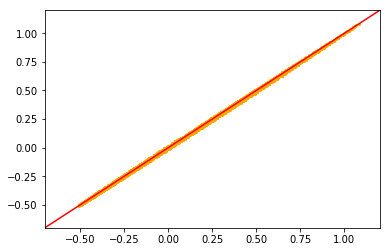

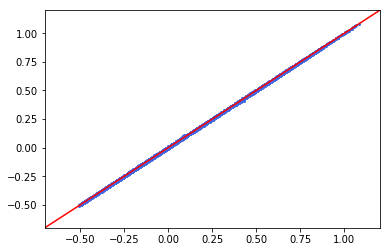

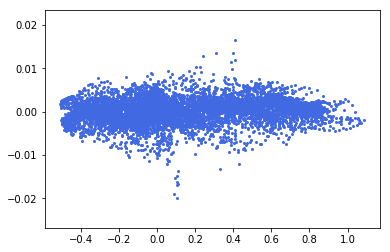

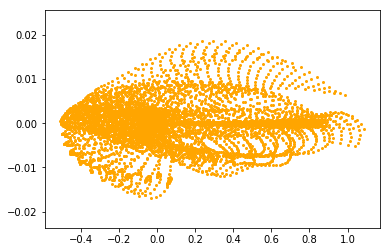

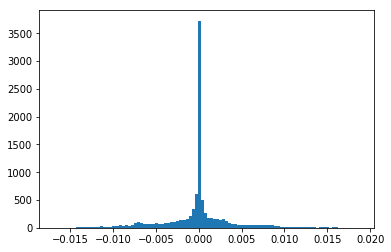

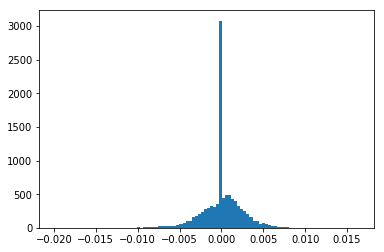

In [28]:
#compare training and test data


YtestDf = pd.read_csv("refdata.dat", sep = ' ',usecols=['Up','Wp'])
XtestDf = pd.read_csv("refdata.dat",sep=' ', usecols=['U','W','U0','W0','U1','W1',
                                                            'U2','W2','U3','W3','U4','W4',
                                                            'U5','W5','U6','W6','U7','W7',
                                                            'isfluid'])

Ytest = torch.tensor(YtestDf.values).float()
Xtest = torch.tensor(XtestDf.values).float()



Ymodel = model(Xtest)
# for xline,yline,ytest in zip(x,y,ytest):
#     print xline[0],xline[1],yline[0],yline[1],ytest[0],test[1]


# print 'x   ',XtestDf.U,XtestDf.W

# print 'y   ',YtestDf.Up,YtestDf.Wp

print 'mod ',Ymodel[:,0]

REF = np.linspace(-0.7,1.2)
plt.scatter(XtestDf.U,YtestDf.Up,s=4,c='orange')
# plt.scatter(Ymodel[:,0].detach(),YtestDf.Up,s=4,c='royalblue')
plt.plot(REF,REF,c='red')
plt.xlim(-0.7,1.2)
plt.ylim(-0.7,1.2)
plt.show()


REF = np.linspace(-0.7,1.2)
# plt.scatter(XtestDf.U,YtestDf.Up,s=4,c='orange')
plt.scatter(Ymodel[:,0].detach(),YtestDf.Up,s=4,c='royalblue')
plt.plot(REF,REF,c='red')
plt.xlim(-0.7,1.2)
plt.ylim(-0.7,1.2)
plt.show()

# print Ymodel[:,0].detach()
# print YtestDf.Up

plt.scatter(YtestDf.Up,(Ymodel[:,0].detach()-torch.tensor(YtestDf.Up.values).float()),s=4,c='royalblue')
plt.show()

plt.scatter(YtestDf.Up,(XtestDf.U-YtestDf.Up),s=4,c='orange')
plt.show()

plt.hist((XtestDf.U-YtestDf.Up),bins=100)
plt.show()


plt.hist((Ymodel[:,0].detach()-torch.tensor(YtestDf.Up.values).float()),bins=100)
plt.show()

In [29]:
torch.save(model, 'NNFD_6.9e-6.pt')

In [30]:
model2 = torch.load('NNFD_6.9e-6.pt')
model2.eval()

Sequential(
  (0): Linear(in_features=19, out_features=60, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=60, out_features=60, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=60, out_features=30, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=30, out_features=10, bias=True)
  (7): Softplus(beta=1, threshold=20)
  (8): Linear(in_features=10, out_features=2, bias=True)
)

In [31]:
Ymodel2 = model2(Xtest)

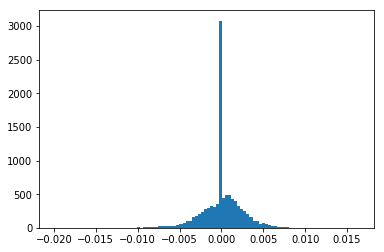

In [32]:
plt.hist((Ymodel2[:,0].detach()-torch.tensor(YtestDf.Up.values).float()),bins=100)
plt.show()